# WGCNA
weighted gene co-expression network analysis

# Phase 2 vs. Phase 2

following [Hovrath Lab Tutorial](https://www.dropbox.com/scl/fo/4vqfiysan6rlurfo2pbnk/h?dl=0&e=1&preview=Consensus-NetworkConstruction-man.pdf&rlkey=thqg8wlpdn4spu3ihjuc1kmlu)

## 0. load libraries

In [2]:
library(tidyverse)
library(DESeq2)
library(WGCNA)
library(janitor) # for row_to_names()
library(zoo)
library(ComplexHeatmap)
library(circlize)
library(reshape)
library(fastDummies) # create 0/1 factor columns

In [3]:
# important setting, cannot omit
options(stringsAsFactors = FALSE)

In [4]:
# allow multi-threading within WGCNA
enableWGCNAThreads()

Allowing parallel execution with up to 23 working processes.


## 1. structure WGCNA input

**Expected input**:
- Rows = samples
- Columns = genes (or probes/features)
- Values = numeric expression values

### A. format vst normalized counts matrix

In [5]:
# counts matrix
dataExpr <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_rawLFC/deseq_vstCounts.csv')

# set gene name as rowname
rownames(dataExpr) <- dataExpr$X

 
dataExpr <- dataExpr %>% 
select(-X) %>% # remove gene name as column
t() # transpose so samples = rows, genes = columns

head(dataExpr)
dim(dataExpr) # 94 samples x 35466 genes

LOC111116054 LOC111126949 LOC111110729 LOC111112434 LOC111120752
B1_B1_O01 7.692872     10.197580    8.354765     7.886383     9.363550    
B1_W5_O50 7.805746      9.653169    8.542687     7.697174     9.355360    
B2_B5_O51 7.871959      9.900281    8.351593     7.548551     9.509373    
B2_C4_O40 7.843091      9.718856    8.513945     7.687586     9.284512    
B3_B4_O41 7.548551      9.612738    8.518601     7.940109     9.198871    
B3_C3_O30 7.909124      9.545333    8.653091     7.989592     9.337765    
          LOC111128944 LOC111128953 LOC111105691 LOC111133554 LOC111125466 ⋯
B1_B1_O01 7.548551     7.548551     7.692872     7.548551     7.650623     ⋯
B1_W5_O50 7.548551     7.548551     7.845404     7.548551     7.548551     ⋯
B2_B5_O51 7.548551     7.548551     8.595408     7.548551     7.651014     ⋯
B2_C4_O40 7.548551     7.548551     8.101515     7.843091     7.548551     ⋯
B3_B4_O41 7.548551     7.548551     8.014009     7.548551     7.661902     ⋯
B3_C3_O30 7.548551     7.710140     8.149132     7.828140     7.926626     ⋯
          CYTB     COX2     ATP6     ND2      ND4      ND5      ND6     
B1_B1_O01 18.94773 17.35567 16.72734 16.55278 17.40296 17.50511 15.27334
B1_W5_O50 19.25087 17.60046 17.05547 16.54477 16.97662 17.30129 15.59674
B2_B5_O51 19.41971 17.94342 17.27196 17.23549 17.79404 18.11808 15.98559
B2_C4_O40 18.86611 17.79882 17.27281 16.61824 17.19524 17.19285 15.14694
B3_B4_O41 19.71514 18.17021 17.54836 17.11674 17.49138 17.97654 15.71235
B3_C3_O30 19.27273 17.87689 17.64807 17.08072 17.29751 17.13546 15.58747
          ND3      ND1      ND4L    
B1_B1_O01 14.40950 17.08613 13.21049
B1_W5_O50 14.95796 17.21506 13.41728
B2_B5_O51 15.64247 17.74181 13.77409
B2_C4_O40 14.83363 17.01083 13.11047
B3_B4_O41 15.28878 17.71717 13.87237
B3_C3_O30 15.14063 17.14174 13.28853

[1]    94 35466

### B. identify and remove genes with missing data 
genes with too many NAs or zero-counts

In [6]:
gsg <- goodSamplesGenes(dataExpr, verbose = 3)
gsg$allOK

dataExpr <- dataExpr[gsg$goodSamples, gsg$goodGenes]
dim(dataExpr) # 94 samples x 35396 genes

 Flagging genes and samples with too many missing values...
  ..step 1
  ..Excluding 70 genes from the calculation due to too many missing samples or zero variance.
  ..step 2


[1] FALSE

[1]    94 35396

### C. Sample size and gene filtering

removing low-variance genes first:

In [7]:
dataExpr <- dataExpr[, apply(dataExpr, 2, var) > quantile(apply(dataExpr, 2, var), 0.25)]
dim(dataExpr) # 94 samples x 26547 genes

[1]    94 26547

### D. Sample outlier detection

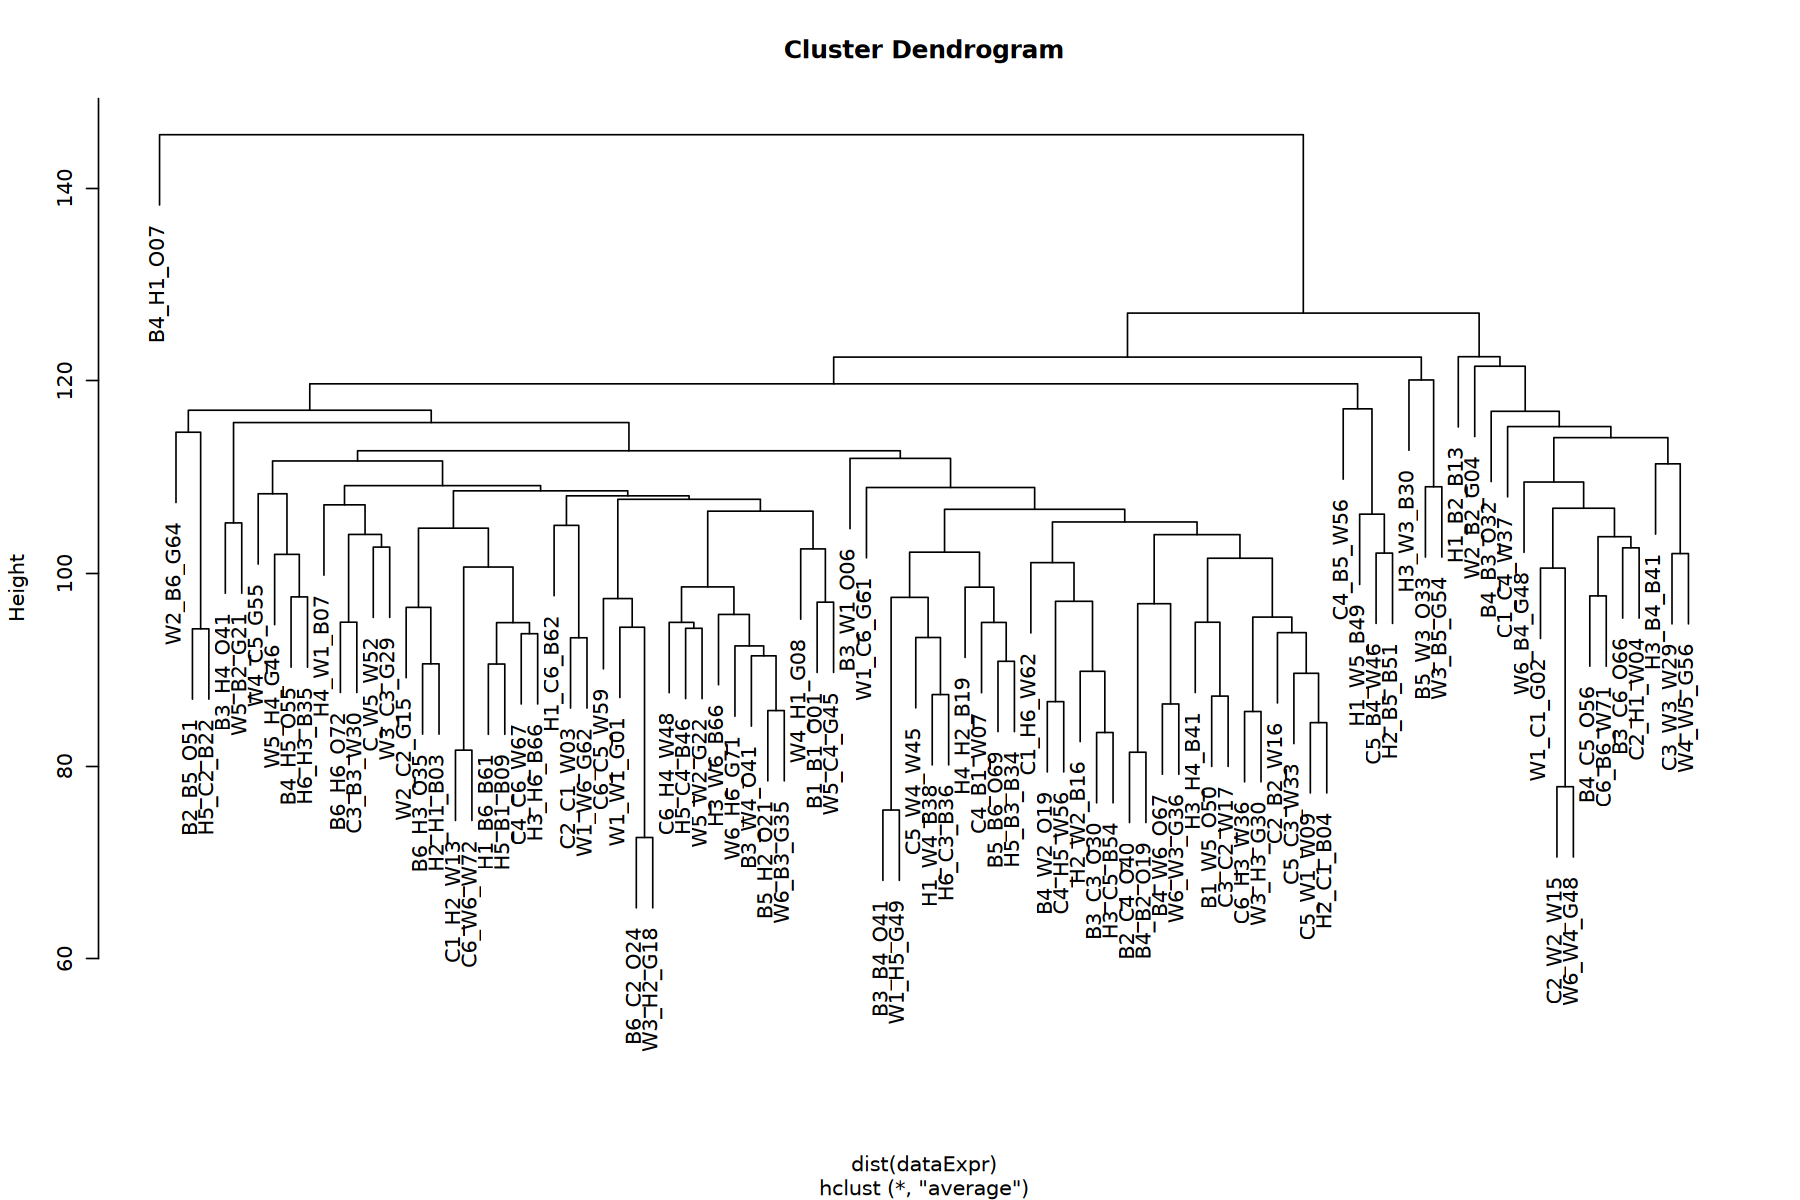

In [8]:
options(repr.plot.width = 15, repr.plot.height = 10)

sampleTree <- hclust(dist(dataExpr), method = "average")
plot(sampleTree)

only obvious outlier - B4_H1_O07 - becuase it clusters above the rest of the tree and is separated from the main cluster - going to remove it from analysis

In [9]:
dataExpr <- dataExpr[!rownames(dataExpr) %in% c("B4_H1_O07"), ]
dim(dataExpr) # 93 samples x 26547 genes

[1]    93 26547

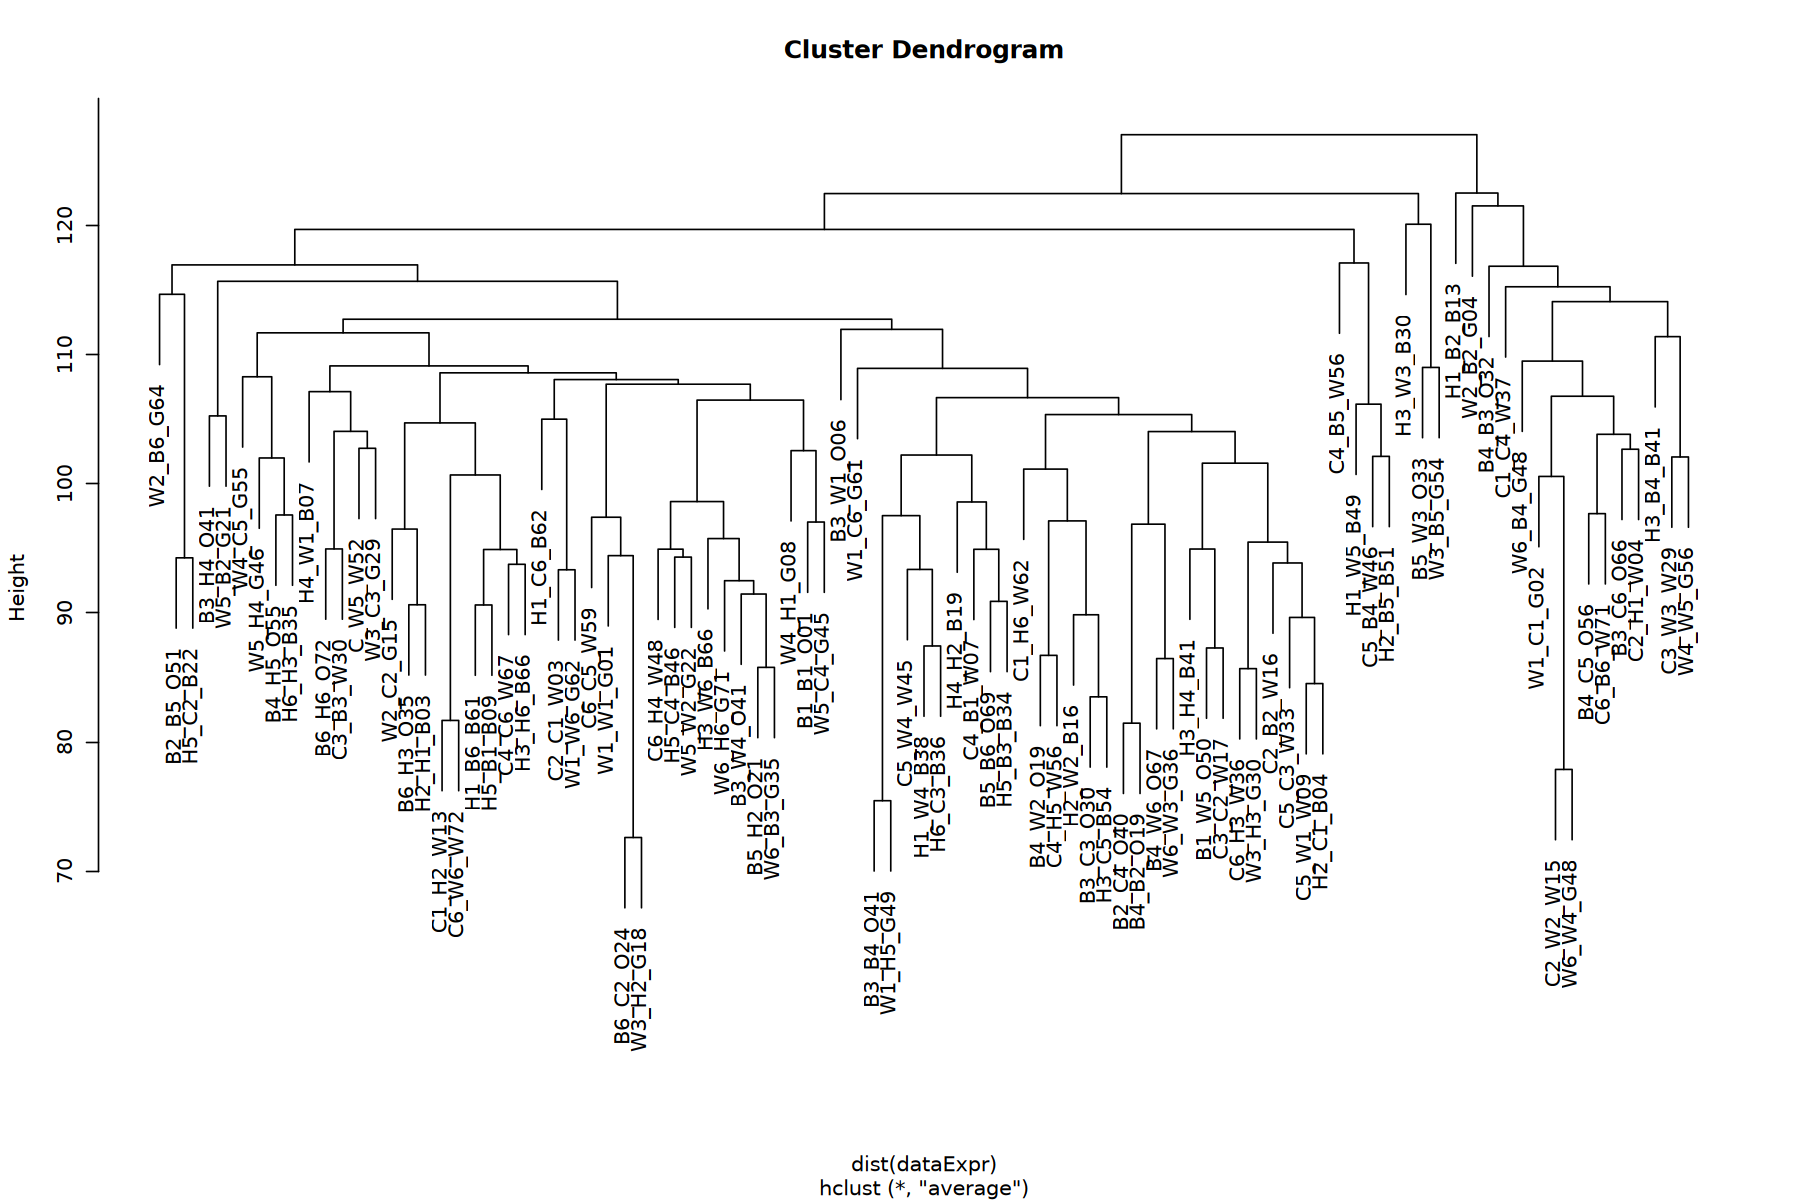

In [10]:
# replot without outliers
sampleTree <- hclust(dist(dataExpr), method = "average")
plot(sampleTree)

looks much better!

### meta data
could add phenotypic data to this ...

In [11]:
meta <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/metaData/sample_metaData.csv') %>%
filter(!grepl("Nu", Sample)) # filter out phase 1 samples - only want phase 2

# setting samples as rownames and deleting col from df
rownames(meta) <- meta$Sample
meta <- meta[, !colnames(meta) %in% "Sample"]

# removing same samples as dataExpr
meta <- meta[rownames(meta) %in% rownames(dataExpr), ]

head(meta)
dim(meta) # 92 samples

Phase1_treatment Phase1_temp Phase1_DO Phase1_TankRep
B1_B1_O01 both             warm        hypoxic   1             
B1_W5_O50 both             warm        hypoxic   1             
B2_B5_O51 both             warm        hypoxic   2             
B2_C4_O40 both             warm        hypoxic   2             
B3_B4_O41 both             warm        hypoxic   3             
B3_C3_O30 both             warm        hypoxic   3             
          Phase2_treatment Phase2_temp Phase2_DO Phase2_TankRep
B1_B1_O01 both             warm        hypoxic   1             
B1_W5_O50 warm             warm        normoxic  5             
B2_B5_O51 both             warm        hypoxic   5             
B2_C4_O40 control          ambient     normoxic  4             
B3_B4_O41 both             warm        hypoxic   4             
B3_C3_O30 control          ambient     normoxic  3

[1] 93  8

creating new column for 'complete' treatment - so I can easily compare phase 1 to phase 2

In [12]:
meta$complete_trtmt <- paste(meta$Phase1_treatment, meta$Phase2_treatment)

In [13]:
# double checking the samples in rownames are the same
all(rownames(meta) == rownames(dataExpr))

[1] TRUE

## 2. simple WGCNA network construction and module identification
start with simple, can progress to consensus if deemed necessary

In [14]:
# final QC check
gsg <- goodSamplesGenes(dataExpr, verbose = 3)
if (!gsg$allOK) {
  dataExpr <- dataExpr[gsg$goodSamples, gsg$goodGenes]
}

gsg$allOK

 Flagging genes and samples with too many missing values...
  ..step 1


[1] TRUE

### A. choose soft thresholding power (β)
analysis of network topology

In [15]:
powers <- c(1:20)
sft <- pickSoftThreshold(
  dataExpr,
  powerVector = powers,
  networkType = "signed",
  verbose = 5
)


pickSoftThreshold: will use block size 1685.
 pickSoftThreshold: calculating connectivity for given powers...
   ..working on genes 1 through 1685 of 26547
   ..working on genes 1686 through 3370 of 26547
   ..working on genes 3371 through 5055 of 26547
   ..working on genes 5056 through 6740 of 26547
   ..working on genes 6741 through 8425 of 26547
   ..working on genes 8426 through 10110 of 26547
   ..working on genes 10111 through 11795 of 26547
   ..working on genes 11796 through 13480 of 26547
   ..working on genes 13481 through 15165 of 26547
   ..working on genes 15166 through 16850 of 26547
   ..working on genes 16851 through 18535 of 26547
   ..working on genes 18536 through 20220 of 26547
   ..working on genes 20221 through 21905 of 26547
   ..working on genes 21906 through 23590 of 26547
   ..working on genes 23591 through 25275 of 26547
   ..working on genes 25276 through 26547 of 26547
   Power SFT.R.sq  slope truncated.R.sq  mean.k. median.k. max.k.
1      1   0.0177 -12.

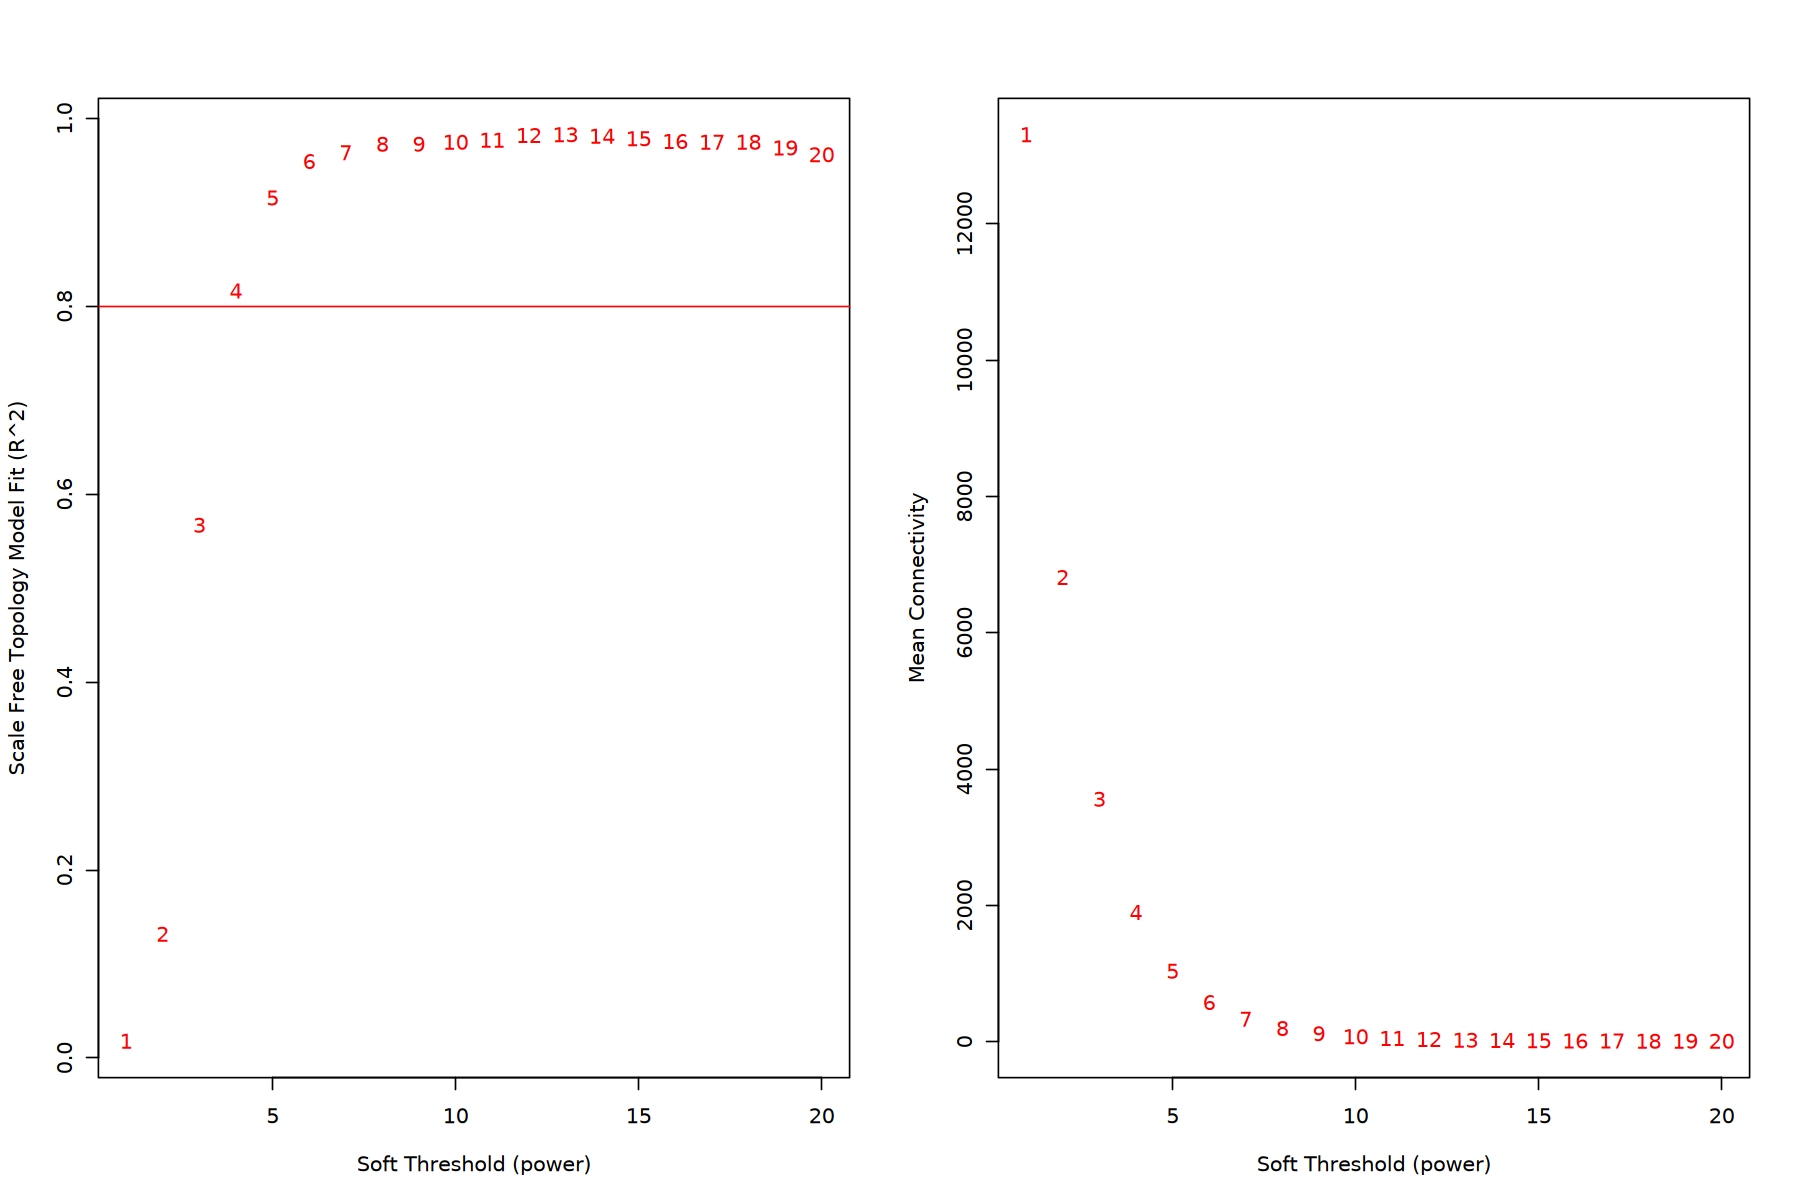

In [16]:
par(mfrow = c(1,2))
plot(
  sft$fitIndices[,1],
  -sign(sft$fitIndices[,3]) * sft$fitIndices[,2],
  xlab = "Soft Threshold (power)",
  ylab = "Scale Free Topology Model Fit (R^2)",
  type = "n"
)
text(
  sft$fitIndices[,1],
  -sign(sft$fitIndices[,3]) * sft$fitIndices[,2],
  labels = powers,
  col = "red"
)
abline(h = 0.8, col = "red")

plot(
  sft$fitIndices[,1],
  sft$fitIndices[,5],
  xlab = "Soft Threshold (power)",
  ylab = "Mean Connectivity",
  type = "n"
)
text(
  sft$fitIndices[,1],
  sft$fitIndices[,5],
  labels = powers,
  col = "red"
)


#### left plot - scale-free topology
the red line is where R^2 is 0.8 - you want the lowest power that reaches this - 4 is just above 0.8 and anything after 6 plateaus

#### right plot - mean connectivity
connectivity should not collapse to 0 - by power 8-10, the connectivity approaches 0

based on this, I think power of 5 should be appropriate

### B. co-expression similarity and adjacency

creating adjacency matrix

In [17]:
softPower <- 5

calculate co-expression adjacency using soft threshold power of 5

can do this signed or unsigned (default) - at this point, I'm not too sure what the difference is

In [18]:
# unsigned
adjacency_unsign <- adjacency(dataExpr, power = softPower, type = 'unsigned') 
head(adjacency_unsign)

# signed
adjacency_sign <- adjacency(dataExpr, power = softPower, type = 'signed') 
head(adjacency_sign)

LOC111126949 LOC111120752 LOC111105691 LOC111113860 LOC111109550
LOC111126949 1.000000e+00 1.782543e-03 2.752219e-08 4.600205e-07 9.155717e-05
LOC111120752 1.782543e-03 1.000000e+00 1.716104e-06 3.146263e-08 7.358584e-05
LOC111105691 2.752219e-08 1.716104e-06 1.000000e+00 1.084102e-06 1.915999e-05
LOC111113860 4.600205e-07 3.146263e-08 1.084102e-06 1.000000e+00 2.333026e-05
LOC111109550 9.155717e-05 7.358584e-05 1.915999e-05 2.333026e-05 1.000000e+00
LOC111109753 1.656267e-05 1.762023e-09 2.407908e-07 8.882854e-06 4.656518e-06
             LOC111109753 LOC111109452 LOC111124802 LOC111101273 LOC111101250 ⋯
LOC111126949 1.656267e-05 8.391595e-13 2.581975e-03 1.319233e-02 4.230721e-05 ⋯
LOC111120752 1.762023e-09 1.690230e-05 1.070843e-05 3.894397e-02 1.183032e-05 ⋯
LOC111105691 2.407908e-07 6.601852e-07 6.362332e-11 5.738142e-08 2.303477e-04 ⋯
LOC111113860 8.882854e-06 3.091483e-04 1.303715e-07 1.645528e-07 5.683632e-07 ⋯
LOC111109550 4.656518e-06 4.186890e-08 2.371397e-05 2.300438e-07 1.194374e-06 ⋯
LOC111109753 1.000000e+00 2.298499e-08 2.020960e-04 8.740811e-04 2.179421e-08 ⋯
             CYTB         COX2         ATP6         ND2          ND4         
LOC111126949 7.160573e-07 1.558930e-05 5.919973e-06 1.493077e-04 2.374682e-09
LOC111120752 8.026964e-03 6.595698e-03 1.598050e-02 4.779981e-03 3.795156e-02
LOC111105691 2.204940e-04 1.582523e-08 5.902503e-10 4.193395e-08 1.465177e-06
LOC111113860 6.034621e-06 4.048877e-04 1.244493e-03 1.803356e-04 7.549985e-06
LOC111109550 6.849831e-15 2.213905e-04 7.697647e-08 7.936029e-06 4.187663e-07
LOC111109753 3.920238e-05 1.177167e-06 4.570454e-16 3.930212e-07 8.284044e-07
             ND5          ND6          ND3          ND1          ND4L        
LOC111126949 5.391527e-09 5.879192e-05 1.105667e-08 2.965007e-06 6.959330e-07
LOC111120752 4.617818e-03 2.676368e-02 1.774048e-02 1.566690e-02 1.381881e-02
LOC111105691 4.447607e-05 2.631513e-11 1.409498e-07 1.039271e-05 2.704959e-09
LOC111113860 2.280600e-06 6.601983e-04 4.168502e-05 2.332036e-04 4.252386e-04
LOC111109550 8.517485e-10 7.454661e-10 5.411355e-08 1.497762e-07 1.762907e-14
LOC111109753 1.910615e-04 1.535774e-07 4.270411e-05 1.626405e-04 1.795192e-05

LOC111126949 LOC111120752 LOC111105691 LOC111113860 LOC111109550
LOC111126949 1.00000000   0.00596421   0.02673096   0.02367334   0.06443312  
LOC111120752 0.00596421   1.00000000   0.02170610   0.03650792   0.06259823  
LOC111105691 0.02673096   0.02170610   1.00000000   0.04263922   0.05358685  
LOC111113860 0.02367334   0.03650792   0.04263922   1.00000000   0.05469640  
LOC111109550 0.06443312   0.06259823   0.05358685   0.05469640   1.00000000  
LOC111109753 0.05280483   0.02857326   0.03940373   0.01869409   0.04716812  
             LOC111109753 LOC111109452 LOC111124802 LOC111101273 LOC111101250 ⋯
LOC111126949 0.05280483   0.03185524   0.11767250   0.002037204  0.01527023   ⋯
LOC111120752 0.02857326   0.05291190   0.05064454   0.255646300  0.01810499   ⋯
LOC111105691 0.03940373   0.02317122   0.02984845   0.037227386  0.01108081   ⋯
LOC111113860 0.01869409   0.01032832   0.02521879   0.038753608  0.02338274   ⋯
LOC111109550 0.04716812   0.03683787   0.05479113   0.024561187  0.02228596   ⋯
LOC111109753 1.00000000   0.02688139   0.07223356   0.007690798  0.02692491   ⋯
             CYTB       COX2        ATP6        ND2        ND4       
LOC111126949 0.04162633 0.017520275 0.019496087 0.01218261 0.02841485
LOC111120752 0.15696330 0.148799263 0.191643328 0.13676826 0.25339540
LOC111105691 0.01119240 0.035795722 0.029084096 0.03683972 0.02196268
LOC111113860 0.01945904 0.009637944 0.006821705 0.01170431 0.01901998
LOC111109550 0.03102108 0.011182048 0.037616489 0.01892067 0.04045961
LOC111109753 0.05793885 0.042853010 0.031116627 0.04033135 0.04197053
             ND5        ND6         ND3        ND1        ND4L       
LOC111126949 0.03487613 0.014487059 0.02744560 0.04558078 0.041560431
LOC111120752 0.13556982 0.225477159 0.19787840 0.19049290 0.183436092
LOC111105691 0.01515245 0.032464819 0.03850535 0.01837367 0.028342929
LOC111113860 0.02123009 0.008394532 0.01530505 0.01104935 0.009512618
LOC111109550 0.03372294 0.028983659 0.03715280 0.03860167 0.030973609
LOC111109753 0.07161344 0.038641818 0.05852193 0.06989560 0.053233270

### C. Topological Overlap Matrix (TOM)
transform adjacency into TOM to minimize effects of noise and spurious associations - calculate corresponding dissimilarity

In [19]:
## UNSIGNED
# turn adjacency into topological overlap
TOM_unsign <- TOMsimilarity(adjacency_unsign)
head(TOM_unsign)

# calculate dissimilarity
dissTOM_unsign <- 1-TOM_unsign
head(dissTOM_unsign)


## SIGNED
# turn adjacency into topological overlap
TOM_sign <- TOMsimilarity(adjacency_sign)
head(TOM_sign)

# calculate dissimilarity
dissTOM_sign <- 1-TOM_sign
head(dissTOM_sign)

..connectivity..
..matrix multiplication (system BLAS)..
..normalization..
..done.


[,1]         [,2]         [,3]         [,4]         [,5]        
[1,] 1.0000000000 0.0042933083 1.852709e-04 5.818304e-04 0.0005404566
[2,] 0.0042933083 1.0000000000 2.773913e-04 1.873669e-03 0.0004478330
[3,] 0.0001852709 0.0002773913 1.000000e+00 5.565506e-05 0.0001184485
[4,] 0.0005818304 0.0018736690 5.565506e-05 1.000000e+00 0.0001005873
[5,] 0.0005404566 0.0004478330 1.184485e-04 1.005873e-04 1.0000000000
[6,] 0.0003144408 0.0001914498 2.327076e-04 1.449656e-04 0.0003099846
     [,6]         [,7]         [,8]         [,9]         [,10]        [,11]
[1,] 0.0003144408 0.0005682741 0.0020470717 0.0071768146 0.0037048014 ⋯    
[2,] 0.0001914498 0.0012254369 0.0010705347 0.0226939637 0.0030848120 ⋯    
[3,] 0.0002327076 0.0001395993 0.0001562924 0.0001999636 0.0007183777 ⋯    
[4,] 0.0001449656 0.0014757616 0.0003609820 0.0011261494 0.0016916643 ⋯    
[5,] 0.0003099846 0.0001955092 0.0004039726 0.0003043675 0.0003599073 ⋯    
[6,] 1.0000000000 0.0001828311 0.0004006687 0.0004618206 0.0001673186 ⋯    
     [,12]        [,13]        [,14]        [,15]        [,16]       
[1,] 0.0004408250 0.0005759230 0.0005677051 0.0004982259 0.0008827370
[2,] 0.0164825038 0.0195005626 0.0236828804 0.0198913808 0.0231048502
[3,] 0.0003600078 0.0001663546 0.0001553802 0.0001165873 0.0002603584
[4,] 0.0005621569 0.0006108221 0.0007841932 0.0004435304 0.0007163779
[5,] 0.0002965254 0.0003927036 0.0002604835 0.0001557174 0.0003543204
[6,] 0.0008082062 0.0004760549 0.0001727626 0.0003480783 0.0003218440
     [,17]        [,18]        [,19]        [,20]        [,21]       
[1,] 0.0003837645 0.0007463244 0.0005814072 0.0006610943 0.0004647112
[2,] 0.0120065692 0.0230095491 0.0235759301 0.0164464391 0.0184666636
[3,] 0.0002545397 0.0002055112 0.0002058637 0.0003232873 0.0001910332
[4,] 0.0004381356 0.0010218126 0.0006395913 0.0008489379 0.0006412816
[5,] 0.0002128943 0.0003100519 0.0003067601 0.0003578739 0.0002432699
[6,] 0.0011239916 0.0002740738 0.0007224079 0.0027691623 0.0018399482

[,1]      [,2]      [,3]      [,4]      [,5]      [,6]      [,7]     
[1,] 0.0000000 0.9957067 0.9998147 0.9994182 0.9994595 0.9996856 0.9994317
[2,] 0.9957067 0.0000000 0.9997226 0.9981263 0.9995522 0.9998086 0.9987746
[3,] 0.9998147 0.9997226 0.0000000 0.9999443 0.9998816 0.9997673 0.9998604
[4,] 0.9994182 0.9981263 0.9999443 0.0000000 0.9998994 0.9998550 0.9985242
[5,] 0.9994595 0.9995522 0.9998816 0.9998994 0.0000000 0.9996900 0.9998045
[6,] 0.9996856 0.9998086 0.9997673 0.9998550 0.9996900 0.0000000 0.9998172
     [,8]      [,9]      [,10]     [,11] [,12]     [,13]     [,14]    
[1,] 0.9979529 0.9928232 0.9962952 ⋯     0.9995592 0.9994241 0.9994323
[2,] 0.9989295 0.9773060 0.9969152 ⋯     0.9835175 0.9804994 0.9763171
[3,] 0.9998437 0.9998000 0.9992816 ⋯     0.9996400 0.9998336 0.9998446
[4,] 0.9996390 0.9988739 0.9983083 ⋯     0.9994378 0.9993892 0.9992158
[5,] 0.9995960 0.9996956 0.9996401 ⋯     0.9997035 0.9996073 0.9997395
[6,] 0.9995993 0.9995382 0.9998327 ⋯     0.9991918 0.9995239 0.9998272
     [,15]     [,16]     [,17]     [,18]     [,19]     [,20]     [,21]    
[1,] 0.9995018 0.9991173 0.9996162 0.9992537 0.9994186 0.9993389 0.9995353
[2,] 0.9801086 0.9768951 0.9879934 0.9769905 0.9764241 0.9835536 0.9815333
[3,] 0.9998834 0.9997396 0.9997455 0.9997945 0.9997941 0.9996767 0.9998090
[4,] 0.9995565 0.9992836 0.9995619 0.9989782 0.9993604 0.9991511 0.9993587
[5,] 0.9998443 0.9996457 0.9997871 0.9996899 0.9996932 0.9996421 0.9997567
[6,] 0.9996519 0.9996782 0.9988760 0.9997259 0.9992776 0.9972308 0.9981601

..connectivity..
..matrix multiplication (system BLAS)..
..normalization..
..done.


[,1]       [,2]       [,3]       [,4]       [,5]       [,6]      
[1,] 1.00000000 0.03203669 0.04325609 0.03859603 0.04767874 0.04841777
[2,] 0.03203669 1.00000000 0.04151904 0.04947939 0.04474896 0.04240832
[3,] 0.04325609 0.04151904 1.00000000 0.03602860 0.03812489 0.04259115
[4,] 0.03859603 0.04947939 0.03602860 1.00000000 0.03793008 0.04057033
[5,] 0.04767874 0.04474896 0.03812489 0.03793008 1.00000000 0.04515372
[6,] 0.04841777 0.04240832 0.04259115 0.04057033 0.04515372 1.00000000
     [,7]       [,8]       [,9]       [,10]      [,11] [,12]      [,13]     
[1,] 0.04451317 0.05394023 0.02788190 0.03691653 ⋯     0.04095883 0.03843461
[2,] 0.04069907 0.04546719 0.07603718 0.03576878 ⋯     0.06625035 0.06621622
[3,] 0.03941299 0.04030782 0.03924153 0.03933737 ⋯     0.04050891 0.04099153
[4,] 0.03429513 0.03711149 0.04525296 0.04092677 ⋯     0.04474596 0.04012829
[5,] 0.03986899 0.04416545 0.03677512 0.04383935 ⋯     0.04130757 0.03881138
[6,] 0.04496422 0.05007689 0.03452615 0.04054339 ⋯     0.05118587 0.04825489
     [,14]      [,15]      [,16]      [,17]      [,18]      [,19]     
[1,] 0.03899431 0.03807728 0.04075141 0.04319353 0.03923952 0.04058928
[2,] 0.06956860 0.06530790 0.07331335 0.06192108 0.06849582 0.06912506
[3,] 0.04117581 0.04055060 0.04217482 0.03939417 0.04255275 0.04350582
[4,] 0.03969172 0.04049417 0.04444097 0.04076944 0.03947218 0.04203759
[5,] 0.04178284 0.03773336 0.04446496 0.04154167 0.04249430 0.04248601
[6,] 0.04445493 0.04639658 0.04698003 0.05398672 0.04633184 0.05064223
     [,20]      [,21]     
[1,] 0.04422606 0.04232475
[2,] 0.07022219 0.06638767
[3,] 0.04239243 0.04209052
[4,] 0.04310102 0.04108138
[5,] 0.04382650 0.04165347
[6,] 0.05719088 0.05367676

[,1]      [,2]      [,3]      [,4]      [,5]      [,6]      [,7]     
[1,] 0.0000000 0.9679633 0.9567439 0.9614040 0.9523213 0.9515822 0.9554868
[2,] 0.9679633 0.0000000 0.9584810 0.9505206 0.9552510 0.9575917 0.9593009
[3,] 0.9567439 0.9584810 0.0000000 0.9639714 0.9618751 0.9574089 0.9605870
[4,] 0.9614040 0.9505206 0.9639714 0.0000000 0.9620699 0.9594297 0.9657049
[5,] 0.9523213 0.9552510 0.9618751 0.9620699 0.0000000 0.9548463 0.9601310
[6,] 0.9515822 0.9575917 0.9574089 0.9594297 0.9548463 0.0000000 0.9550358
     [,8]      [,9]      [,10]     [,11] [,12]     [,13]     [,14]    
[1,] 0.9460598 0.9721181 0.9630835 ⋯     0.9590412 0.9615654 0.9610057
[2,] 0.9545328 0.9239628 0.9642312 ⋯     0.9337496 0.9337838 0.9304314
[3,] 0.9596922 0.9607585 0.9606626 ⋯     0.9594911 0.9590085 0.9588242
[4,] 0.9628885 0.9547470 0.9590732 ⋯     0.9552540 0.9598717 0.9603083
[5,] 0.9558345 0.9632249 0.9561606 ⋯     0.9586924 0.9611886 0.9582172
[6,] 0.9499231 0.9654738 0.9594566 ⋯     0.9488141 0.9517451 0.9555451
     [,15]     [,16]     [,17]     [,18]     [,19]     [,20]     [,21]    
[1,] 0.9619227 0.9592486 0.9568065 0.9607605 0.9594107 0.9557739 0.9576752
[2,] 0.9346921 0.9266867 0.9380789 0.9315042 0.9308749 0.9297778 0.9336123
[3,] 0.9594494 0.9578252 0.9606058 0.9574472 0.9564942 0.9576076 0.9579095
[4,] 0.9595058 0.9555590 0.9592306 0.9605278 0.9579624 0.9568990 0.9589186
[5,] 0.9622666 0.9555350 0.9584583 0.9575057 0.9575140 0.9561735 0.9583465
[6,] 0.9536034 0.9530200 0.9460133 0.9536682 0.9493578 0.9428091 0.9463232

### D. Call the hierarchical clustering function - plot the tree
hierarchical clustering tree (dendrogram) of genes

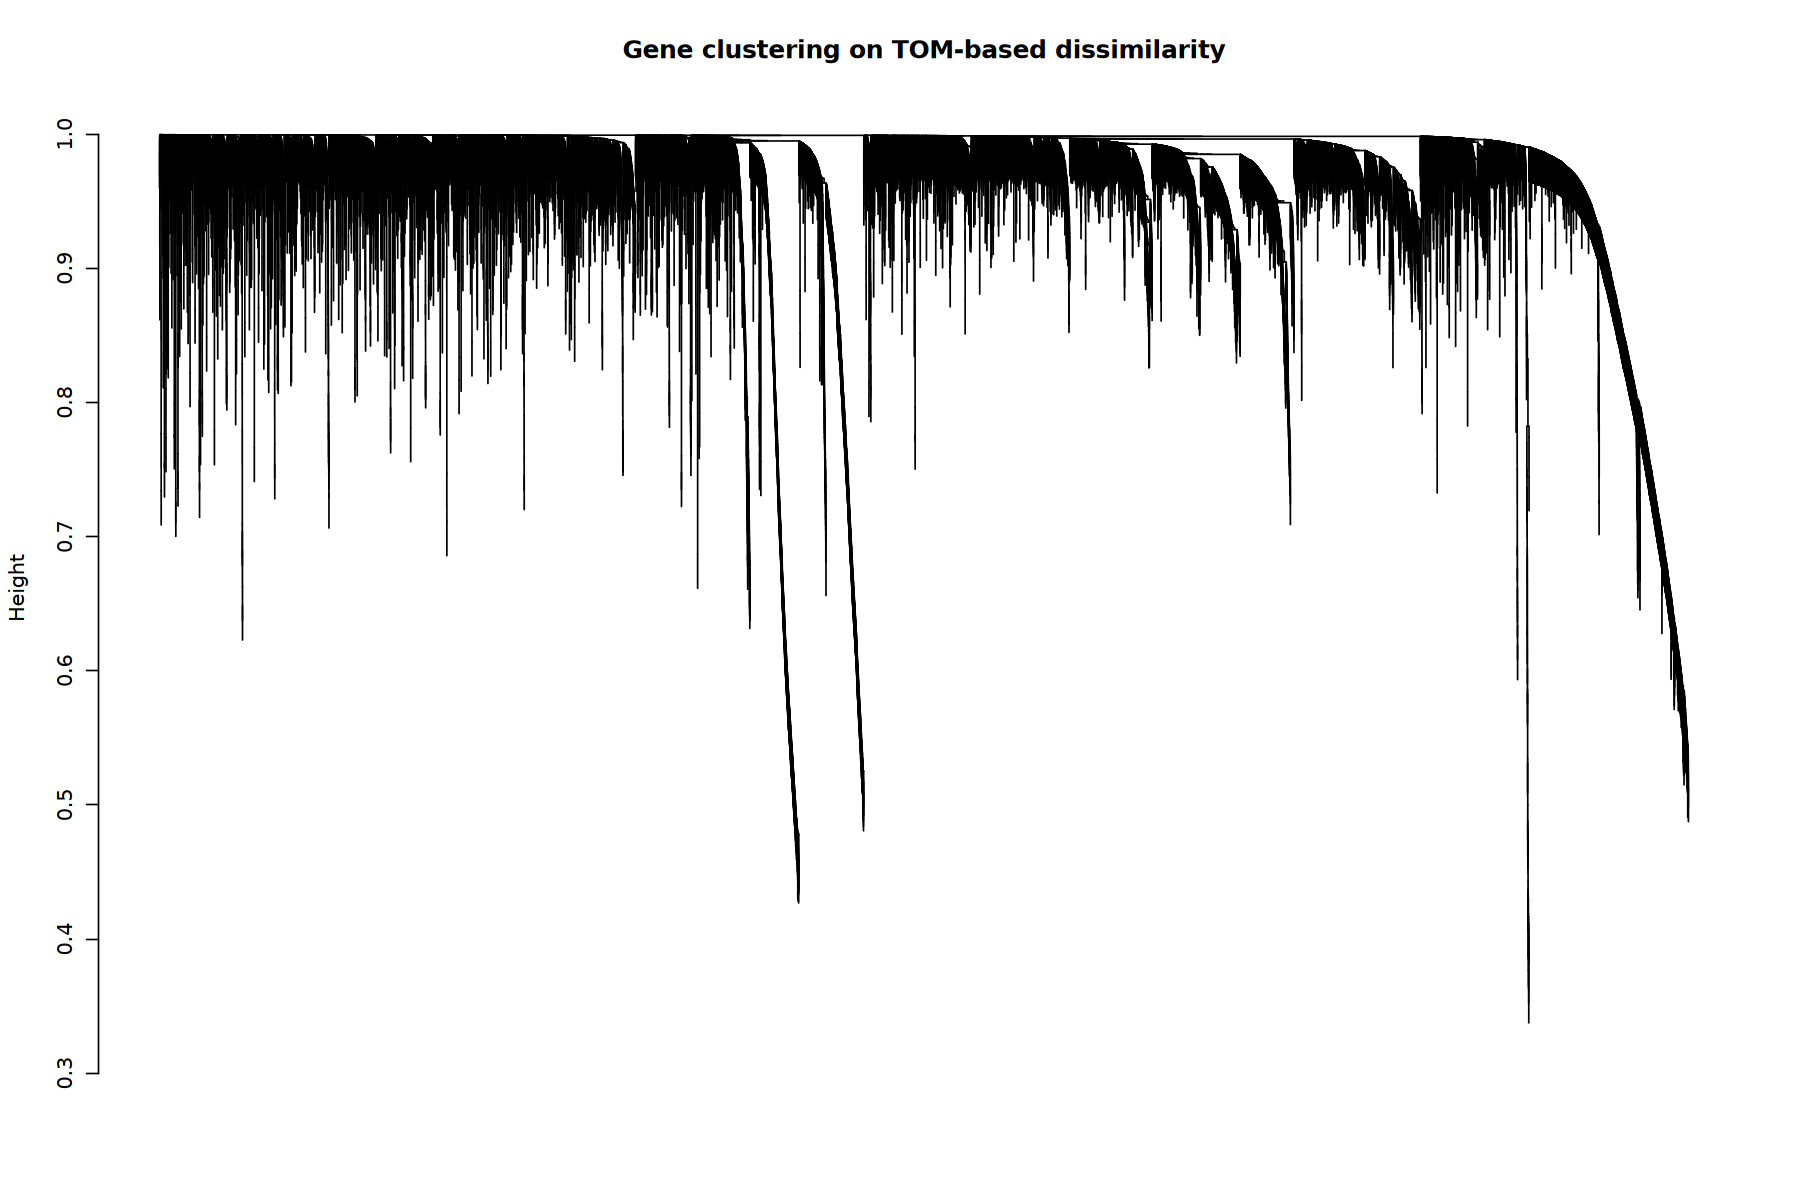

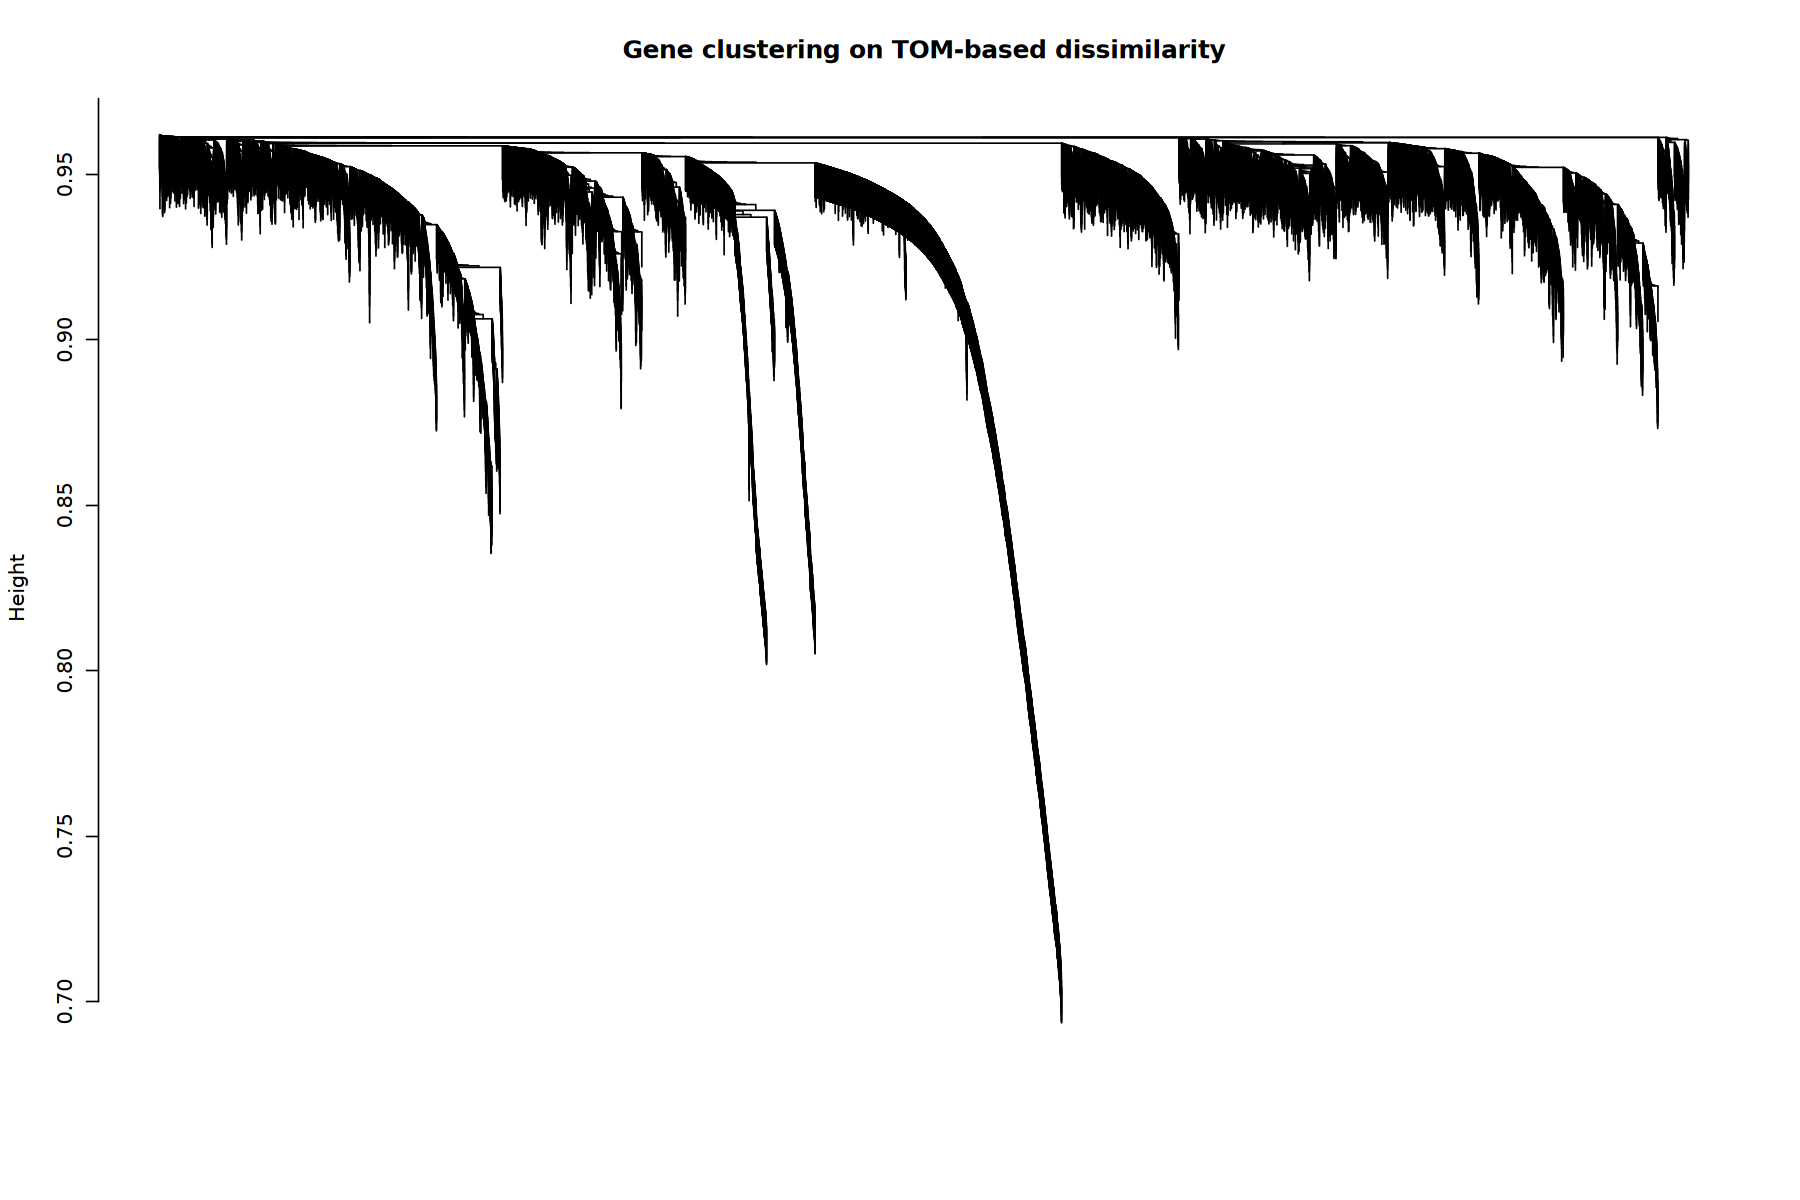

In [20]:
# call hierarchical clustering function
geneTree_unsign = hclust(as.dist(dissTOM_unsign), method = "average")
geneTree_sign = hclust(as.dist(dissTOM_sign), method = "average")

# plot the dendrogram
plot(geneTree_unsign, xlab="", sub="", main = "Gene clustering on TOM-based dissimilarity",labels = FALSE, hang = 0.04)
plot(geneTree_sign, xlab="", sub="", main = "Gene clustering on TOM-based dissimilarity",labels = FALSE, hang = 0.04)

looks like the signed adjacency matrix resulted in more distinct leafs than the unsigned matrix ...

from here on out, I'm going to use the ***signed*** correlation matrix

each leaf (short vertical line) corresponds to a gene - branches group together densely interconnected, highly co-expressed genes

module identification = cutting branches off the dendrogram

### E. module identification

set minimum module size - this is the smallest number of genes allowed to be put into a module 

then use Dynamic Tree Cut which is the default method for branch cutting and module detection

In [21]:
# would like large modules, so we set the minimum module size relatively high:
minModuleSize <- 100

## SIGNED
# Module identification using dynamic tree cut:
dynamicMods_sign <- cutreeDynamic(dendro = geneTree_sign, distM = dissTOM_sign, 
                             deepSplit = 2, pamRespectsDendro = FALSE,
                             minClusterSize = minModuleSize)
table(dynamicMods_sign) # number of genes per module

 ..cutHeight not given, setting it to 0.961  ===>  99% of the (truncated) height range in dendro.
 ..done.


dynamicMods_sign
   1    2    3    4    5    6    7    8    9   10   11   12   13   14   15 
4323 3879 3321 3210 2037 1975 1677 1629 1100  902  777  544  542  349  282 

15 modules generated

convert numeric network to colors and plots dendrogram:

dynamicColors_sign
       black         blue        brown         cyan        green  greenyellow 
        1677         3879         3321          349         2037          777 
     magenta midnightblue         pink       purple          red       salmon 
        1100          282         1629          902         1975          542 
         tan    turquoise       yellow 
         544         4323         3210 

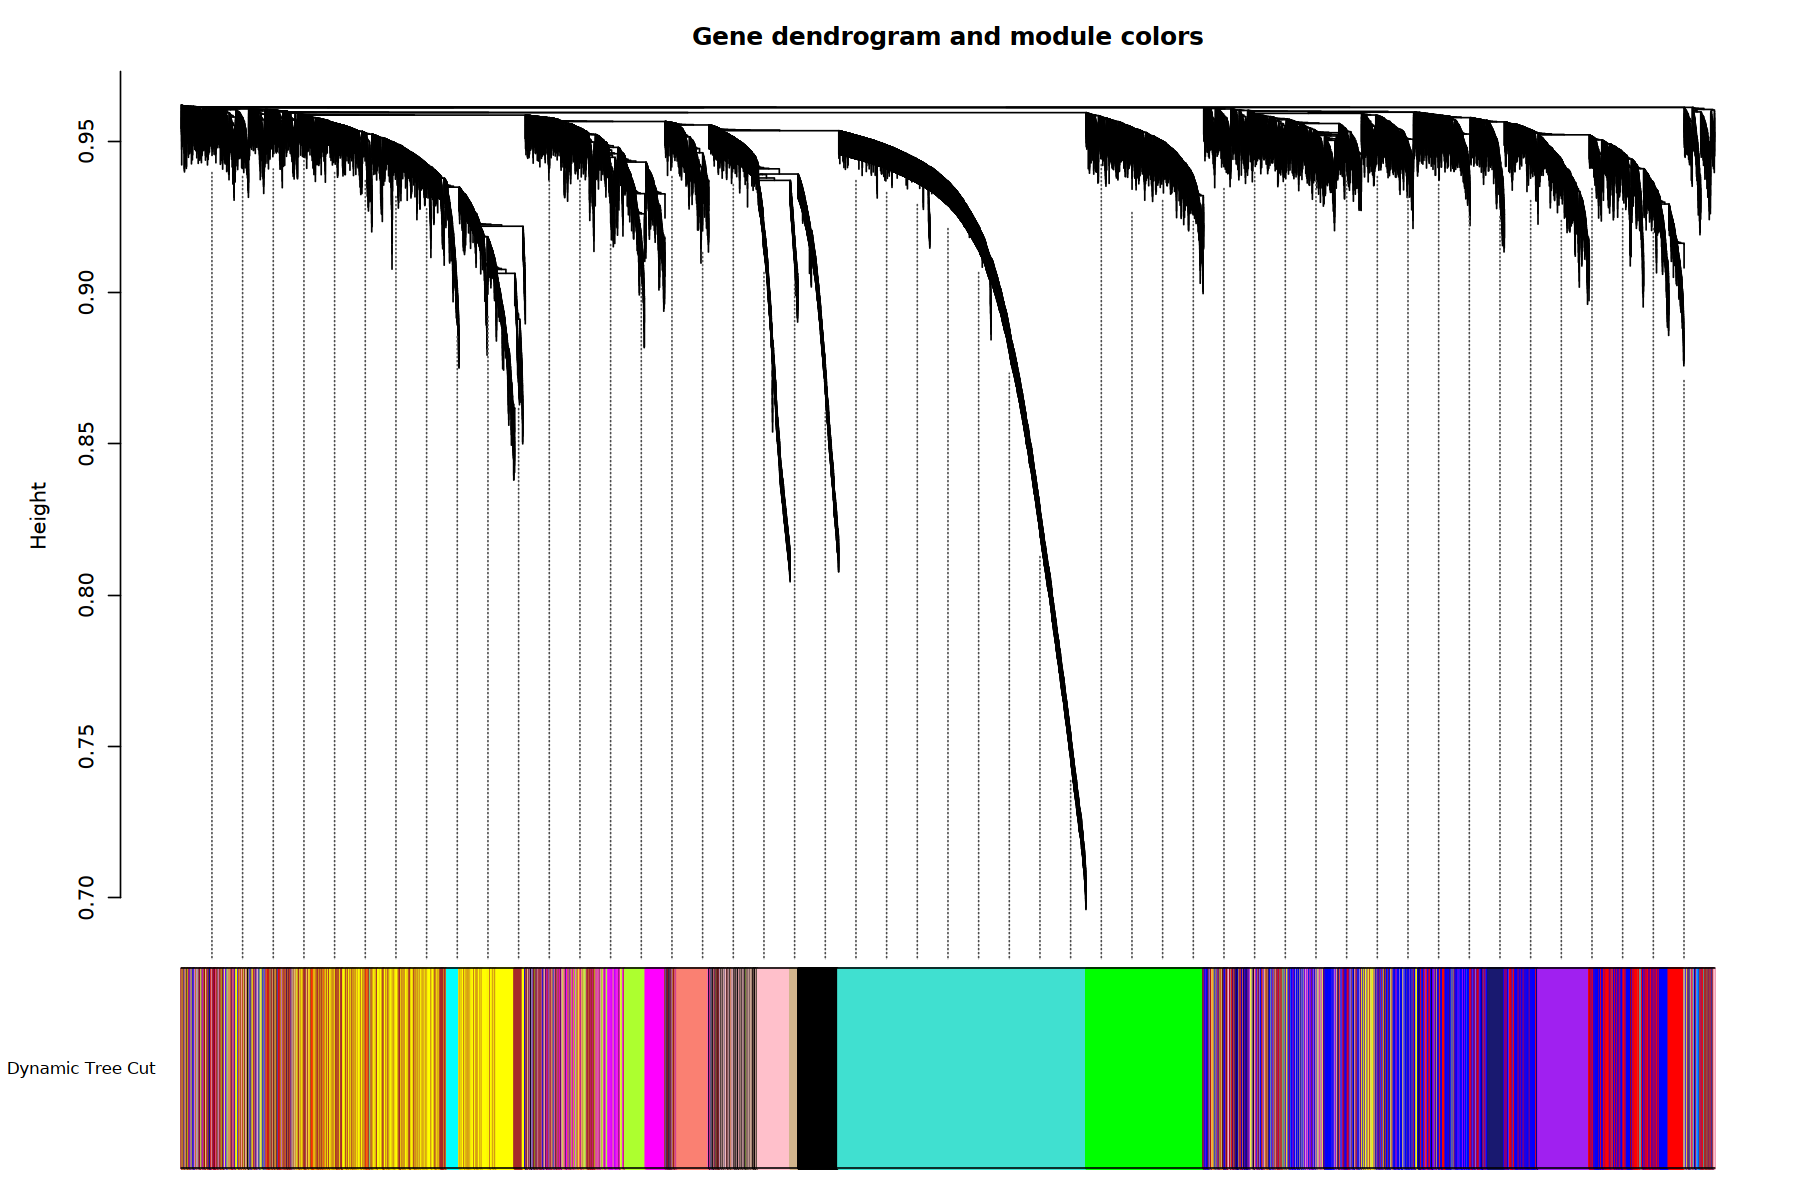

In [22]:
## SIGNED
# Convert numeric lables into colors
dynamicColors_sign <- labels2colors(dynamicMods_sign)
table(dynamicColors_sign)

# Plot the dendrogram and colors underneath
plotDendroAndColors(geneTree_sign, dynamicColors_sign, "Dynamic Tree Cut",
                    dendroLabels = FALSE, hang = 0.03,
                    addGuide = TRUE, guideHang = 0.05,
                    main = "Gene dendrogram and module colors")


### F. merging modules whose GE profiles are similar

this is based on eigengenes, which is the first principal component of a given a gene expression matrix/module that acts as a representative summary profile for a gene module or cluster

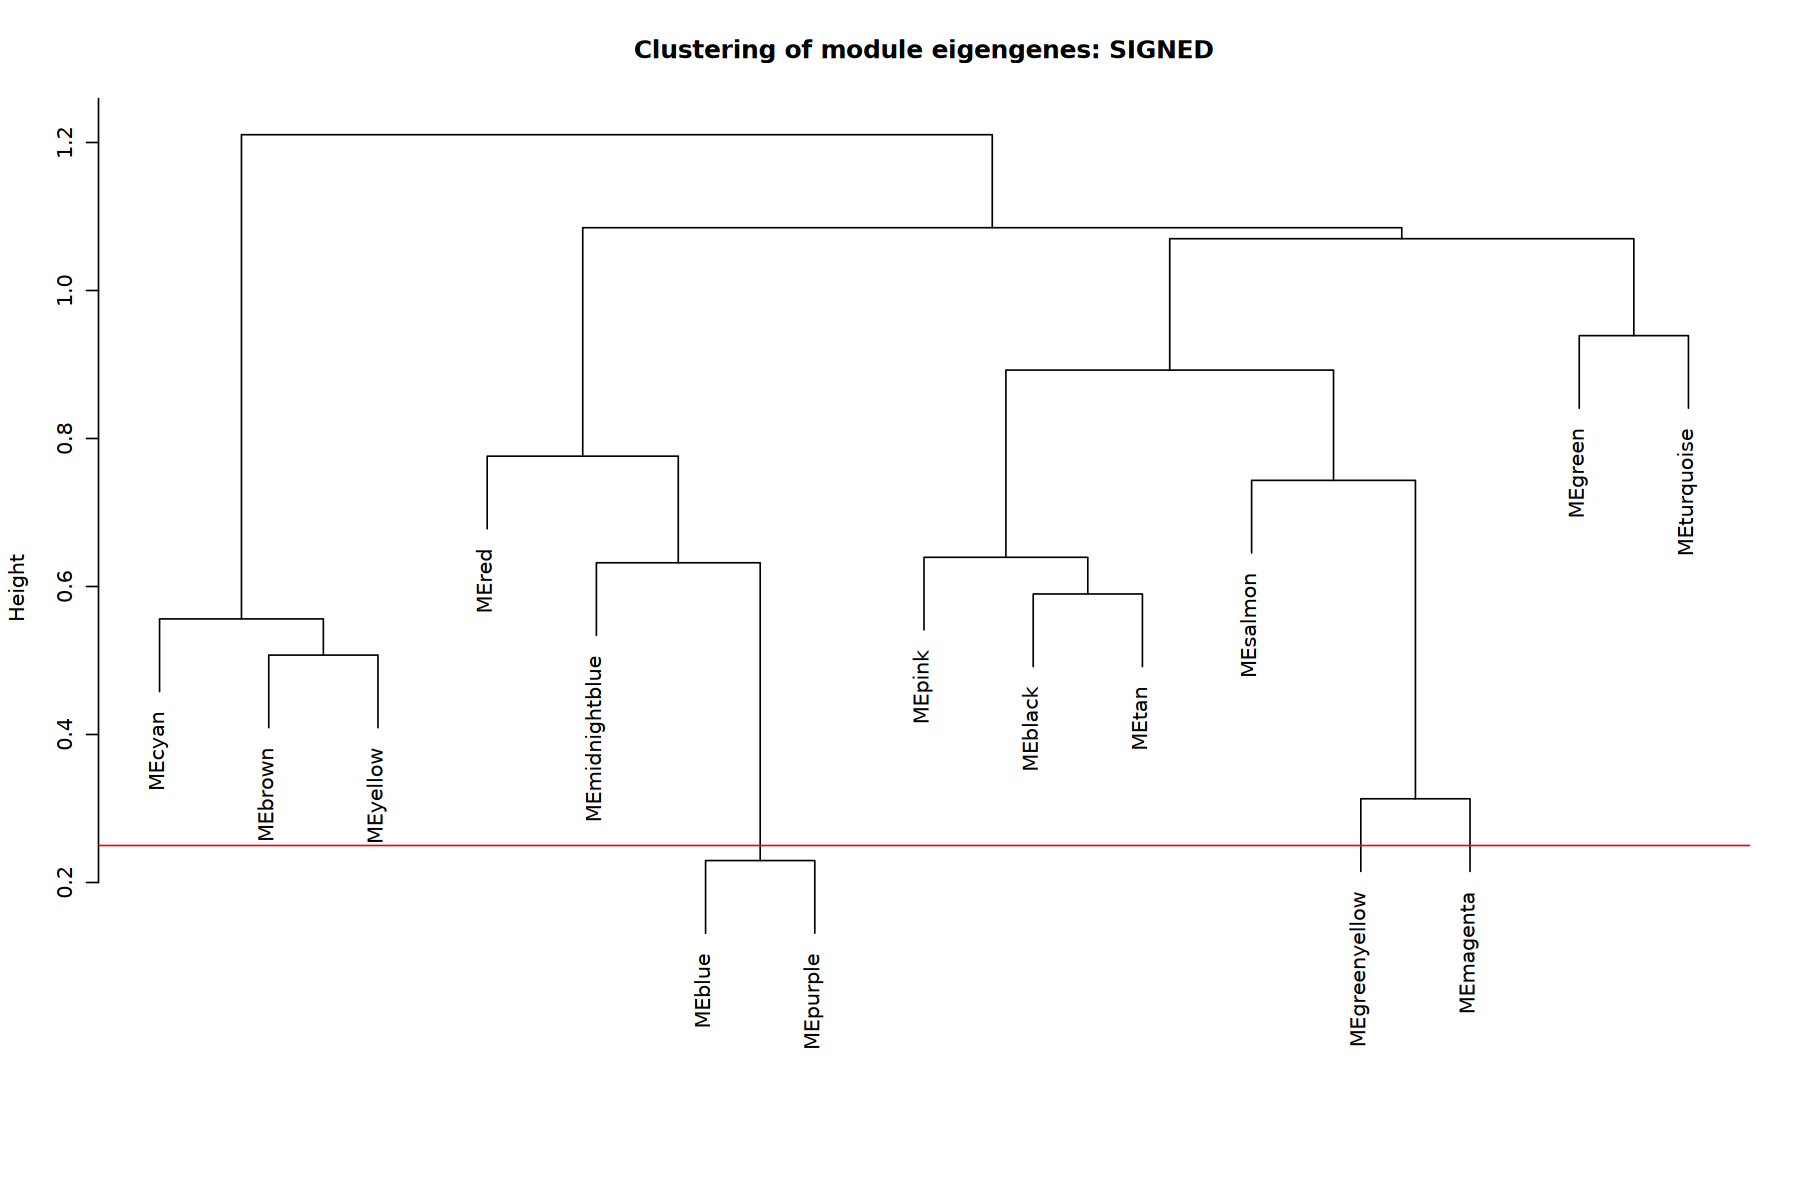

In [23]:
## SIGNED
# Calculate eigengenes
MEList_sign <- moduleEigengenes(dataExpr, colors = dynamicColors_sign)
MEs_sign <- MEList_sign$eigengenes

# Calculate dissimilarity of module eigengenes
MEDiss_sign <- 1-cor(MEs_sign)

# Cluster module eigengenes
METree_sign <- hclust(as.dist(MEDiss_sign), method = "average")

# Plot the result

# height cutoff of 0.25 - corresponds to a correlation of 0.75 to merge
MEDissThres <- 0.25

# Plot the cut line into the dendrogram
plot(METree_sign, main = "Clustering of module eigengenes: SIGNED", xlab = "", sub = "")
abline(h=MEDissThres, col = "red")

any branch with more than 75% correlation are related and will be merged - so blue and purple modules will be merged

 mergeCloseModules: Merging modules whose distance is less than 0.25
   multiSetMEs: Calculating module MEs.
     Working on set 1 ...
     moduleEigengenes: Calculating 15 module eigengenes in given set.
   multiSetMEs: Calculating module MEs.
     Working on set 1 ...
     moduleEigengenes: Calculating 14 module eigengenes in given set.
   Calculating new MEs...
   multiSetMEs: Calculating module MEs.
     Working on set 1 ...
     moduleEigengenes: Calculating 14 module eigengenes in given set.


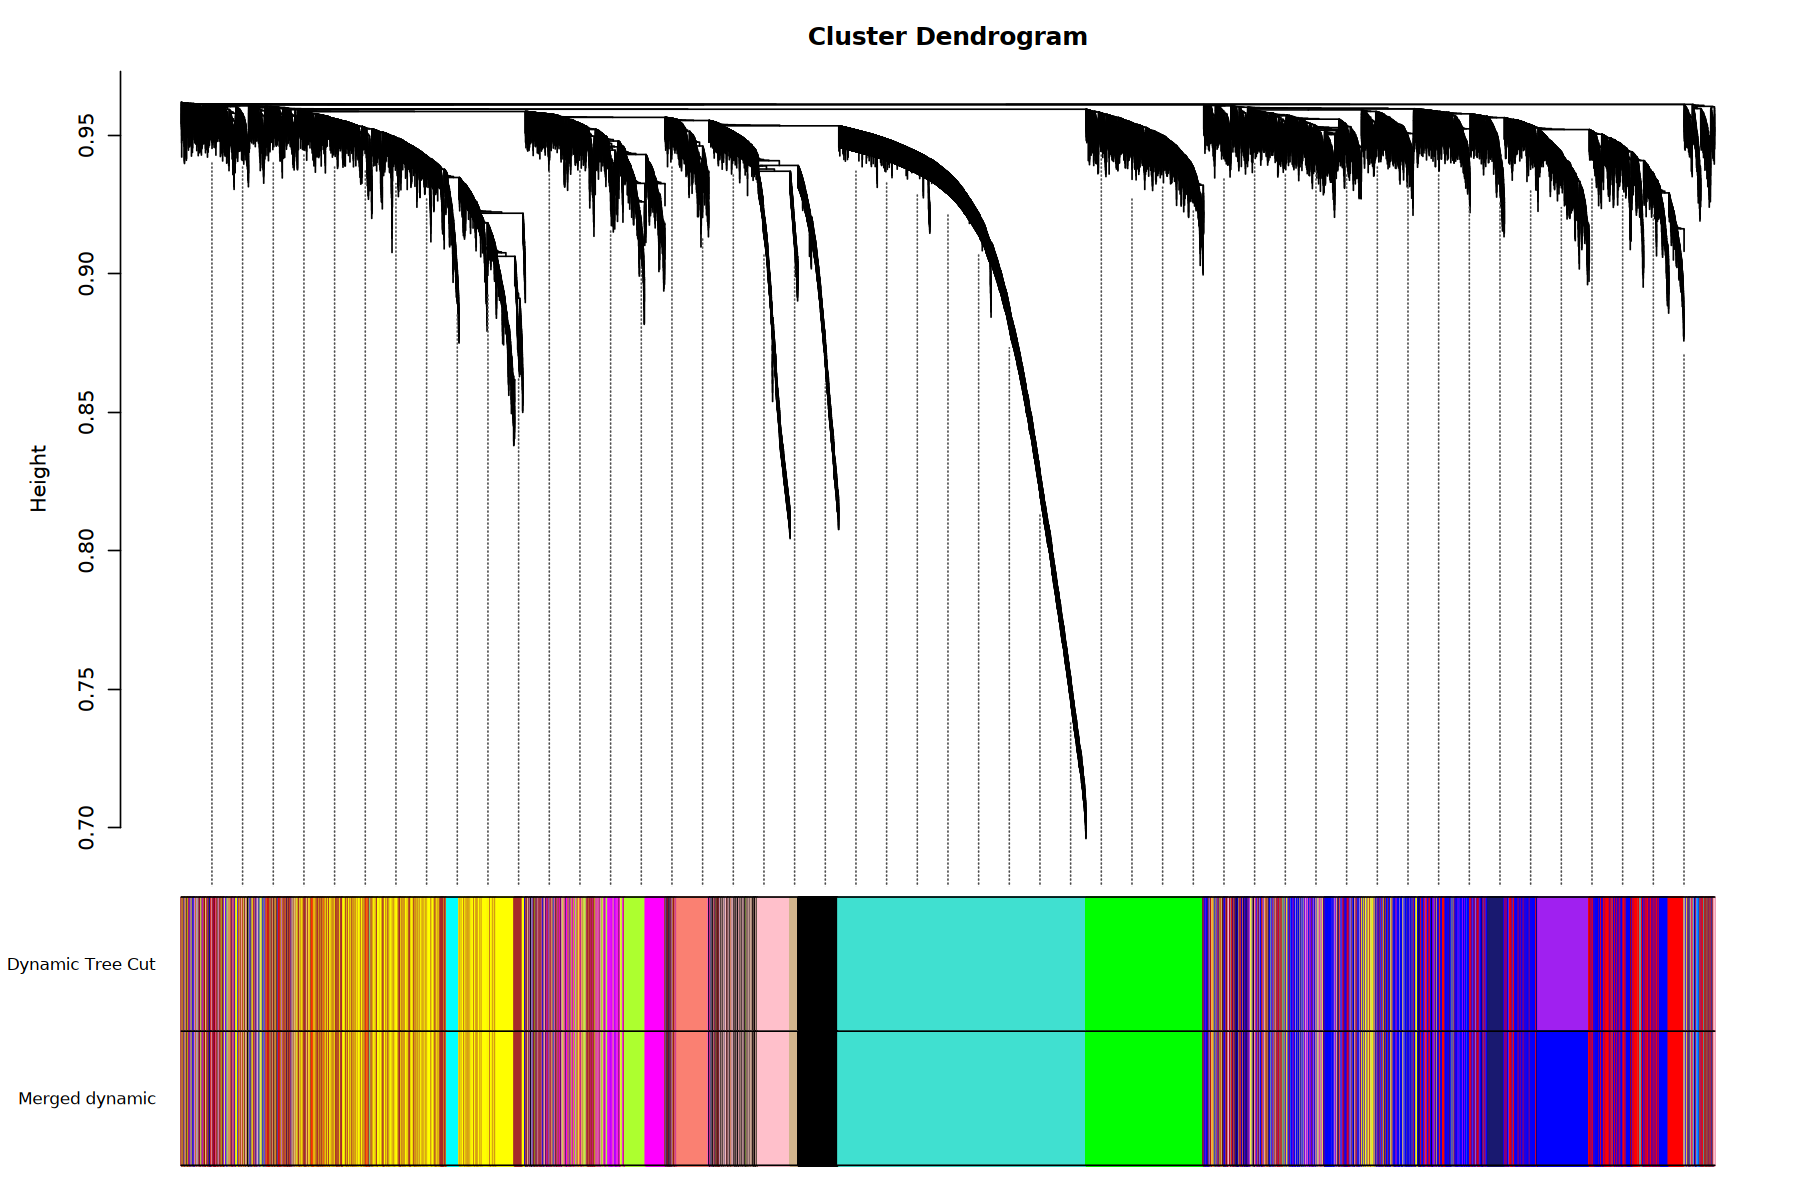

In [24]:
## SIGNED
# Call an automatic merging function
merge_sign <- mergeCloseModules(dataExpr, dynamicColors_sign, cutHeight = MEDissThres, verbose = 3)

# The merged module colors
mergedColors_sign <- merge_sign$colors

# Eigengenes of the new merged modules:
mergedMEs_sign <- merge_sign$newMEs

# plot merged module colors
plotDendroAndColors(geneTree_sign, cbind(dynamicColors_sign, mergedColors_sign), 
                    c("Dynamic Tree Cut", "Merged dynamic"),
                    dendroLabels = FALSE, hang = 0.03,
                    addGuide = TRUE, guideHang = 0.05)

## 3. quantifying module-trait associations
identify modules that are significantly associated with treatment exposures or measured traits (like growth)

### A. read in and format metadata

both treatment metadata and growth data

In [25]:
# read in phase info
dataMeta <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/metaData/sample_metaData.csv')

# keep only samples seen in dataExpr
dataMeta <- dataMeta[dataMeta$Sample %in% rownames(dataExpr),]

# create combo trtmt column
dataMeta$combo_trtmt <- paste0(dataMeta$Phase1_treatment, '_', dataMeta$Phase2_treatment)

# check it out
dim(dataMeta)
head(dataMeta)


[1] 93 10

Sample    Phase1_treatment Phase1_temp Phase1_DO Phase1_TankRep
1 B1_B1_O01 both             warm        hypoxic   1             
3 B1_W5_O50 both             warm        hypoxic   1             
4 B2_B5_O51 both             warm        hypoxic   2             
5 B2_C4_O40 both             warm        hypoxic   2             
7 B3_B4_O41 both             warm        hypoxic   3             
8 B3_C3_O30 both             warm        hypoxic   3             
  Phase2_treatment Phase2_temp Phase2_DO Phase2_TankRep combo_trtmt 
1 both             warm        hypoxic   1              both_both   
3 warm             warm        normoxic  5              both_warm   
4 both             warm        hypoxic   5              both_both   
5 control          ambient     normoxic  4              both_control
7 both             warm        hypoxic   4              both_both   
8 control          ambient     normoxic  3              both_control

values have to be numerical, so going to create a code for my treatments:

#### phase 1 and 2 treatments
1. control
2. warm
3. hypoxic
4. both

#### temperature
1. ambient
2. warm

#### dissolved oxygen
1. normoxic
2. hypoxic

In [26]:
# set factors
dataMeta$Phase1_treatment <- factor(dataMeta$Phase1_treatment, c('control', 'warm', 'hypoxic', 'both'))
dataMeta$Phase1_temp <- factor(dataMeta$Phase1_temp, c('ambient', 'warm'))
dataMeta$Phase1_DO <- factor(dataMeta$Phase1_DO, c('normoxic', 'hypoxic'))

dataMeta$Phase2_treatment <- factor(dataMeta$Phase2_treatment, c('control', 'warm', 'hypoxic', 'both'))
dataMeta$Phase2_temp <- factor(dataMeta$Phase2_temp, c('ambient', 'warm'))
dataMeta$Phase2_DO <- factor(dataMeta$Phase2_DO, c('normoxic', 'hypoxic'))

# convert categorical to numerical code for treatment info
### PHASE 1
dataMeta$P1_trtmt_code <- as.numeric(factor(dataMeta$Phase1_treatment))
dataMeta$P1_temp_code <- as.numeric(factor(dataMeta$Phase1_temp))
dataMeta$P1_DO_code <- as.numeric(factor(dataMeta$Phase1_DO))
### PHASE 2
dataMeta$P2_trtmt_code <- as.numeric(factor(dataMeta$Phase2_treatment))
dataMeta$P2_temp_code <- as.numeric(factor(dataMeta$Phase2_temp))
dataMeta$P2_DO_code <- as.numeric(factor(dataMeta$Phase2_DO))

# select only columns needed
metaData <- dataMeta[,-c(2:10)]

# set sample names as rownames
rownames(metaData) <- metaData$Sample
metaData <- metaData %>% select(-Sample)

head(metaData)


P1_trtmt_code P1_temp_code P1_DO_code P2_trtmt_code P2_temp_code
B1_B1_O01 4             2            2          4             2           
B1_W5_O50 4             2            2          2             2           
B2_B5_O51 4             2            2          4             2           
B2_C4_O40 4             2            2          1             1           
B3_B4_O41 4             2            2          4             2           
B3_C3_O30 4             2            2          1             1           
          P2_DO_code
B1_B1_O01 2         
B1_W5_O50 1         
B2_B5_O51 2         
B2_C4_O40 1         
B3_B4_O41 2         
B3_C3_O30 1

could also add growth data to this:

In [27]:
p2_growth <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/metaData/growth_phase2.1_weights.csv')

# add leading zeros to single digit tag num
p2_growth$Tag_num <- sprintf("%02d", p2_growth$Tag_num)

# make sample names same as my convention
p1_str <- str_sub(p2_growth$Phase_1_treat, 1, 1)
p2_str <- str_sub(p2_growth$Phase_2_treat, 1, 1)
p2_growth$Sample <- paste0(p1_str, p2_growth$Phase_1_rep, '_', p2_str, p2_growth$Phase_2_rep, '_', p2_growth$Tag_color, p2_growth$Tag_num)
head(p2_growth$Sample)

# pull out growth data for matching samples
p2_growth.df <- p2_growth[p2_growth$Sample %in% rownames(metaData), ]

# check it out
dim(p2_growth.df) # 91 samples
dim(metaData) # 93 samples

[1] "B1_B1_O01" "B1_B1_O02" "B1_B2_O13" "B1_B2_O14" "B1_B3_O25" "B1_B3_O26"

[1] 91 33

[1] 93  6

In [28]:
metaData[!rownames(metaData) %in% p2_growth.df$Sample,]

P1_trtmt_code P1_temp_code P1_DO_code P2_trtmt_code P2_temp_code
C_W5_W52  1             1            1          2             2           
W2_B2_G04 2             2            1          4             2           
          P2_DO_code
C_W5_W52  1         
W2_B2_G04 2

In [29]:
head(dataMeta)

Sample    Phase1_treatment Phase1_temp Phase1_DO Phase1_TankRep
1 B1_B1_O01 both             warm        hypoxic   1             
3 B1_W5_O50 both             warm        hypoxic   1             
4 B2_B5_O51 both             warm        hypoxic   2             
5 B2_C4_O40 both             warm        hypoxic   2             
7 B3_B4_O41 both             warm        hypoxic   3             
8 B3_C3_O30 both             warm        hypoxic   3             
  Phase2_treatment Phase2_temp Phase2_DO Phase2_TankRep combo_trtmt 
1 both             warm        hypoxic   1              both_both   
3 warm             warm        normoxic  5              both_warm   
4 both             warm        hypoxic   5              both_both   
5 control          ambient     normoxic  4              both_control
7 both             warm        hypoxic   4              both_both   
8 control          ambient     normoxic  3              both_control
  P1_trtmt_code P1_temp_code P1_DO_code P2_trtmt_code P2_temp_code P2_DO_code
1 4             2            2          4             2            2         
3 4             2            2          2             2            1         
4 4             2            2          4             2            2         
5 4             2            2          1             1            1         
7 4             2            2          4             2            2         
8 4             2            2          1             1            1

i think C_W5_W52 should be **C2_W5_W52** actually and W2_B2_G04 should be **W2_B1_G04**

changing the names in both metaData and dataExpr 

In [30]:
rownames(dataMeta) <- dataMeta$Sample

# add missing rep number to sample name
rownames(dataExpr)[rownames(dataExpr) == 'C_W5_W52'] <- 'C2_W5_W52'
rownames(metaData)[rownames(metaData) == 'C_W5_W52'] <- 'C2_W5_W52'
rownames(dataMeta)[rownames(dataMeta) == 'C_W5_W52'] <- 'C2_W5_W52'

# fix wrong rep number to sample name
rownames(dataExpr)[rownames(dataExpr) == 'W2_B2_G04'] <- 'W2_B1_G04'
rownames(metaData)[rownames(metaData) == 'W2_B2_G04'] <- 'W2_B1_G04'
rownames(dataMeta)[rownames(dataMeta) == 'W2_B2_G04'] <- 'W2_B1_G04'

pulling out the growth data now - should be the same number of samples ...

In [31]:
# pull out growth data for matching samples
p2_growth.df2 <- p2_growth[p2_growth$Sample %in% rownames(metaData), ]

# check it out
dim(p2_growth.df2) # 93 samples
dim(metaData) # 93 samples

[1] 93 33

[1] 93  6

so all good now with matching sample names!

now pulling out only the growth columns and merging with the other meta data df 

In [32]:
# select growth columns
p2_growth.df2 <- p2_growth.df2 %>%
select(Sample, Actual_shell_growth_mg, Actual_tissue_growth_mg, Ratio_tissue_shell_mg)

# sample is the rowname
rownames(p2_growth.df2) <- p2_growth.df2$Sample
p2_growth.df2 <- p2_growth.df2 %>% select(-Sample)


head(p2_growth.df2)

Actual_shell_growth_mg Actual_tissue_growth_mg Ratio_tissue_shell_mg
B1_B1_O01 210.2755               120.72448               0.574125224          
B1_W5_O50 315.8883                85.61170               0.271018901          
B2_B5_O51 114.3215                44.47852               0.389065292          
B2_C4_O40 164.9903                55.10972               0.33401798           
B3_B4_O41 197.9250               116.17500               0.586964759          
B3_C3_O30 316.0466               241.35336               0.763663743

In [33]:
# merge dfs
metaData_merge <- merge(p2_growth.df2, metaData, by = 'row.names')

# set samples as rownames
metaData_merge <- metaData_merge %>% 
column_to_rownames(var = 'Row.names')

dim(metaData_merge)
head(metaData_merge)

[1] 93  9

Actual_shell_growth_mg Actual_tissue_growth_mg Ratio_tissue_shell_mg
B1_B1_O01 210.2755               120.72448               0.574125224          
B1_W5_O50 315.8883                85.61170               0.271018901          
B2_B5_O51 114.3215                44.47852               0.389065292          
B2_C4_O40 164.9903                55.10972               0.33401798           
B3_B4_O41 197.9250               116.17500               0.586964759          
B3_C3_O30 316.0466               241.35336               0.763663743          
          P1_trtmt_code P1_temp_code P1_DO_code P2_trtmt_code P2_temp_code
B1_B1_O01 4             2            2          4             2           
B1_W5_O50 4             2            2          2             2           
B2_B5_O51 4             2            2          4             2           
B2_C4_O40 4             2            2          1             1           
B3_B4_O41 4             2            2          4             2           
B3_C3_O30 4             2            2          1             1           
          P2_DO_code
B1_B1_O01 2         
B1_W5_O50 1         
B2_B5_O51 2         
B2_C4_O40 1         
B3_B4_O41 2         
B3_C3_O30 1

In [34]:
# define # of genes and samples
nSamples <- nrow(dataExpr) # 93 samples
nGenes <- ncol(dataExpr) # 26,547 genes

eigengene ~ summary profile of the module

now can correlate eigengenes with external traits and look for most significant associations

In [35]:
# reorder columns
metaData_merge <- metaData_merge %>%
select(Actual_shell_growth_mg, Actual_tissue_growth_mg, Ratio_tissue_shell_mg, P1_trtmt_code, P2_trtmt_code, P1_temp_code, P2_temp_code, P1_DO_code, P2_DO_code)

dim(metaData_merge)
head(metaData_merge)

[1] 93  9

Actual_shell_growth_mg Actual_tissue_growth_mg Ratio_tissue_shell_mg
B1_B1_O01 210.2755               120.72448               0.574125224          
B1_W5_O50 315.8883                85.61170               0.271018901          
B2_B5_O51 114.3215                44.47852               0.389065292          
B2_C4_O40 164.9903                55.10972               0.33401798           
B3_B4_O41 197.9250               116.17500               0.586964759          
B3_C3_O30 316.0466               241.35336               0.763663743          
          P1_trtmt_code P2_trtmt_code P1_temp_code P2_temp_code P1_DO_code
B1_B1_O01 4             4             2            2            2         
B1_W5_O50 4             2             2            2            2         
B2_B5_O51 4             4             2            2            2         
B2_C4_O40 4             1             2            1            2         
B3_B4_O41 4             4             2            2            2         
B3_C3_O30 4             1             2            1            2         
          P2_DO_code
B1_B1_O01 2         
B1_W5_O50 1         
B2_B5_O51 2         
B2_C4_O40 1         
B3_B4_O41 2         
B3_C3_O30 1

growth meaning the growth from the beginning of phase 2 to the end of phase 2 - we do not have data on these oysters' growth before and after phase 1. The ratio of tissue to shell growth is a proxy for fitness (more tissue = investing in reproduction, more shell = investing in defense)

In [36]:
# Recalculate MEs (module eigengenes) with color labels

MEs0 <- moduleEigengenes(dataExpr, mergedColors_sign)$eigengenes # create module eigengenes

MEs <- orderMEs(MEs0) # order so more similar modules are closer together

moduleTraitCor <- cor(MEs, metaData_merge, use = "p") # correlate with traits - using Pearson correlations

moduleTraitPvalue <- corPvalueStudent(moduleTraitCor, nSamples) # compute p-values - uses student's t-distribution

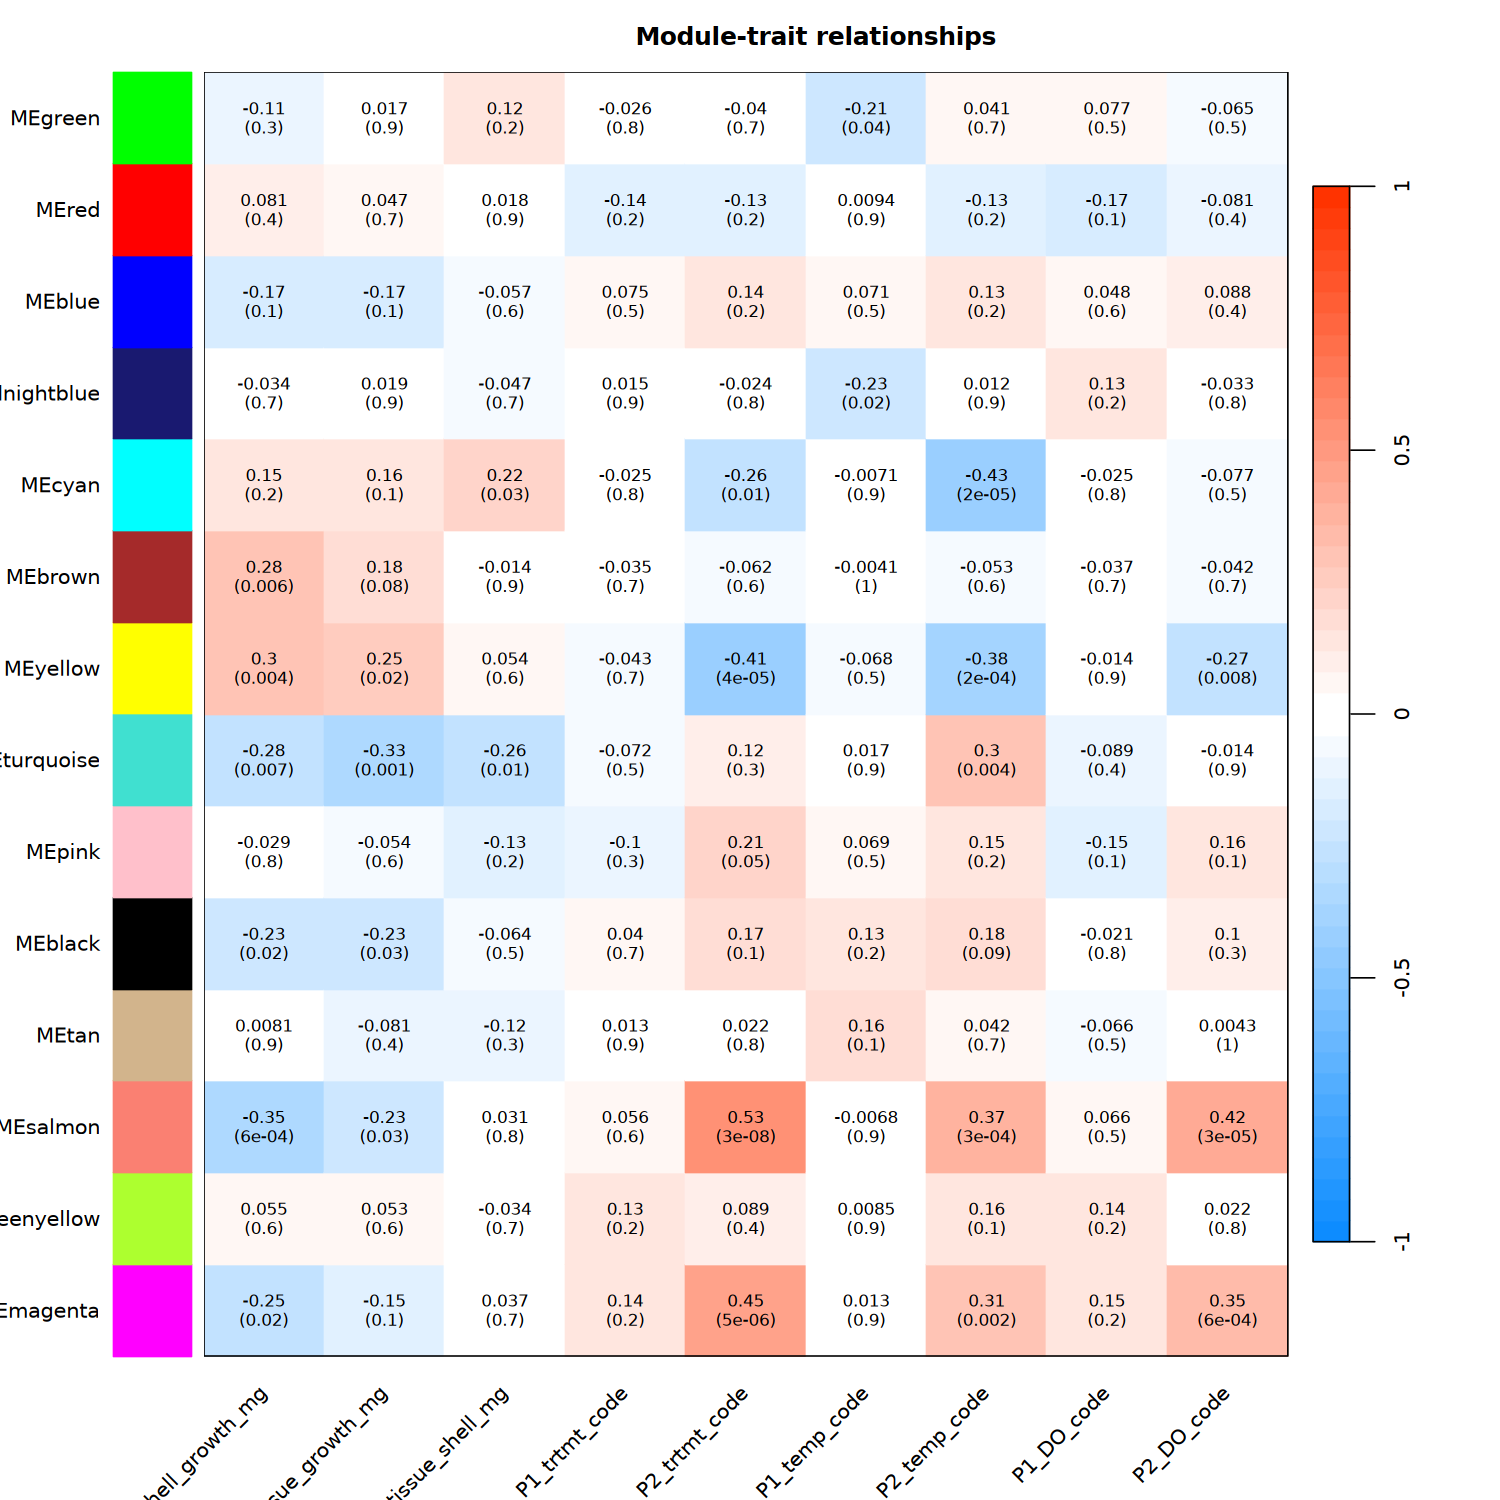

In [37]:
options(repr.plot.width = 12.5, repr.plot.height = 12.5)

# Will display correlations and their p-values
textMatrix = paste(signif(moduleTraitCor, 2), "\n(",
signif(moduleTraitPvalue, 1), ")", sep = "");
dim(textMatrix) = dim(moduleTraitCor)
par(mar = c(6, 8.5, 3, 3))

# Display the correlation values within a heatmap plot
labeledHeatmap(Matrix = moduleTraitCor, 
               xLabels = names(metaData_merge), 
               yLabels = names(MEs),
               ySymbols = names(MEs),
               colorLabels = FALSE,
               colors = blueWhiteRed(50),
               textMatrix = textMatrix,
               setStdMargins = FALSE,
               cex.text = 0.8,
               zlim = c(-1,1),
               main = paste("Module-trait relationships"))

each row corresponds to a module eigengene, column to a treatment

each cell contains the corresponding correlation and p-value and the table is colored by correlation (in my case, I've assigned numerical codes to categorical treatments, with the control/normoxic/ambient treatment always being 1)

red cells indicate positive correlation, blue cells a negative correlation - looking for dark cells with significant pvalues to identify module of interest

**specifically looking for...**:
- modules with opposing relationships between phase 1 and phase 2 (whether that's DO, temp, or treatment altogether; can also be growth as in red for tissue but blue for shell)
- modules with significant relationships (number within the paratheses)

**observations**:
- none of the modules have a significant relationship with p1_treatment or p1_DO, which makes sense since these samples were taken after p2 and we expect most GE to be short-term
    - there are 5 modules with a sig. relationship with p2_treatment (three red and two blue)
- there are 3 modules with a sig. relationship with a DO treatment (cols 8 and 9) and 7 modules with a significant relationship with a temp treatment (cols 6 and 7)
- there are a few modules with sig. relationships with tissue/shell growth, and they're in the same direction for tissue and shell
    - only 2 modules with a sig. relationship with the ratio of tissue to shell growth, one pos. and one neg.

based on this, **potentially interesting modules include**:
- for **P2_trtmt_code**: MEsalmon, MEmagent, MEyellow
- for **Actual_shell_growth_mg**: MEbrown, MEsalmon, MEturquoise
- for **Actual_tissue_growth_mg**: MEturquoise
- for **P1_Temp_code**: MEmidnightblue
- for **P2_Temp_code**: MEyellow, MEsalmon, MEcyan
- for **P2_DO_code**: MEyellow, MEsalmon, MEmagenta



In [48]:
# write csv to save the module eigengenes
# write.csv(MEs, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/wgcna/p2.wgcna_ModuleEigengenes.csv')

similar heatmap, but just with diff package:

Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'Module–trait relationships' in 'mbcsToSbcs': dot substituted for <e2>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'Module–trait relationships' in 'mbcsToSbcs': dot substituted for <80>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'Module–trait relationships' in 'mbcsToSbcs': dot substituted for <93>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'Module–trait relationships' in 'mbcsToSbcs': dot substituted for <e2>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'Module–trait relationships' in 'mbcsToSbcs': dot substituted for <80>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '

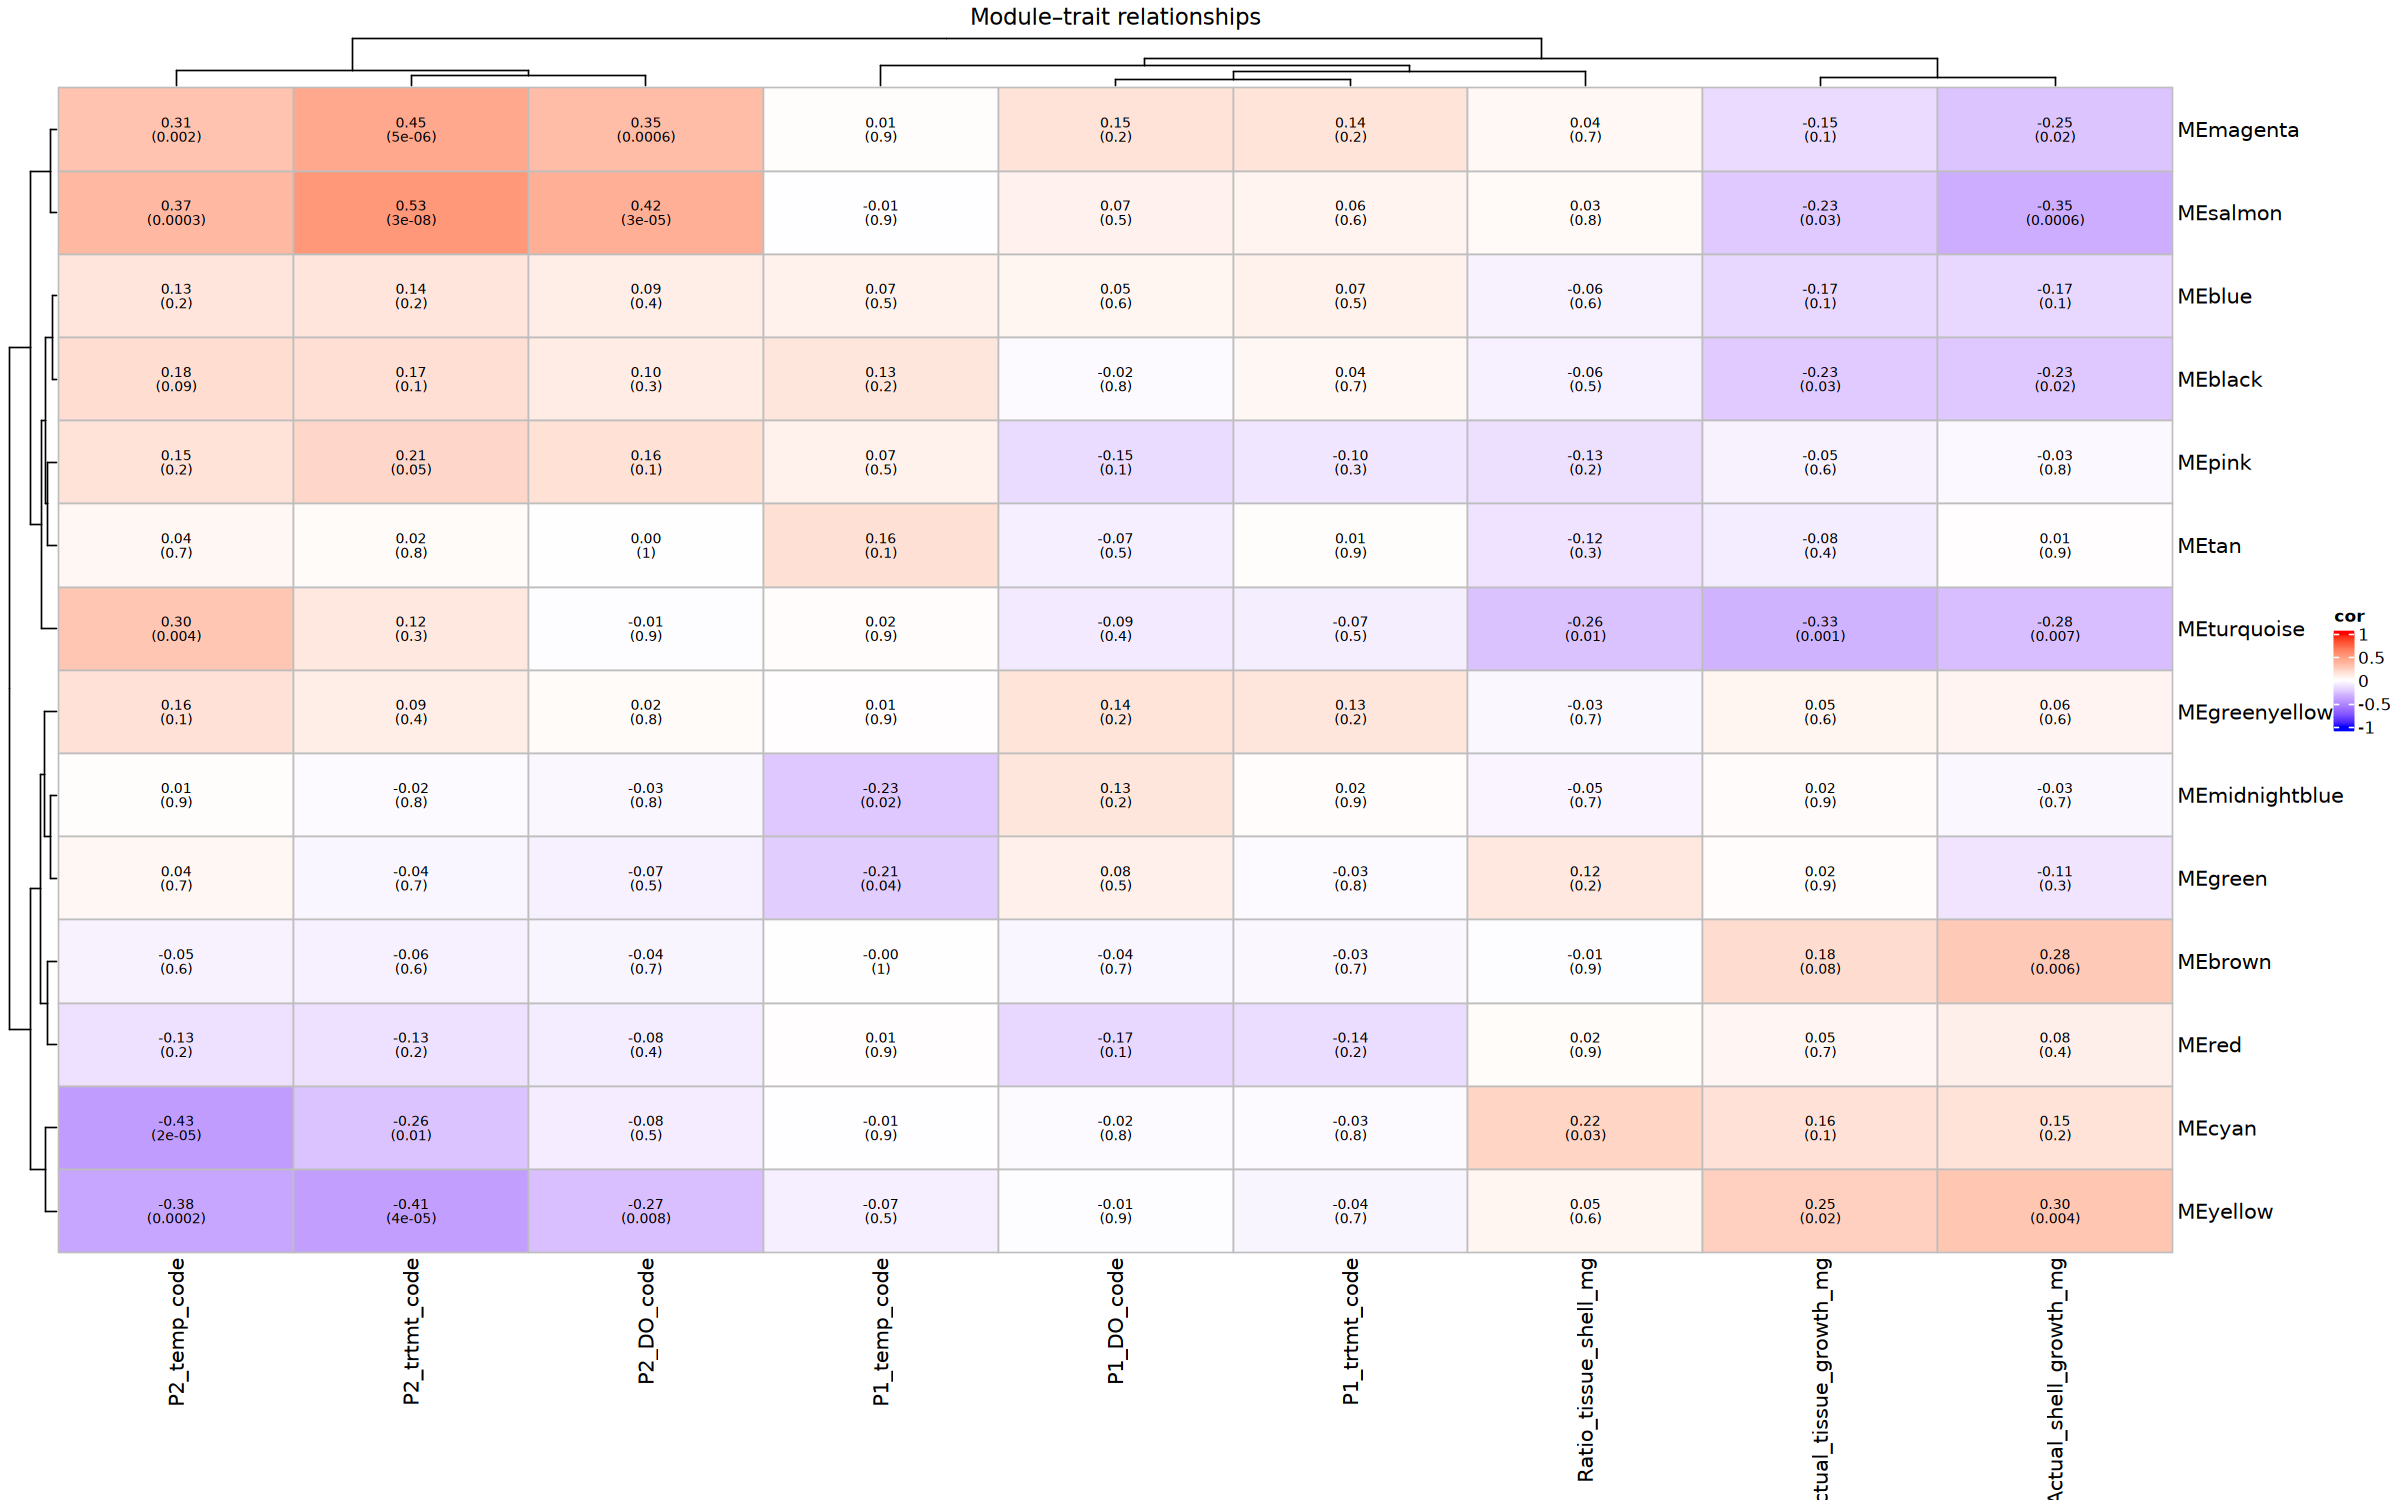

In [64]:
# create matrix
p2.treatment.text <- as.matrix(signif(moduleTraitPvalue, 3))
# clustering
pa = cluster::pam(p2.treatment.text, k = 3)
# define color scale
col_fun = colorRamp2(c(-0.5, 0, 0.5), c("blue", "white", "red"))

# complex heatmap
Heatmap(
  moduleTraitCor,                       # same matrix as labeledHeatmap
  name = "cor",
  col = colorRamp2(c(-1, 0, 1), c("blue", "white", "red")),
  rect_gp = gpar(col = "grey", lwd = 1),
  column_title = "Module–trait relationships",
  cell_fun = function(j, i, x, y, width, height, fill) {
    grid.text(sprintf("%.2f\n(%.1g)",
                      moduleTraitCor[i, j],
                      moduleTraitPvalue[i, j]),
              x, y, gp = gpar(fontsize = 8))
  }
)


so while there are significant associations of modules and traits, none of them have super strong correlations (max 0.5)

#### module-trait relationship splitting phase 1 and 2 treatments

## MEs boxplots by treatment group

inspo for this comes from [Gurr's code](https://github.com/SamGurr/Pgenerosa_OA_TagSeq/blob/main/TagSeq/Analysis/Scripts/Day21_WGCNA_all.R) - plotting every module's ME (module eigengene) for each treatment combination - this will allow me to take a closer look at the relationship between modules and phase 1 and 2 treatments

first - need to make sure the sample name mixup from above carries down here

In [38]:
# add missing rep number to sample name
rownames(metaData_merge)[rownames(metaData_merge) == 'C_W5_W52'] <- 'C2_W5_W52'
rownames(dataMeta)[rownames(dataMeta) == 'C_W5_W52'] <- 'C2_W5_W52'

# fix wrong rep number to sample name
rownames(metaData_merge)[rownames(metaData_merge) == 'W2_B2_G04'] <- 'W2_B1_G04'
rownames(dataMeta)[rownames(dataMeta) == 'W2_B2_G04'] <- 'W2_B1_G04'

# update sample column info
metaData_merge$Sample <- rownames(metaData_merge)
dataMeta$Sample <- rownames(dataMeta)

then create df to plot boxplots - want the metadata and module eigengene info in long format

In [39]:
# Create ME table
MEs_df <- as.data.frame(MEs)
MEs_df$Sample <- rownames(MEs_df)

# format metadata and merge with MEs
dataMeta2 <- dataMeta[,1:10]
meta_merge <- merge(dataMeta2, metaData_merge, by = 'Sample')
dim(meta_merge)

# merge MEs and metadata
MEsPlotting <- merge(MEs_df, meta_merge, by = 'Sample')

# Melt to long format
MEsPlotting_melt <- reshape2::melt(
  MEsPlotting,
  id.vars = c("Sample",
              "Phase1_treatment",
              "Phase1_temp",
              "Phase1_DO",
              "Phase1_TankRep",
              "Phase2_treatment",
              "Phase2_temp",
              "Phase2_DO",
              "Phase2_TankRep",
              "combo_trtmt",
              'Actual_shell_growth_mg',
              'Actual_tissue_growth_mg', 
              'Ratio_tissue_shell_mg'
             ),
  variable.name = "Module",
  value.name = "Eigengene"
)

MEsPlotting_melt <- MEsPlotting_melt %>%
filter(!grepl('code', Module)) # remove treatment code rows

head(MEsPlotting_melt)

[1] 93 19

Sample    Phase1_treatment Phase1_temp Phase1_DO Phase1_TankRep
1 B1_B1_O01 both             warm        hypoxic   1             
2 B1_W5_O50 both             warm        hypoxic   1             
3 B2_B5_O51 both             warm        hypoxic   2             
4 B2_C4_O40 both             warm        hypoxic   2             
5 B3_B4_O41 both             warm        hypoxic   3             
6 B3_C3_O30 both             warm        hypoxic   3             
  Phase2_treatment Phase2_temp Phase2_DO Phase2_TankRep combo_trtmt 
1 both             warm        hypoxic   1              both_both   
2 warm             warm        normoxic  5              both_warm   
3 both             warm        hypoxic   5              both_both   
4 control          ambient     normoxic  4              both_control
5 both             warm        hypoxic   4              both_both   
6 control          ambient     normoxic  3              both_control
  Actual_shell_growth_mg Actual_tissue_growth_mg Ratio_tissue_shell_mg Module 
1 210.2755               120.72448               0.574125224           MEgreen
2 315.8883                85.61170               0.271018901           MEgreen
3 114.3215                44.47852               0.389065292           MEgreen
4 164.9903                55.10972               0.33401798            MEgreen
5 197.9250               116.17500               0.586964759           MEgreen
6 316.0466               241.35336               0.763663743           MEgreen
  Eigengene  
1 -0.07267705
2  0.11259458
3 -0.08984971
4  0.10140997
5  0.09981873
6  0.13421227

In [51]:
# save metadata in case I skip code above
# write.csv(MEsPlotting_melt[,1:13], '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/wgcna/p2.wgcna_metadata.csv')

make boxplot!

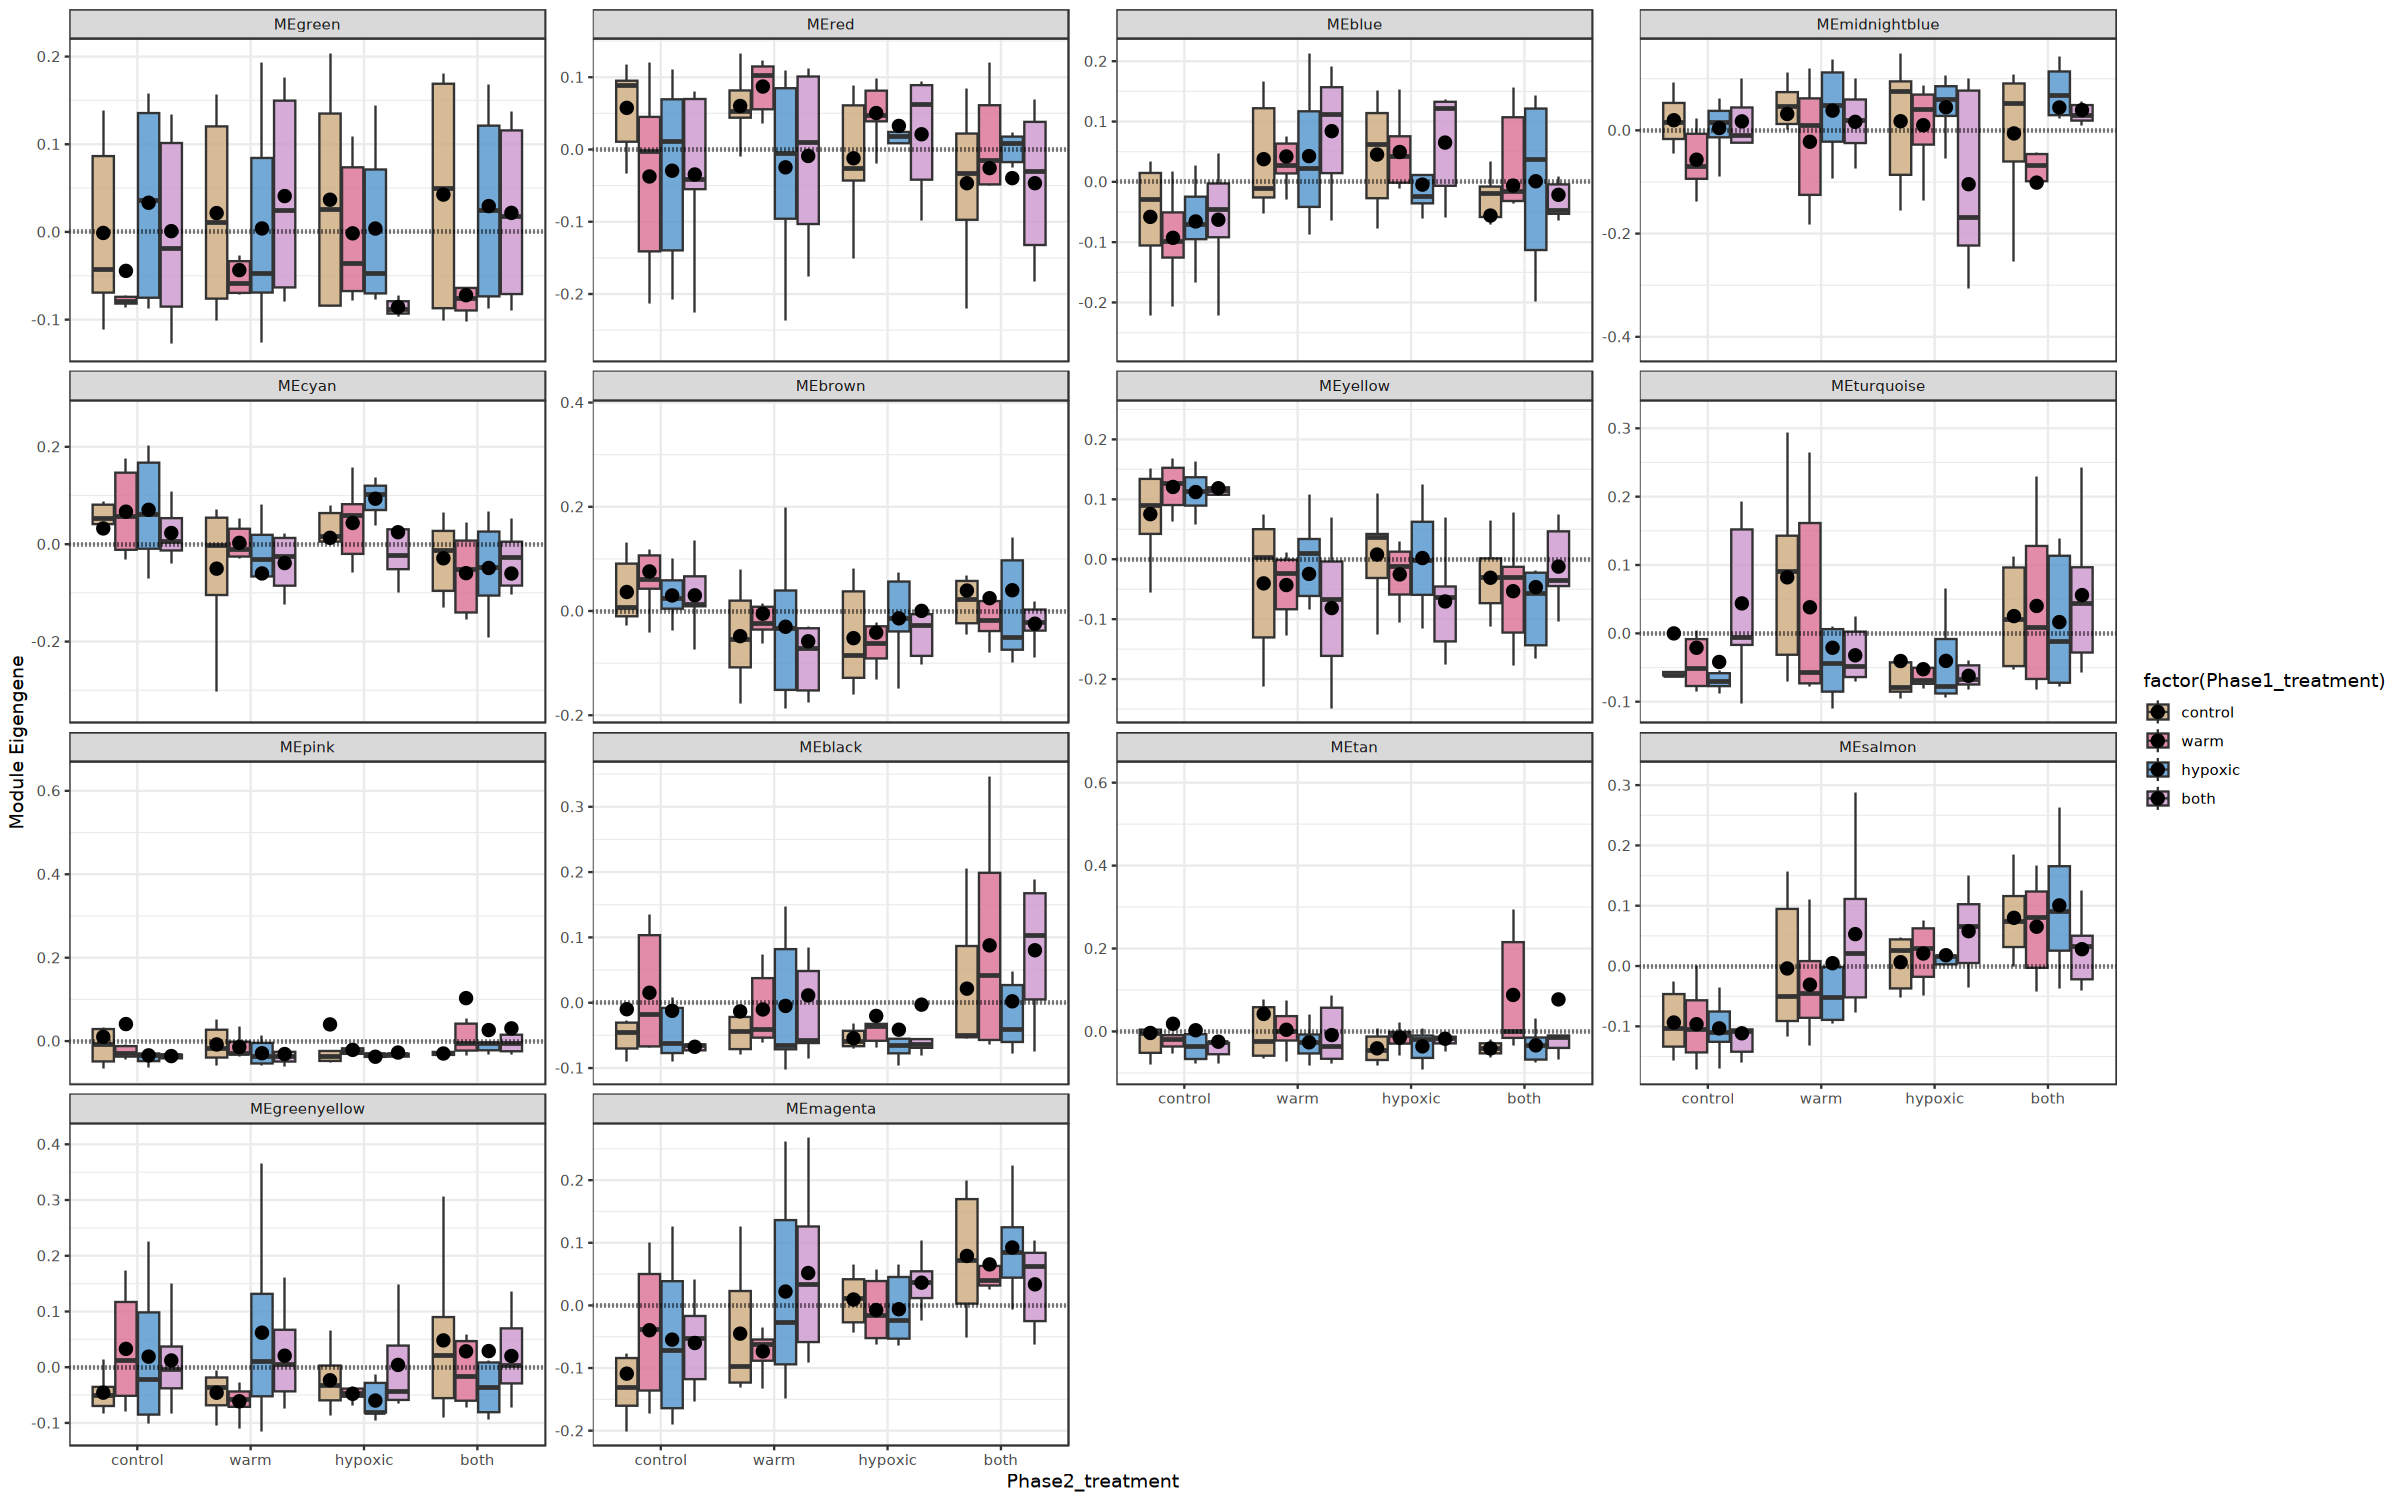

In [40]:
options(repr.plot.width = 20, repr.plot.hieght = 20)

ggplot(MEsPlotting_melt,
       aes(x = Phase2_treatment,
           y = Eigengene,
           fill = factor(Phase1_treatment))) +
  
  geom_boxplot(position = position_dodge(0.8),
               outlier.shape = NA,
               alpha = 0.8) +

scale_fill_manual(values = c("hypoxic" = "steelblue3", 
                             "warm" = "palevioletred", 
                             "control" = "burlywood3", 
                             "both" = "plum3")) +
  
  stat_summary(fun = mean,
               geom = "point",
               color = "black",
               position = position_dodge(0.8),
               size = 3) +
  
  geom_hline(yintercept = 0,
             linetype = "dotted",
             linewidth = 1) +
  
  ylab("Module Eigengene") +
  theme_bw() +
  facet_wrap(~ Module, scales = "free_y")


x-axis: module eigengene - representative gene expression profile for that module

dotted line denotes no expression, pos = higher expr and neg = lower expr

## Identify hub genes
hub genes = gene with the most connectivity within its module 

In [59]:
chooseTopHubInEachModule(dataExpr, # vst expr. matrix
                         mergedColors_sign, # from dendogram above
                         omitColors = "grey", # grey module = genes not assigned to any module
                         power = 5, 
                         type = "signed")

black           blue          brown           cyan          green 
"LOC111121348" "LOC111108426" "LOC111133766" "LOC111136057" "LOC111102039" 
   greenyellow        magenta   midnightblue           pink            red 
"LOC111129175" "LOC111119101" "LOC111130108" "LOC111104655" "LOC111101170" 
        salmon            tan      turquoise         yellow 
"LOC111119855" "LOC111122605" "LOC111114430" "LOC111135316"

from the heatmap and boxplots above, the modules I'm most interested is:
- **green**: p1_temp
    - hub gene: *LOC111102039* - E3 ubiquitin-protein ligase, but withdrawn by NCBI Jan 2026
- **yellow**: p2_trtmt, p2_DO, p2_temp, tissue and shell growth
    - hub gene: *LOC111135316* - enoyl-CoA delta isomerase 2-like
- **salmon**: p2_trtmt, p2_DO, p2_temp, tissue and shell growth
    - hub gene: *LOC111119855* - forkhead box protein K1-like
- **magenta**: p2_trtmt, p2_DO, p2_temp, shell growth
    - hub gene: *LOC111119101* - putative E3 ubiquitin-protein ligase UNKL

## Gene significance (GS) and module membership (MM)
both are critical metrics for identifying hub genes within modules that are associated with specific treatment/traits
- GS = correlates gene expression with treatment/trait
- MM = how well a gene belongs to a module

basically select a module of interest and validate with GS and MM - combine GS and MM to find genes that are highly connected *and* strongly associated with the treatment/trait

In [41]:
# remove ME before module names
modNames <- substring(names(MEs), 3)
modNames

[1] "green"        "red"          "blue"         "midnightblue" "cyan"        
 [6] "brown"        "yellow"       "turquoise"    "pink"         "black"       
[11] "tan"          "salmon"       "greenyellow"  "magenta"

In [42]:
nGenes = ncol(dataExpr) # number of genes == 26547
nSamples = nrow(dataExpr) # number of samples == 93

In [75]:
# Create dummy variables
# creates columns that are 0/1 for each treatment combo
traitData <- fastDummies::dummy_cols(meta_merge, select_columns = "combo_trtmt", remove_first_dummy = FALSE)

# subset to just these dummy columns
traitMatrix <- traitData[, grep("combo_trtmt_", colnames(traitData))]

head(traitMatrix)

combo_trtmt_both_both combo_trtmt_both_control combo_trtmt_both_hypoxic
1 1                     0                        0                       
2 0                     0                        0                       
3 1                     0                        0                       
4 0                     1                        0                       
5 1                     0                        0                       
6 0                     1                        0                       
  combo_trtmt_both_warm combo_trtmt_control_both combo_trtmt_control_control
1 0                     0                        0                          
2 1                     0                        0                          
3 0                     0                        0                          
4 0                     0                        0                          
5 0                     0                        0                          
6 0                     0                        0                          
  combo_trtmt_control_hypoxic combo_trtmt_control_warm combo_trtmt_hypoxic_both
1 0                           0                        0                       
2 0                           0                        0                       
3 0                           0                        0                       
4 0                           0                        0                       
5 0                           0                        0                       
6 0                           0                        0                       
  combo_trtmt_hypoxic_control combo_trtmt_hypoxic_hypoxic
1 0                           0                          
2 0                           0                          
3 0                           0                          
4 0                           0                          
5 0                           0                          
6 0                           0                          
  combo_trtmt_hypoxic_warm combo_trtmt_warm_both combo_trtmt_warm_control
1 0                        0                     0                       
2 0                        0                     0                       
3 0                        0                     0                       
4 0                        0                     0                       
5 0                        0                     0                       
6 0                        0                     0                       
  combo_trtmt_warm_hypoxic combo_trtmt_warm_warm
1 0                        0                    
2 0                        0                    
3 0                        0                    
4 0                        0                    
5 0                        0                    
6 0                        0

In [77]:
# compute GS
geneTraitSignificance <- as.data.frame(cor(dataExpr, traitMatrix, use = "p"))
GSPvalue <- as.data.frame(corPvalueStudent(as.matrix(geneTraitSignificance), nSamples))

names(geneTraitSignificance) <- paste0("GS.", colnames(traitMatrix))
names(GSPvalue) <- paste0("p.GS.", colnames(traitMatrix))

# keep MM
geneModuleMembership <- as.data.frame(cor(dataExpr, MEs, use = "p"))
MMPvalue <- as.data.frame(corPvalueStudent(as.matrix(geneModuleMembership), nSamples))

modNames <- substring(names(MEs), 3)
names(geneModuleMembership) <- paste0("MM.", modNames)
names(MMPvalue) <- paste0("p.MM.", modNames)

In [86]:
geneNames <- colnames(dataExpr)  # 26,547 gene names
length(geneNames)

[1] 26547

In [137]:
annot <- read.csv('//work/pi_sarah_gignouxwolfsohn_uml_edu/julia_mcdonough_student_uml_edu/ref_files/annotations/geneGO.txt', sep = '\t')
colnames(annot)[1] <- 'Gene'
colnames(annot)[2] <- 'GO.terms'
head(annot)

Gene        
1 LOC111126949
2 LOC111112434
3 LOC111120752
4 LOC111105685
5 LOC111113860
6 LOC111109550
  GO.terms                                                                                                              
1 GO:0005042; GO:0005737; GO:0008233; GO:0016020; GO:0043123; GO:0046330                                                
2 GO:0000981; GO:0003700; GO:0005634; GO:0016607; GO:0043565; GO:0045944                                                
3 GO:0004750; GO:0005829; GO:0005975; GO:0006098; GO:0009052; GO:0042802; GO:0042803; GO:0046872; GO:0070062            
4 GO:0003682; GO:0004518; GO:0005634; GO:0035098; GO:0035102; GO:0040029; GO:0046872                                    
5 GO:0004062; GO:0005737; GO:0006068; GO:0006805; GO:0008146; GO:0009812; GO:0030855; GO:0042403; GO:0050427; GO:0051923
6 GO:0004062; GO:0005737; GO:0005764; GO:0008146; GO:0051923

In [141]:
colnames(geneInfo)

[1] "Gene"                             "GO.terms"                        
 [3] "moduleColor"                      "MM.green"                        
 [5] "MM.red"                           "MM.blue"                         
 [7] "MM.midnightblue"                  "MM.cyan"                         
 [9] "MM.brown"                         "MM.yellow"                       
[11] "MM.turquoise"                     "MM.pink"                         
[13] "MM.black"                         "MM.tan"                          
[15] "MM.salmon"                        "MM.greenyellow"                  
[17] "MM.magenta"                       "p.MM.green"                      
[19] "p.MM.red"                         "p.MM.blue"                       
[21] "p.MM.midnightblue"                "p.MM.cyan"                       
[23] "p.MM.brown"                       "p.MM.yellow"                     
[25] "p.MM.turquoise"                   "p.MM.pink"                       
[27] "p.MM.black"                       "p.MM.tan"                        
[29] "p.MM.salmon"                      "p.MM.greenyellow"                
[31] "p.MM.magenta"                     "GS.combo_trtmt_both_both"        
[33] "GS.combo_trtmt_both_control"      "GS.combo_trtmt_both_hypoxic"     
[35] "GS.combo_trtmt_both_warm"         "GS.combo_trtmt_control_both"     
[37] "GS.combo_trtmt_control_control"   "GS.combo_trtmt_control_hypoxic"  
[39] "GS.combo_trtmt_control_warm"      "GS.combo_trtmt_hypoxic_both"     
[41] "GS.combo_trtmt_hypoxic_control"   "GS.combo_trtmt_hypoxic_hypoxic"  
[43] "GS.combo_trtmt_hypoxic_warm"      "GS.combo_trtmt_warm_both"        
[45] "GS.combo_trtmt_warm_control"      "GS.combo_trtmt_warm_hypoxic"     
[47] "GS.combo_trtmt_warm_warm"         "p.GS.combo_trtmt_both_both"      
[49] "p.GS.combo_trtmt_both_control"    "p.GS.combo_trtmt_both_hypoxic"   
[51] "p.GS.combo_trtmt_both_warm"       "p.GS.combo_trtmt_control_both"   
[53] "p.GS.combo_trtmt_control_control" "p.GS.combo_trtmt_control_hypoxic"
[55] "p.GS.combo_trtmt_control_warm"    "p.GS.combo_trtmt_hypoxic_both"   
[57] "p.GS.combo_trtmt_hypoxic_control" "p.GS.combo_trtmt_hypoxic_hypoxic"
[59] "p.GS.combo_trtmt_hypoxic_warm"    "p.GS.combo_trtmt_warm_both"      
[61] "p.GS.combo_trtmt_warm_control"    "p.GS.combo_trtmt_warm_hypoxic"   
[63] "p.GS.combo_trtmt_warm_warm"

In [158]:
# calculate GS for all traits
geneTraitSignificance <- as.data.frame(cor(dataExpr, metaData_merge[,-10], use = "p"))
GSPvalue <- as.data.frame(corPvalueStudent(as.matrix(geneTraitSignificance), nSamples))

# rename GS columns
colnames(geneTraitSignificance) <- paste0("GS.", colnames(geneTraitSignificance))
colnames(GSPvalue) <- paste0("GSP.", colnames(GSPvalue))

head(geneTraitSignificance)
head(GSPvalue)

GS.Actual_shell_growth_mg GS.Actual_tissue_growth_mg
LOC111126949 -0.27741402               -0.23399371               
LOC111120752  0.17628727                0.02745082               
LOC111105691 -0.06395825               -0.03857357               
LOC111113860  0.02346241                0.04203246               
LOC111109550  0.01491978                0.03459556               
LOC111109753 -0.31683103               -0.30710303               
             GS.Ratio_tissue_shell_mg GS.P1_trtmt_code GS.P2_trtmt_code
LOC111126949 -0.048512801              0.02641765       0.199240977    
LOC111120752 -0.110824081             -0.09344814      -0.220512412    
LOC111105691 -0.024506182              0.04055111       0.174243752    
LOC111113860 -0.014323837             -0.02065472      -0.291361913    
LOC111109550 -0.006145935             -0.07666660      -0.072120201    
LOC111109753 -0.159046897              0.01197420       0.001388875    
             GS.P1_temp_code GS.P2_temp_code GS.P1_DO_code GS.P2_DO_code
LOC111126949 -0.008037438     0.34736908      0.03342760    0.05012042  
LOC111120752 -0.101628581    -0.17357840     -0.05318472   -0.16086092  
LOC111105691  0.207558046     0.05575554     -0.05868727    0.16779073  
LOC111113860  0.033889246    -0.15346527     -0.03994443   -0.25046864  
LOC111109550  0.170139794     0.09232221     -0.17045130   -0.12712241  
LOC111109753  0.105077914     0.17962950     -0.03923410   -0.08821365

GSP.Actual_shell_growth_mg GSP.Actual_tissue_growth_mg
LOC111126949 0.007099111                0.023978587                
LOC111120752 0.090965662                0.793942142                
LOC111105691 0.542475908                0.713547662                
LOC111113860 0.823353492                0.689126316                
LOC111109550 0.887124988                0.741994073                
LOC111109753 0.001973363                0.002751195                
             GSP.Ratio_tissue_shell_mg GSP.P1_trtmt_code GSP.P2_trtmt_code
LOC111126949 0.6442354                 0.8015351         0.05553490       
LOC111120752 0.2902579                 0.3729589         0.03366982       
LOC111105691 0.8156311                 0.6995481         0.09483547       
LOC111113860 0.8916056                 0.8442079         0.00460350       
LOC111109550 0.9533757                 0.4651320         0.49208844       
LOC111109753 0.1278190                 0.9093033         0.98945811       
             GSP.P1_temp_code GSP.P2_temp_code GSP.P1_DO_code GSP.P2_DO_code
LOC111126949 0.9390506        0.0006461006     0.7504143      0.63328611    
LOC111120752 0.3323816        0.0961230561     0.6126344      0.12347368    
LOC111105691 0.0458966        0.5955379210     0.5763071      0.10791173    
LOC111113860 0.7470826        0.1419237850     0.7038325      0.01545676    
LOC111109550 0.1029981        0.3787707174     0.1023599      0.22464191    
LOC111109753 0.3161466        0.0849067345     0.7088608      0.40043925

In [159]:
# combine into single "gene info" df
geneInfo <- data.frame(
  Gene = geneNames,            # gene names
  moduleColor = mergedColors_sign,          # module assignment
  geneModuleMembership,                # MM for all modules
  MMPvalue,                             # MM p-values
  geneTraitSignificance,               # GS for all traits
  GSPvalue                              # GS p-values
)

# add GO info
geneInfo <- merge(annot, geneInfo, by = 'Gene')

head(geneInfo)

Gene        
1 COX1        
2 COX2        
3 COX3        
4 CYTB        
5 LOC111099029
6 LOC111099033
  GO.terms                                                                                                                                                                                      
1 GO:0004129; GO:0005743; GO:0006119; GO:0020037; GO:0045277; GO:0046872                                                                                                                        
2 GO:0004129; GO:0005507; GO:0005743; GO:0070469                                                                                                                                                
3 GO:0004129; GO:0005743; GO:0008535; GO:0019646; GO:0045277                                                                                                                                    
4 GO:0005743; GO:0008121; GO:0022904; GO:0045275; GO:0046872                                                                                                                                    
5 GO:0005886; GO:0015280; GO:0035725; GO:0046872; GO:0047631; GO:0070588; GO:0099604                                                                                                            
6 GO:0005737; GO:0005886; GO:0005903; GO:0006814; GO:0007420; GO:0008520; GO:0009636; GO:0009925; GO:0015081; GO:0015229; GO:0015882; GO:0016324; GO:0030324; GO:0033300; GO:0043229; GO:0070837
  moduleColor MM.green     MM.red       MM.blue     MM.midnightblue MM.cyan    
1 brown       -0.073803644 -0.198847201 -0.56979969 -0.45144603      0.17223558
2 brown       -0.032452040  0.005309993 -0.48400836 -0.35193042      0.20624426
3 brown        0.005494328  0.157712928 -0.54790299 -0.40300482      0.43047835
4 brown        0.031078980 -0.136261153 -0.54774102 -0.28821161      0.09911882
5 blue        -0.160722927  0.067745432  0.31171965  0.04621124     -0.10486420
6 salmon       0.028956503 -0.167409546  0.06161779 -0.07983554     -0.20497309
  MM.brown    MM.yellow  ⋯ GS.P2_DO_code GSP.Actual_shell_growth_mg
1  0.52972753  0.2700327 ⋯  0.10384859   0.221389153               
2  0.60966090  0.1083271 ⋯  0.09990863   0.217322137               
3  0.63169637  0.2772417 ⋯  0.02101248   0.075729180               
4  0.54351840  0.2707225 ⋯ -0.14762153   0.109315403               
5 -0.17749325 -0.1687577 ⋯ -0.05666084   0.579850711               
6 -0.02989429 -0.4049090 ⋯  0.20288113   0.005518188               
  GSP.Actual_tissue_growth_mg GSP.Ratio_tissue_shell_mg GSP.P1_trtmt_code
1 0.30639374                  0.5574758                 0.2804568        
2 0.67248672                  0.7440332                 0.2094146        
3 0.29638366                  0.8182259                 0.2611717        
4 0.33227189                  0.7492453                 0.4315808        
5 0.33551648                  0.8547970                 0.5405154        
6 0.02908276                  0.9741209                 0.3886644        
  GSP.P2_trtmt_code GSP.P1_temp_code GSP.P2_temp_code GSP.P1_DO_code
1 0.10609800        0.7029953        0.100987644      0.3126135     
2 0.12844595        0.6661210        0.133214616      0.2380219     
3 0.56620494        0.9990533        0.373640625      0.2104150     
4 0.93993030        0.4322538        0.007063005      0.6297220     
5 0.88726076        0.6588872        0.160111416      0.3663520     
6 0.01237497        0.8219821        0.093922097      0.2830168     
  GSP.P2_DO_code
1 0.32187292    
2 0.34067125    
3 0.84154434    
4 0.15791872    
5 0.58956888    
6 0.05112988

In [160]:
colnames(geneInfo)

[1] "Gene"                        "GO.terms"                   
 [3] "moduleColor"                 "MM.green"                   
 [5] "MM.red"                      "MM.blue"                    
 [7] "MM.midnightblue"             "MM.cyan"                    
 [9] "MM.brown"                    "MM.yellow"                  
[11] "MM.turquoise"                "MM.pink"                    
[13] "MM.black"                    "MM.tan"                     
[15] "MM.salmon"                   "MM.greenyellow"             
[17] "MM.magenta"                  "p.MM.green"                 
[19] "p.MM.red"                    "p.MM.blue"                  
[21] "p.MM.midnightblue"           "p.MM.cyan"                  
[23] "p.MM.brown"                  "p.MM.yellow"                
[25] "p.MM.turquoise"              "p.MM.pink"                  
[27] "p.MM.black"                  "p.MM.tan"                   
[29] "p.MM.salmon"                 "p.MM.greenyellow"           
[31] "p.MM.magenta"                "GS.Actual_shell_growth_mg"  
[33] "GS.Actual_tissue_growth_mg"  "GS.Ratio_tissue_shell_mg"   
[35] "GS.P1_trtmt_code"            "GS.P2_trtmt_code"           
[37] "GS.P1_temp_code"             "GS.P2_temp_code"            
[39] "GS.P1_DO_code"               "GS.P2_DO_code"              
[41] "GSP.Actual_shell_growth_mg"  "GSP.Actual_tissue_growth_mg"
[43] "GSP.Ratio_tissue_shell_mg"   "GSP.P1_trtmt_code"          
[45] "GSP.P2_trtmt_code"           "GSP.P1_temp_code"           
[47] "GSP.P2_temp_code"            "GSP.P1_DO_code"             
[49] "GSP.P2_DO_code"

In [161]:
write.csv(geneInfo, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/wgcna/p2.wgcna_GeneInfo.csv', row.names = FALSE)

In [96]:
# identify key modules for each trait
moduleTraitCor <- cor(MEs, traitMatrix, use = "p")       # module eigengenes vs traits
moduleTraitPvalue <- corPvalueStudent(as.matrix(moduleTraitCor), nSamples)

# Find module most correlated with a trait (example: first trait)
trait1 <- colnames(traitMatrix)[1]
bestModule <- rownames(moduleTraitCor)[which.max(abs(moduleTraitCor[, trait1]))]
bestModuleColor <- sub("^ME", "", bestModule)  # remove the "ME" prefix

# extract module genes
moduleGenes <- mergedColors_sign == bestModuleColor
head(moduleGenes)

[1] FALSE FALSE FALSE FALSE  TRUE FALSE

In [99]:
colnames(geneModuleMembership)
# e.g., "MM.turquoise", "MM.blue", ...
bestModuleColName <- paste0("MM.", bestModuleColor)


[1] "MM.green"        "MM.red"          "MM.blue"         "MM.midnightblue"
 [5] "MM.cyan"         "MM.brown"        "MM.yellow"       "MM.turquoise"   
 [9] "MM.pink"         "MM.black"        "MM.tan"          "MM.salmon"      
[13] "MM.greenyellow"  "MM.magenta"

In [102]:
bestModuleColName %in% colnames(geneModuleMembership)
# should be TRUE

x <- geneModuleMembership[moduleGenes, bestModuleColName]
y <- geneTraitSignificance[moduleGenes, paste0("GS.", trait1)]

# check types
is.numeric(x)
is.numeric(y)


[1] TRUE

[1] TRUE

[1] TRUE

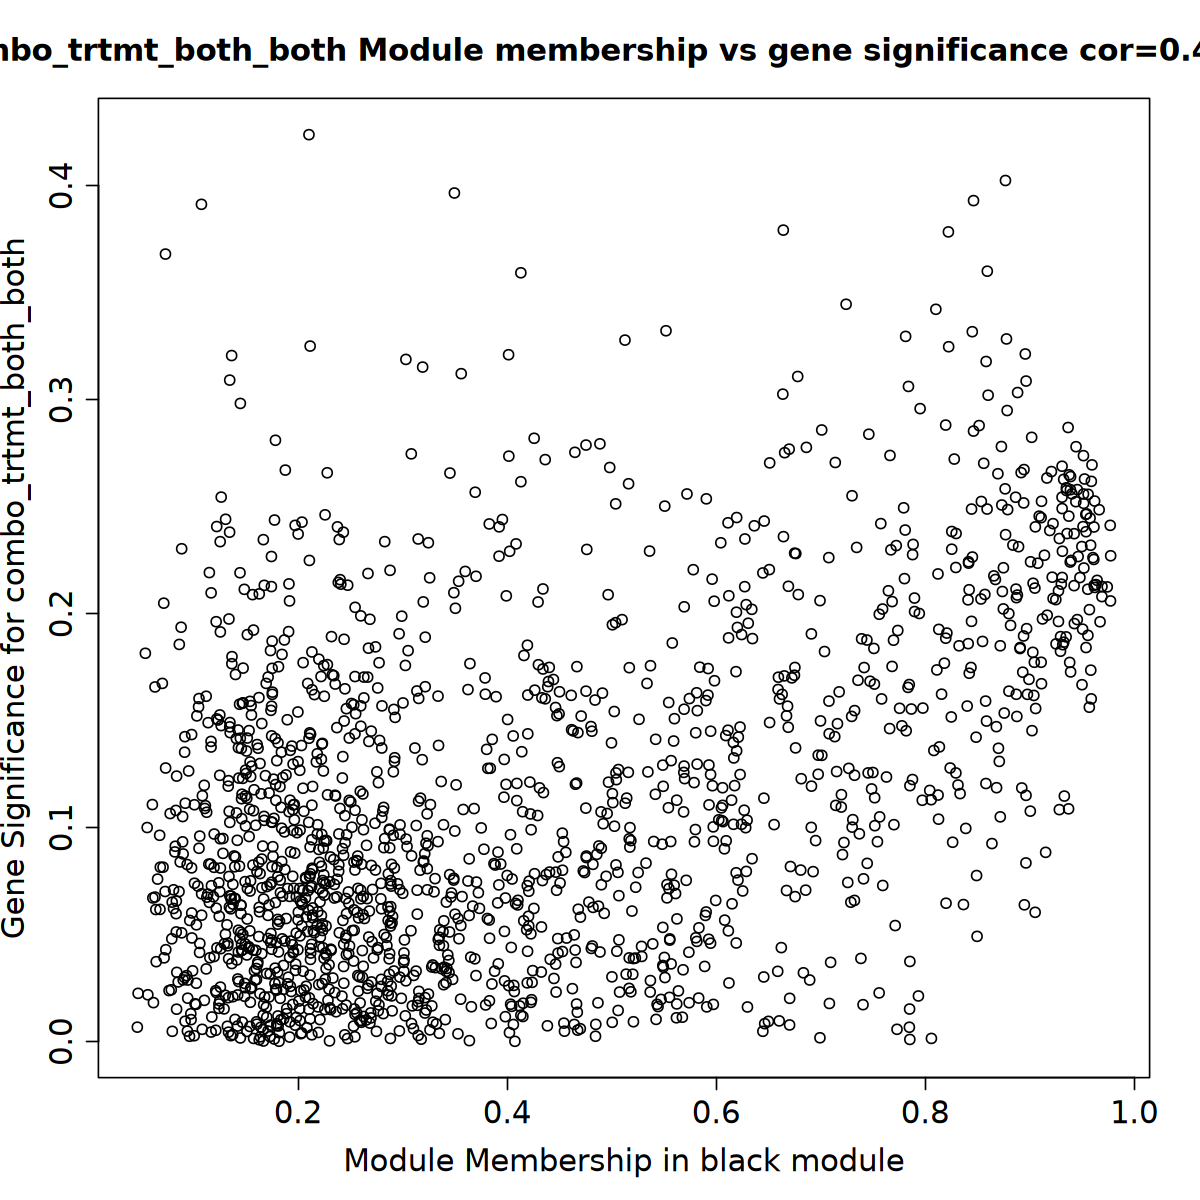

In [104]:
options(repr.plot.width = 10, repr.plot.height = 10)

verboseScatterplot(
  abs(x),
  abs(y),
  xlab = paste("Module Membership in", bestModuleColor, "module"),
  ylab = paste("Gene Significance for", trait1),
  main = paste(bestModuleColor, "-", trait1, "Module membership vs gene significance"),
  col = "black"
)

for each "trait" (just the treatment combo), pull out the top module, plot MM vs. GS, and return list of top 10 hub genes (most connected in the module)

[1] "Top hub genes for trait: combo_trtmt_both_both Module: black"
                     Gene moduleColor  MM.black GS.combo_trtmt_both_both
LOC111104331 LOC111104331       black 0.8765874                0.4024579
LOC111116525 LOC111116525       black 0.8460422                0.3930666
LOC111127913 LOC111127913       black 0.8219906                0.3784465
LOC111121943 LOC111121943       black 0.8592208                0.3600778
LOC111123918 LOC111123918       black 0.8775678                0.3284056
LOC111125215 LOC111125215       black 0.8955648                0.3213760
LOC111104602 LOC111104602       black 0.8448421                0.3317887
LOC111137353 LOC111137353       black 0.8100107                0.3422670
LOC111103087 LOC111103087       black 0.8963281                0.3087233
LOC111125728 LOC111125728       black 0.8580943                0.3178670
              hubScore
LOC111104331 0.3527895
LOC111116525 0.3325510
LOC111127913 0.3110795
LOC111121943 0.3093864
LOC111123918 0.

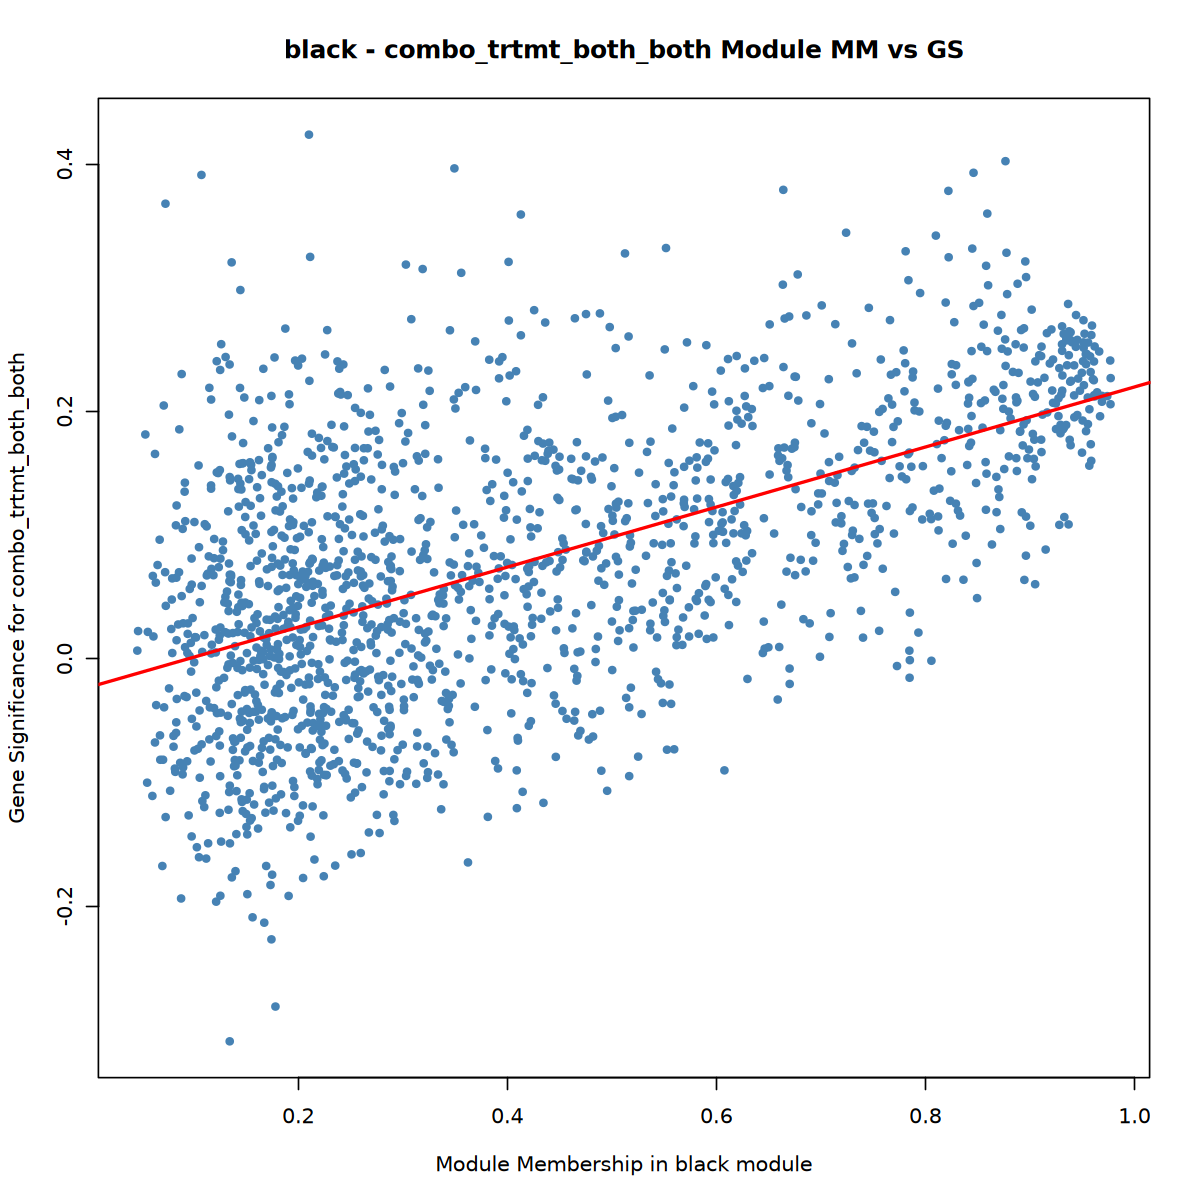

[1] "Top hub genes for trait: combo_trtmt_both_control Module: yellow"
                     Gene moduleColor MM.yellow GS.combo_trtmt_both_control
LOC111103552 LOC111103552      yellow 0.8847442                   0.3766438
LOC111130467 LOC111130467      yellow 0.8016783                   0.3660130
LOC111133546 LOC111133546      yellow 0.8972956                   0.3218492
LOC111126213 LOC111126213      yellow 0.8568183                   0.3265997
LOC111121519 LOC111121519      yellow 0.7708682                   0.3564721
LOC111108423 LOC111108423      yellow 0.8432234                   0.3123549
LOC111120597 LOC111120597      yellow 0.7963357                   0.3189504
LOC111130337 LOC111130337      yellow 0.8053897                   0.3118607
LOC111135802 LOC111135802      yellow 0.8223351                   0.3032074
LOC111136821 LOC111136821      yellow 0.7986135                   0.3108321
              hubScore
LOC111103552 0.3332334
LOC111130467 0.2934247
LOC111133546 0.2887939
L

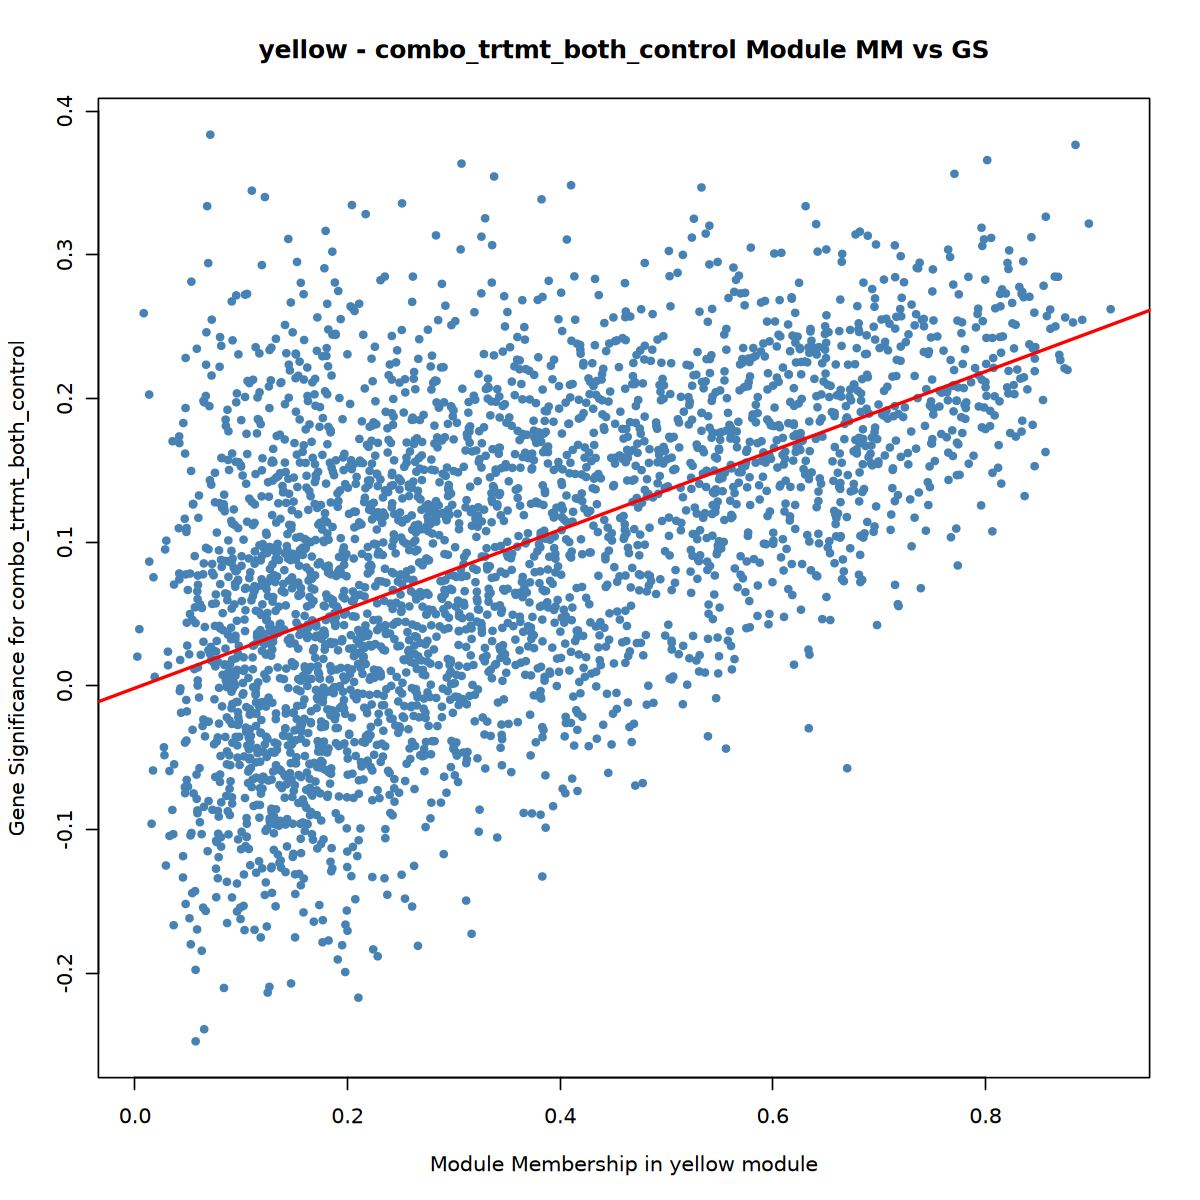

[1] "Top hub genes for trait: combo_trtmt_both_hypoxic Module: midnightblue"
                     Gene  moduleColor MM.midnightblue
LOC111135618 LOC111135618 midnightblue       0.8439713
LOC111101972 LOC111101972 midnightblue       0.6250662
LOC111118917 LOC111118917 midnightblue       0.8217317
LOC111119151 LOC111119151 midnightblue       0.6858440
LOC111102113 LOC111102113 midnightblue       0.7350230
LOC111138077 LOC111138077 midnightblue       0.6768939
LOC111100546 LOC111100546 midnightblue       0.7185405
LOC111122162 LOC111122162 midnightblue       0.7939376
LOC111112299 LOC111112299 midnightblue       0.8540034
LOC111100563 LOC111100563 midnightblue       0.8214241
             GS.combo_trtmt_both_hypoxic  hubScore
LOC111135618                  -0.3193650 0.2695349
LOC111101972                  -0.4155461 0.2597438
LOC111118917                  -0.3145731 0.2584947
LOC111119151                  -0.3614233 0.2478800
LOC111102113                  -0.3344325 0.2458155
LOC111138077

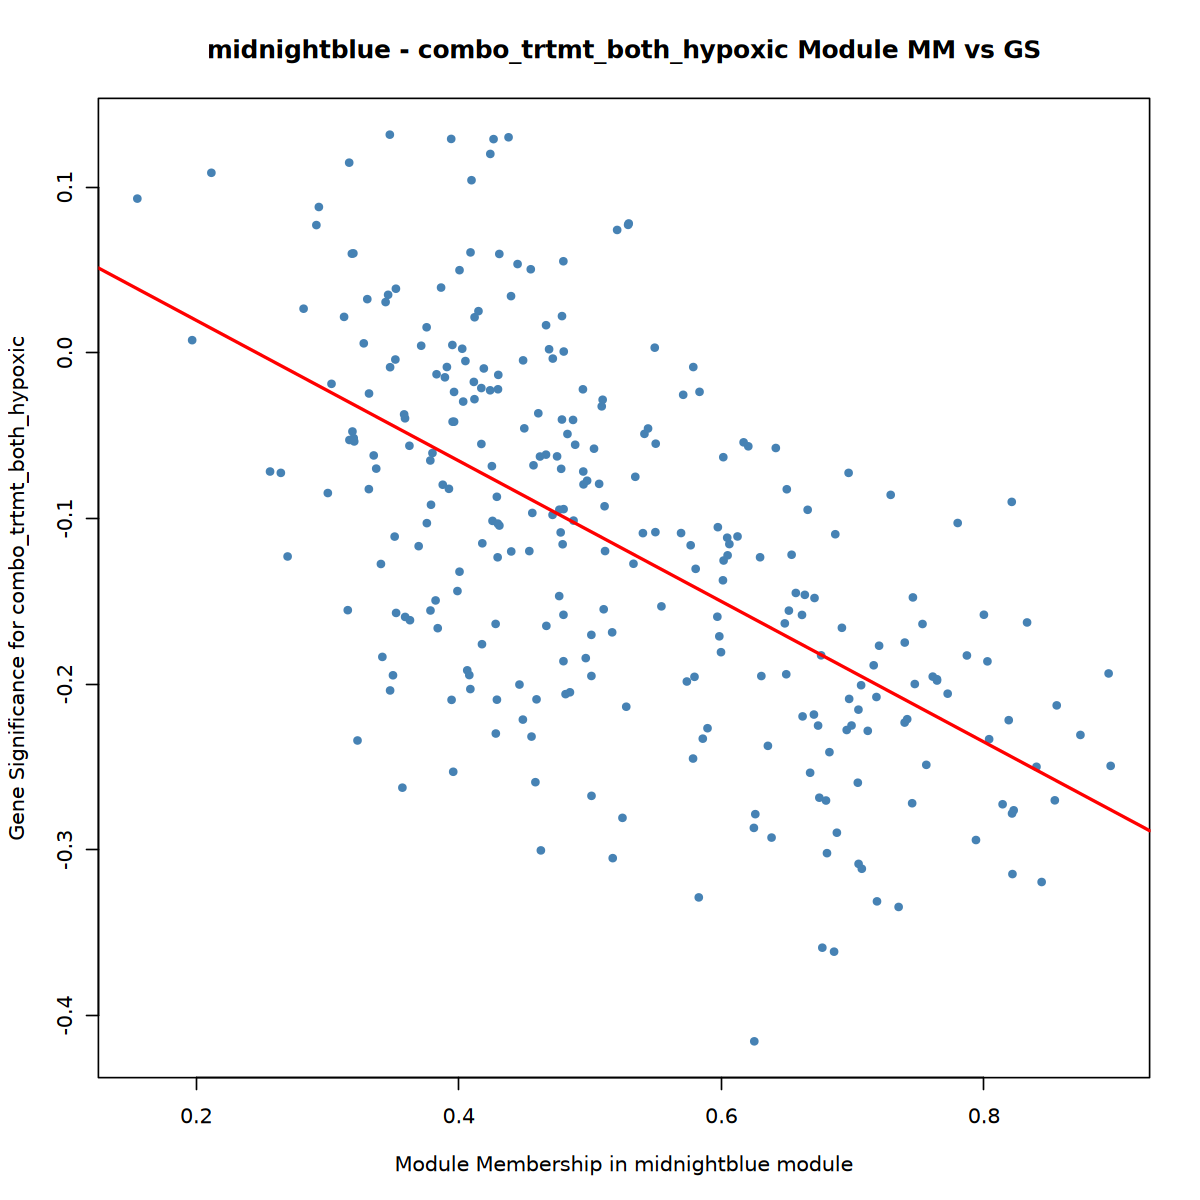

[1] "Top hub genes for trait: combo_trtmt_both_warm Module: blue"
                     Gene moduleColor   MM.blue GS.combo_trtmt_both_warm
LOC111129032 LOC111129032        blue 0.7395908                0.3486324
LOC111126576 LOC111126576        blue 0.7153972                0.3331973
LOC111131498 LOC111131498        blue 0.6981784                0.3370438
LOC111099426 LOC111099426        blue 0.7296767                0.3155780
LOC111123211 LOC111123211        blue 0.7455917                0.3076739
LOC111137835 LOC111137835        blue 0.6608858                0.3363681
LOC111123202 LOC111123202        blue 0.6757329                0.3269493
LOC111134719 LOC111134719        blue 0.7498028                0.2907385
LOC111128383 LOC111128383        blue 0.7239482                0.3000957
LOC111125958 LOC111125958        blue 0.7724453                0.2792416
              hubScore
LOC111129032 0.2578453
LOC111126576 0.2383684
LOC111131498 0.2353167
LOC111099426 0.2302699
LOC111123211 0.2

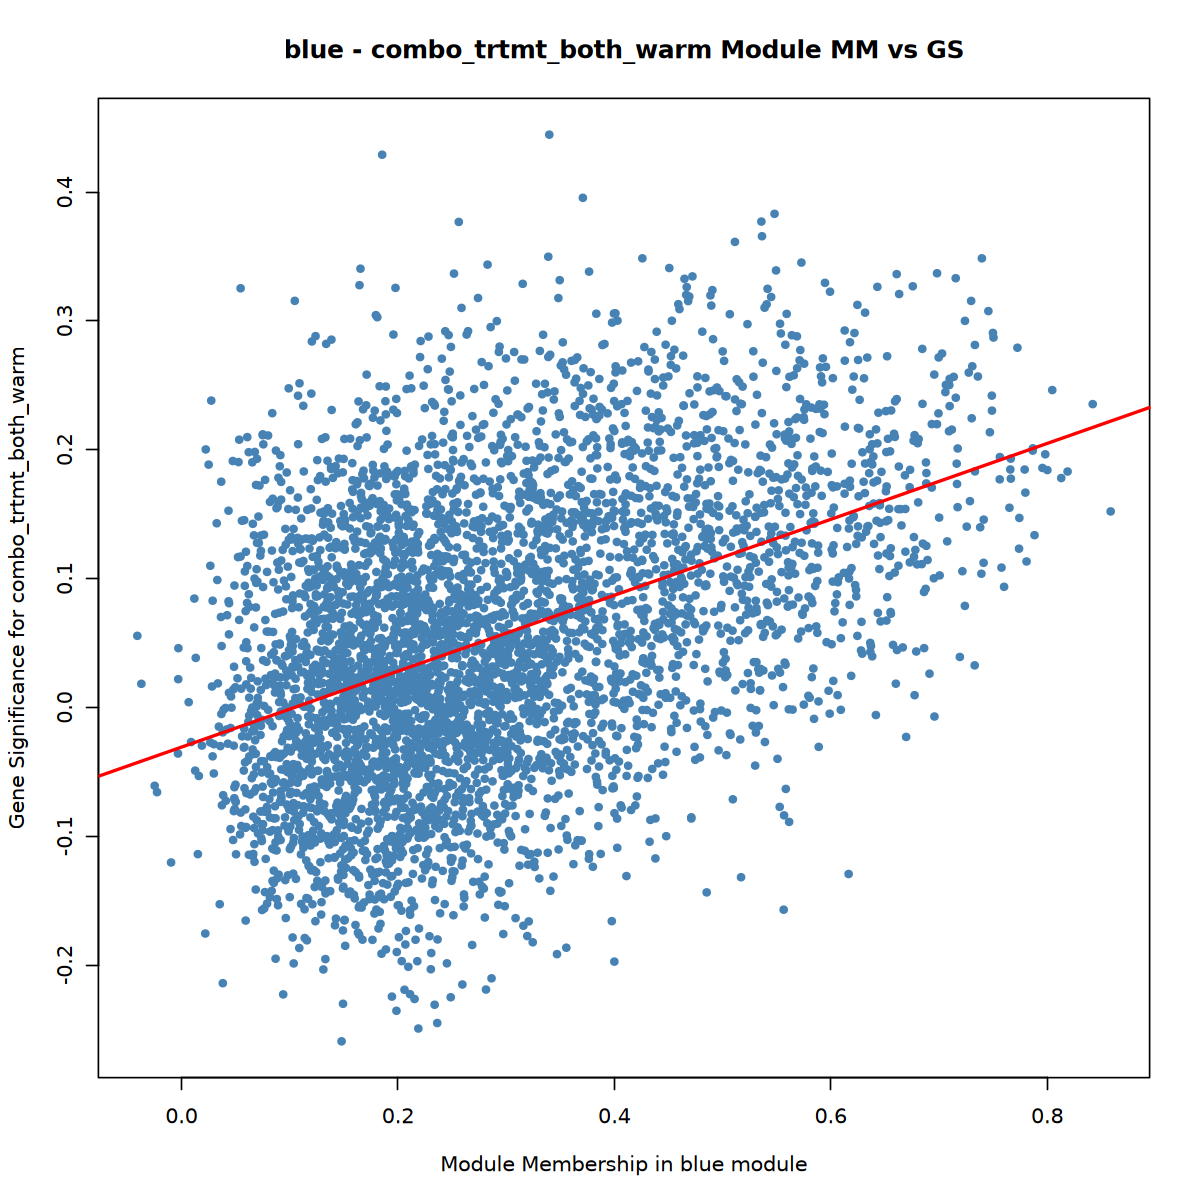

[1] "Top hub genes for trait: combo_trtmt_control_both Module: magenta"
                     Gene moduleColor MM.magenta GS.combo_trtmt_control_both
LOC111100846 LOC111100846     magenta  0.7909885                   0.3389396
LOC111134718 LOC111134718     magenta  0.8097914                   0.3273707
LOC111128113 LOC111128113     magenta  0.6299208                   0.4043304
LOC111122194 LOC111122194     magenta  0.6533276                   0.3747495
LOC111132997 LOC111132997     magenta  0.8350765                   0.2892261
LOC111102758 LOC111102758     magenta  0.5782723                   0.3945788
LOC111117895 LOC111117895     magenta  0.7607698                   0.2937812
LOC111120085 LOC111120085     magenta  0.6218645                   0.3532409
LOC111100569 LOC111100569     magenta  0.6907369                   0.3083162
LOC111125352 LOC111125352     magenta  0.7513332                   0.2787490
              hubScore
LOC111100846 0.2680973
LOC111134718 0.2651020
LOC111128113

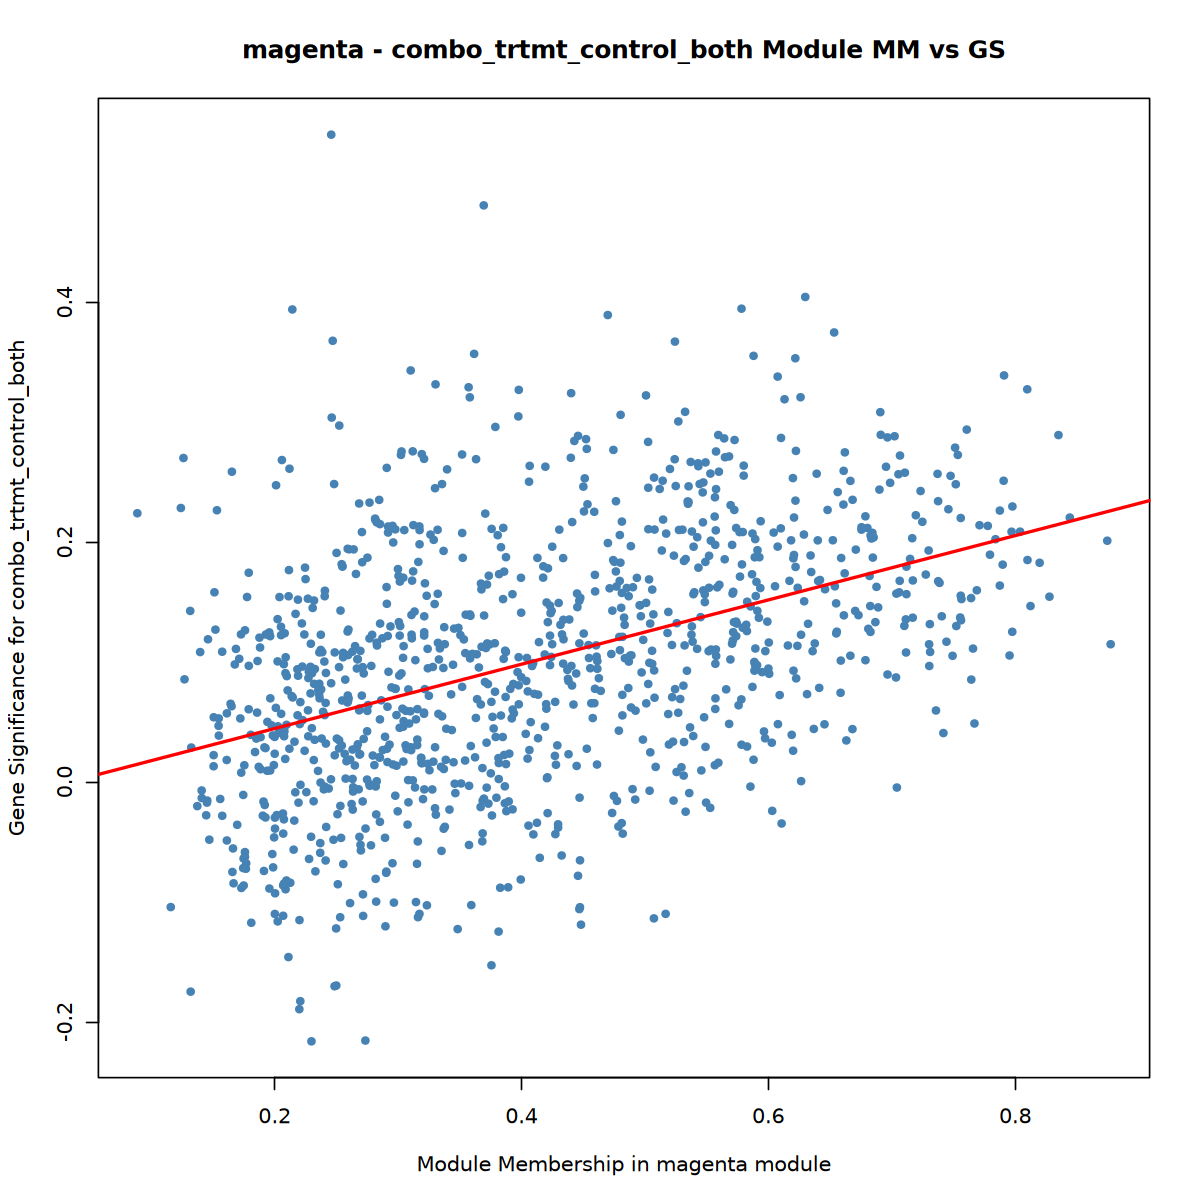

[1] "Top hub genes for trait: combo_trtmt_control_control Module: magenta"
                     Gene moduleColor MM.magenta GS.combo_trtmt_control_control
LOC111129300 LOC111129300     magenta  0.8442710                     -0.3142669
LOC111130534 LOC111130534     magenta  0.7304221                     -0.3461140
LOC111112596 LOC111112596     magenta  0.6664956                     -0.3612394
LOC111118004 LOC111118004     magenta  0.7898922                     -0.3011831
LOC111119533 LOC111119533     magenta  0.6876370                     -0.3273838
LOC111118166 LOC111118166     magenta  0.7233727                     -0.3022573
LOC111131864 LOC111131864     magenta  0.6965926                     -0.3106856
LOC111102171 LOC111102171     magenta  0.8746264                     -0.2457061
LOC111130349 LOC111130349     magenta  0.8198356                     -0.2619453
LOC111117421 LOC111117421     magenta  0.6986915                     -0.3053265
              hubScore
LOC111129300 0.2653265

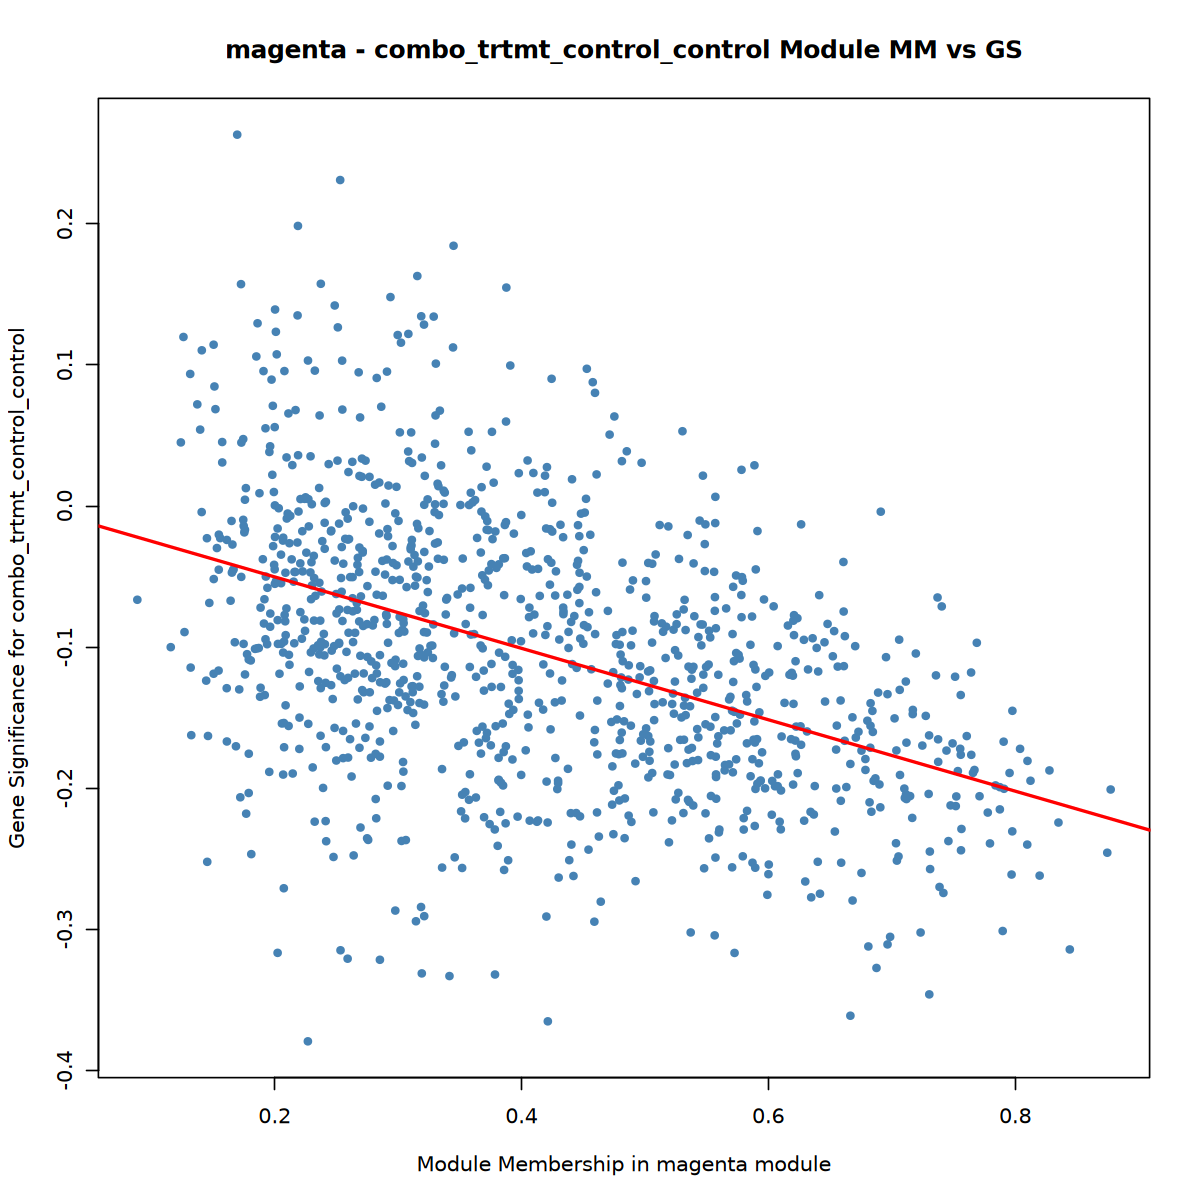

[1] "Top hub genes for trait: combo_trtmt_control_hypoxic Module: brown"
                     Gene moduleColor  MM.brown GS.combo_trtmt_control_hypoxic
LOC111109666 LOC111109666       brown 0.8496595                     -0.2989618
LOC111121129 LOC111121129       brown 0.7698695                     -0.2996998
LOC111102390 LOC111102390       brown 0.7949704                     -0.2810895
LOC111100708 LOC111100708       brown 0.8069478                     -0.2754671
LOC111111438 LOC111111438       brown 0.8849249                     -0.2479261
LOC111122819 LOC111122819       brown 0.8550358                     -0.2538432
LOC111135345 LOC111135345       brown 0.8655381                     -0.2464060
LOC111138463 LOC111138463       brown 0.7087314                     -0.3008627
LOC111101507 LOC111101507       brown 0.8411263                     -0.2532673
LOC111124261 LOC111124261       brown 0.8758955                     -0.2400474
              hubScore
LOC111109666 0.2540158
LOC111121129

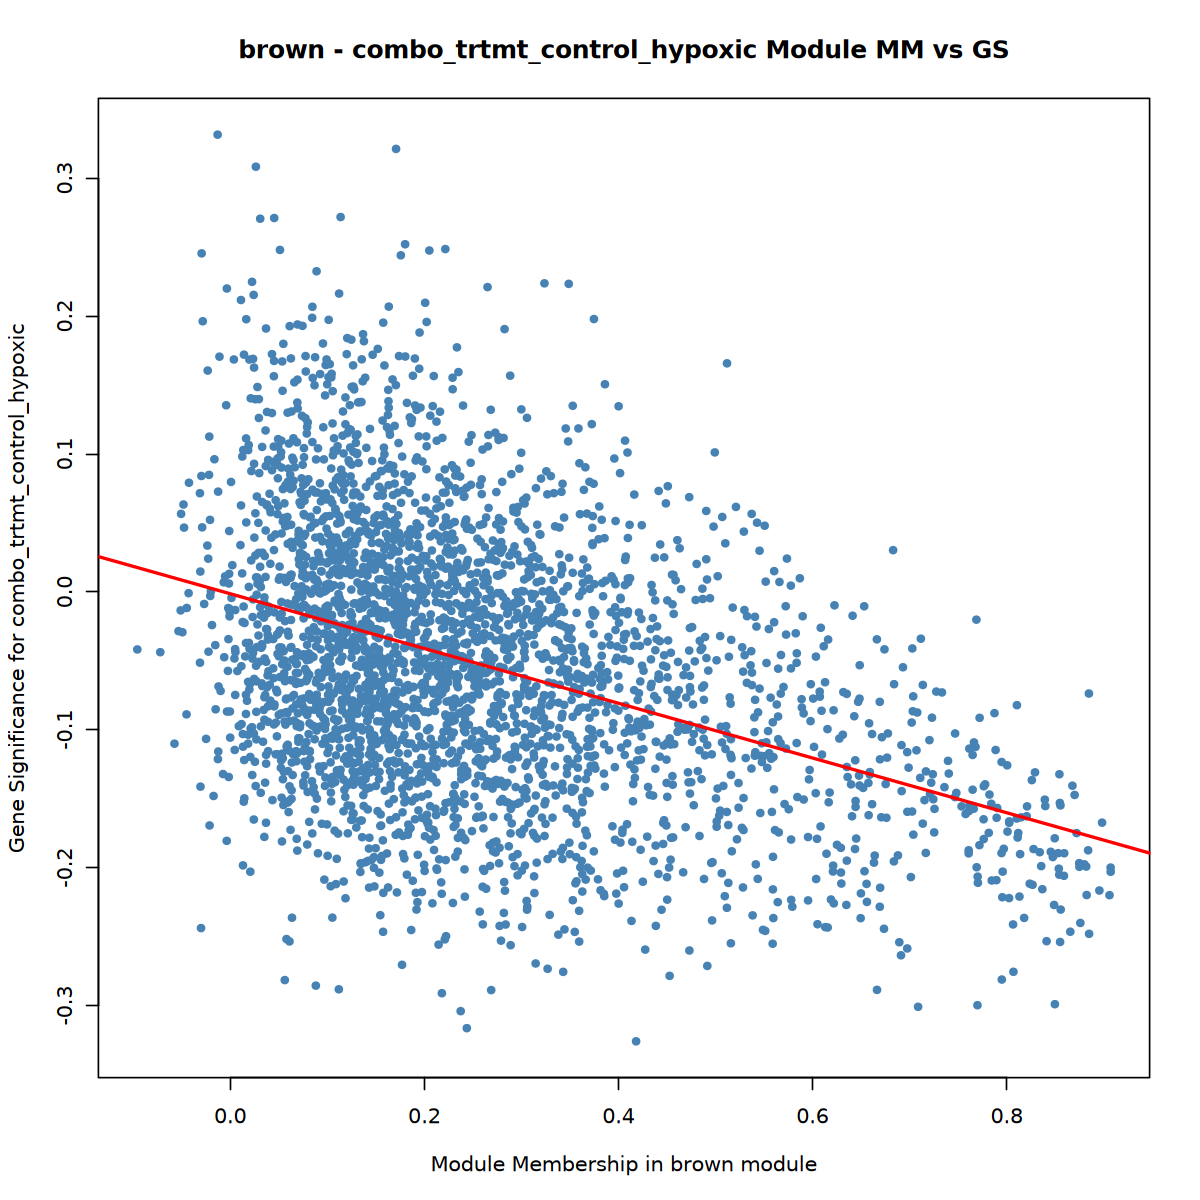

[1] "Top hub genes for trait: combo_trtmt_control_warm Module: turquoise"
                     Gene moduleColor MM.turquoise GS.combo_trtmt_control_warm
LOC111114208 LOC111114208   turquoise    0.8539821                   0.4409543
LOC111113584 LOC111113584   turquoise    0.7945374                   0.4644192
LOC111117430 LOC111117430   turquoise    0.9289603                   0.3937487
LOC111102114 LOC111102114   turquoise    0.8939756                   0.3960388
LOC111121568 LOC111121568   turquoise    0.8765341                   0.3950028
LOC111099038 LOC111099038   turquoise    0.8072697                   0.4283698
LOC111102376 LOC111102376   turquoise    0.9052116                   0.3800628
LOC111111254 LOC111111254   turquoise    0.8337330                   0.4119776
LOC111134389 LOC111134389   turquoise    0.9070181                   0.3777722
LOC111104052 LOC111104052   turquoise    0.8468878                   0.4034285
              hubScore
LOC111114208 0.3765671
LOC11111358

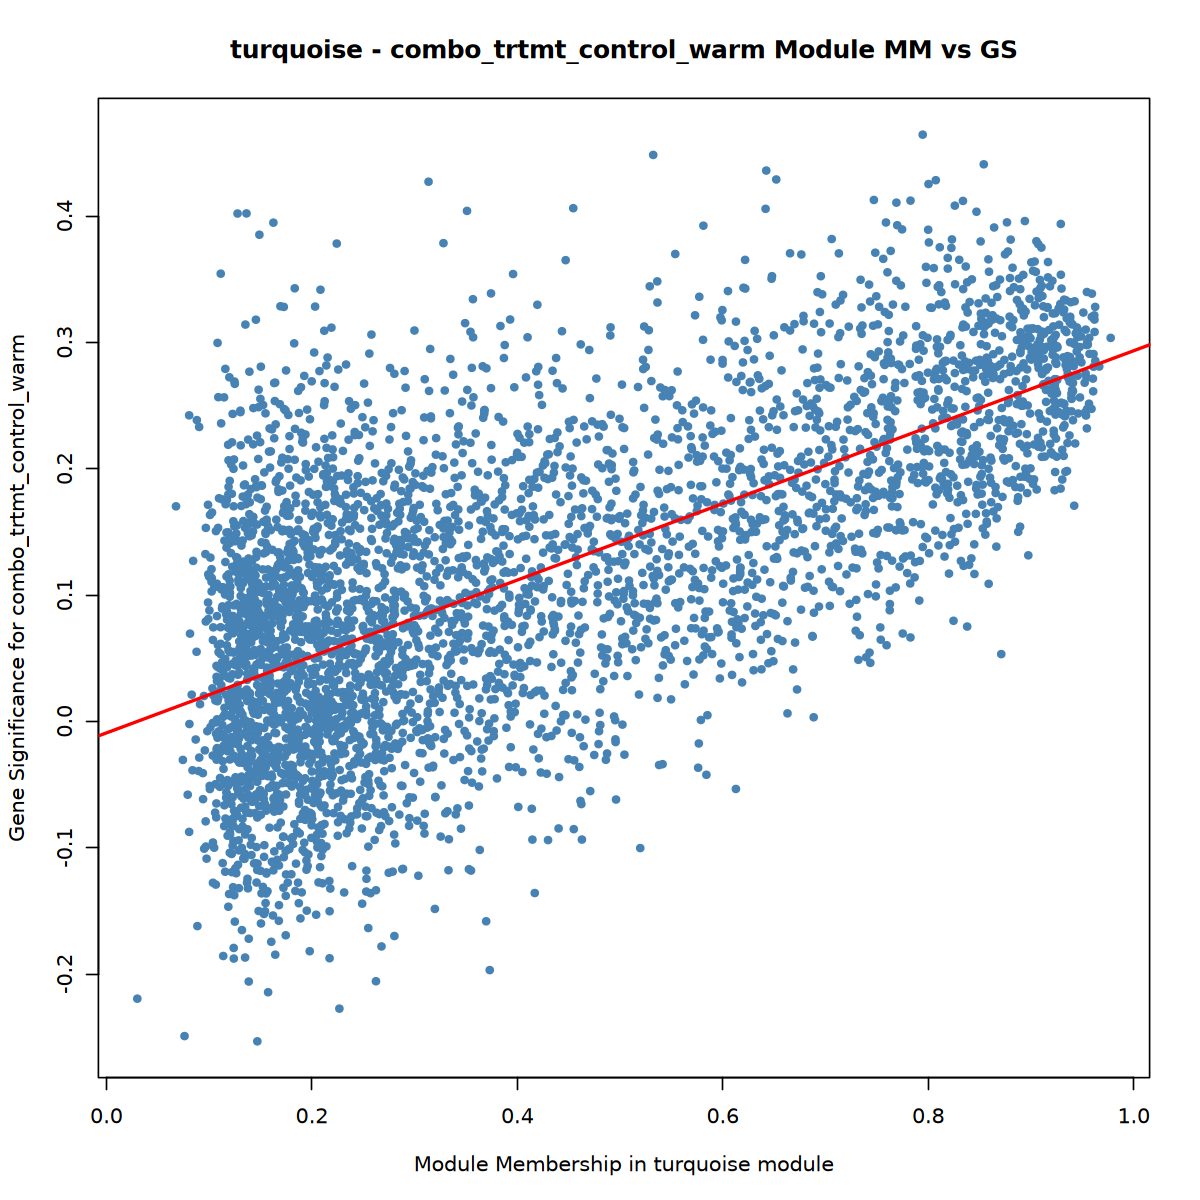

[1] "Top hub genes for trait: combo_trtmt_hypoxic_both Module: salmon"
                     Gene moduleColor MM.salmon GS.combo_trtmt_hypoxic_both
LOC111131031 LOC111131031      salmon 0.6809261                   0.4271917
LOC111125124 LOC111125124      salmon 0.6062146                   0.3370199
LOC111115632 LOC111115632      salmon 0.5650786                   0.3551337
LOC111103225 LOC111103225      salmon 0.6686848                   0.2925756
LOC111124865 LOC111124865      salmon 0.6217628                   0.2995869
LOC111106500 LOC111106500      salmon 0.6675640                   0.2774009
LOC111128168 LOC111128168      salmon 0.7187049                   0.2513583
LOC111129018 LOC111129018      salmon 0.6489492                   0.2715043
LOC111108698 LOC111108698      salmon 0.6787864                   0.2589635
LOC111119855 LOC111119855      salmon 0.8897608                   0.1970246
              hubScore
LOC111131031 0.2908860
LOC111125124 0.2043064
LOC111115632 0.2006785
L

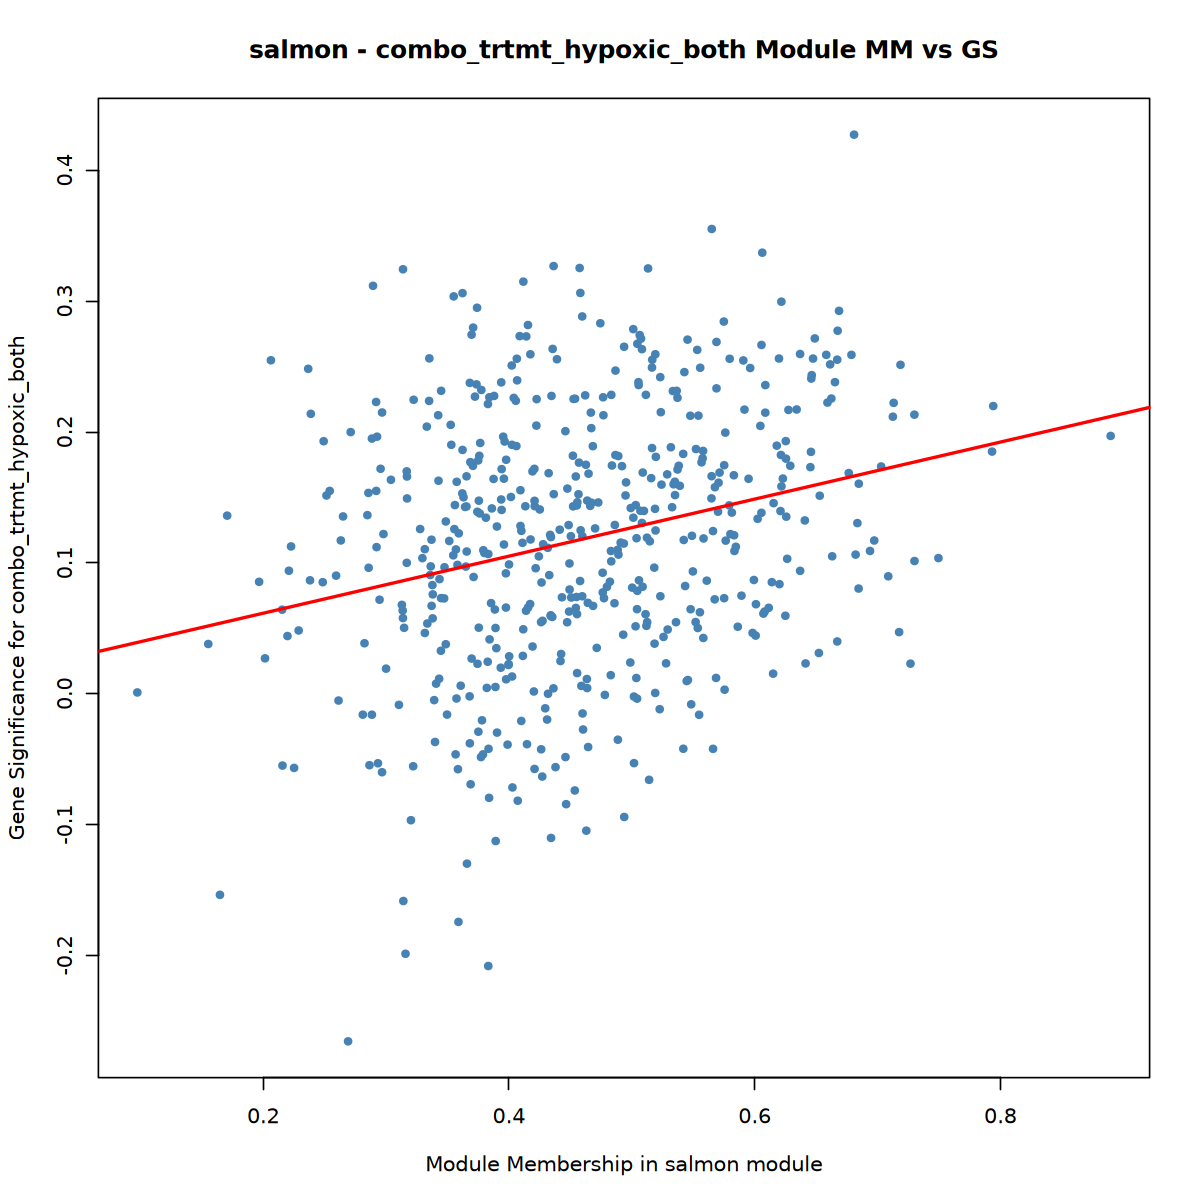

[1] "Top hub genes for trait: combo_trtmt_hypoxic_control Module: yellow"
                     Gene moduleColor MM.yellow GS.combo_trtmt_hypoxic_control
LOC111134890 LOC111134890      yellow 0.8609282                      0.3602140
LOC111136668 LOC111136668      yellow 0.8216623                      0.3364303
LOC111127947 LOC111127947      yellow 0.8541862                      0.3172566
LOC111119766 LOC111119766      yellow 0.8346713                      0.3203706
LOC111135316 LOC111135316      yellow 0.9178140                      0.2910615
LOC111108746 LOC111108746      yellow 0.8564926                      0.3100633
LOC111120597 LOC111120597      yellow 0.7963357                      0.3304602
LOC111129496 LOC111129496      yellow 0.8823776                      0.2911120
LOC111135524 LOC111135524      yellow 0.8284331                      0.3099631
LOC111101916 LOC111101916      yellow 0.8138258                      0.3095587
              hubScore
LOC111134890 0.3101184
LOC11113666

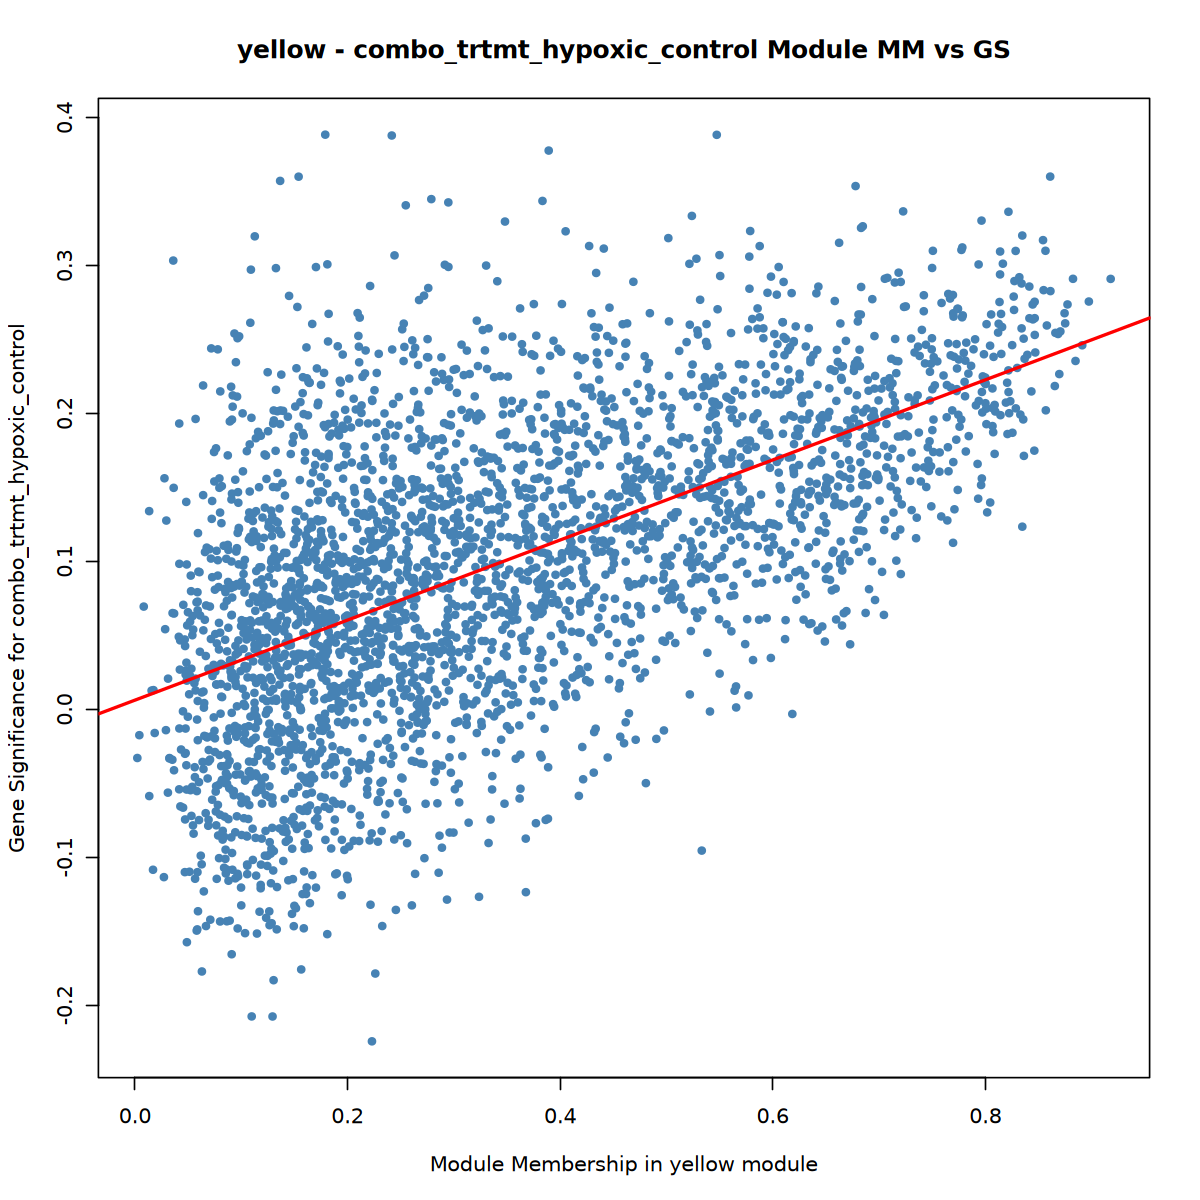

[1] "Top hub genes for trait: combo_trtmt_hypoxic_hypoxic Module: cyan"
                     Gene moduleColor   MM.cyan GS.combo_trtmt_hypoxic_hypoxic
LOC111135089 LOC111135089        cyan 0.9035601                      0.2937411
LOC111126081 LOC111126081        cyan 0.8658759                      0.3005663
LOC111121573 LOC111121573        cyan 0.8916882                      0.2881405
LOC111123910 LOC111123910        cyan 0.8503739                      0.2948904
LOC111125074 LOC111125074        cyan 0.8561842                      0.2884580
LOC111136156 LOC111136156        cyan 0.7005002                      0.3496760
LOC111130301 LOC111130301        cyan 0.9016034                      0.2714952
LOC111126154 LOC111126154        cyan 0.8677285                      0.2738807
LOC111118350 LOC111118350        cyan 0.8296439                      0.2836505
LOC111138059 LOC111138059        cyan 0.6955037                      0.3379999
              hubScore
LOC111135089 0.2654127
LOC111126081 

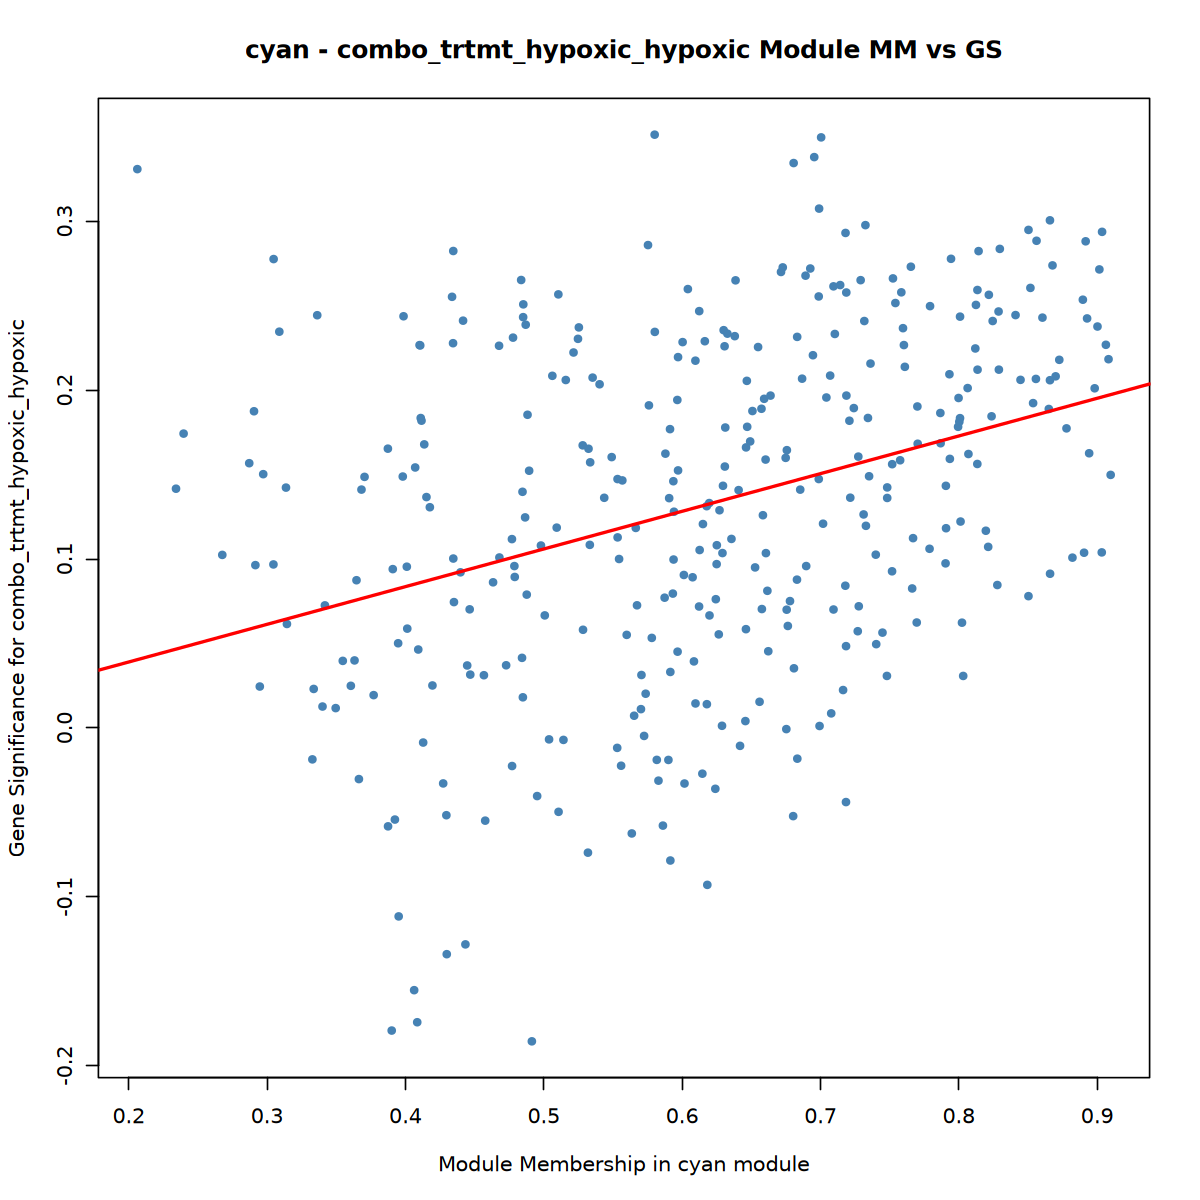

[1] "Top hub genes for trait: combo_trtmt_hypoxic_warm Module: greenyellow"
                     Gene moduleColor MM.greenyellow
LOC111124571 LOC111124571 greenyellow      0.6251358
LOC111130067 LOC111130067 greenyellow      0.7577319
LOC111135411 LOC111135411 greenyellow      0.6658649
LOC111101689 LOC111101689 greenyellow      0.8259527
LOC111110508 LOC111110508 greenyellow      0.5132563
LOC111137171 LOC111137171 greenyellow      0.7487484
LOC111120138 LOC111120138 greenyellow      0.5595856
LOC111135213 LOC111135213 greenyellow      0.6404347
LOC111135738 LOC111135738 greenyellow      0.7084052
LOC111132183 LOC111132183 greenyellow      0.6301979
             GS.combo_trtmt_hypoxic_warm  hubScore
LOC111124571                   0.3475291 0.2172529
LOC111130067                   0.2784434 0.2109854
LOC111135411                   0.3107022 0.2068857
LOC111101689                   0.2415852 0.1995379
LOC111110508                   0.3577241 0.1836041
LOC111137171                   0.23

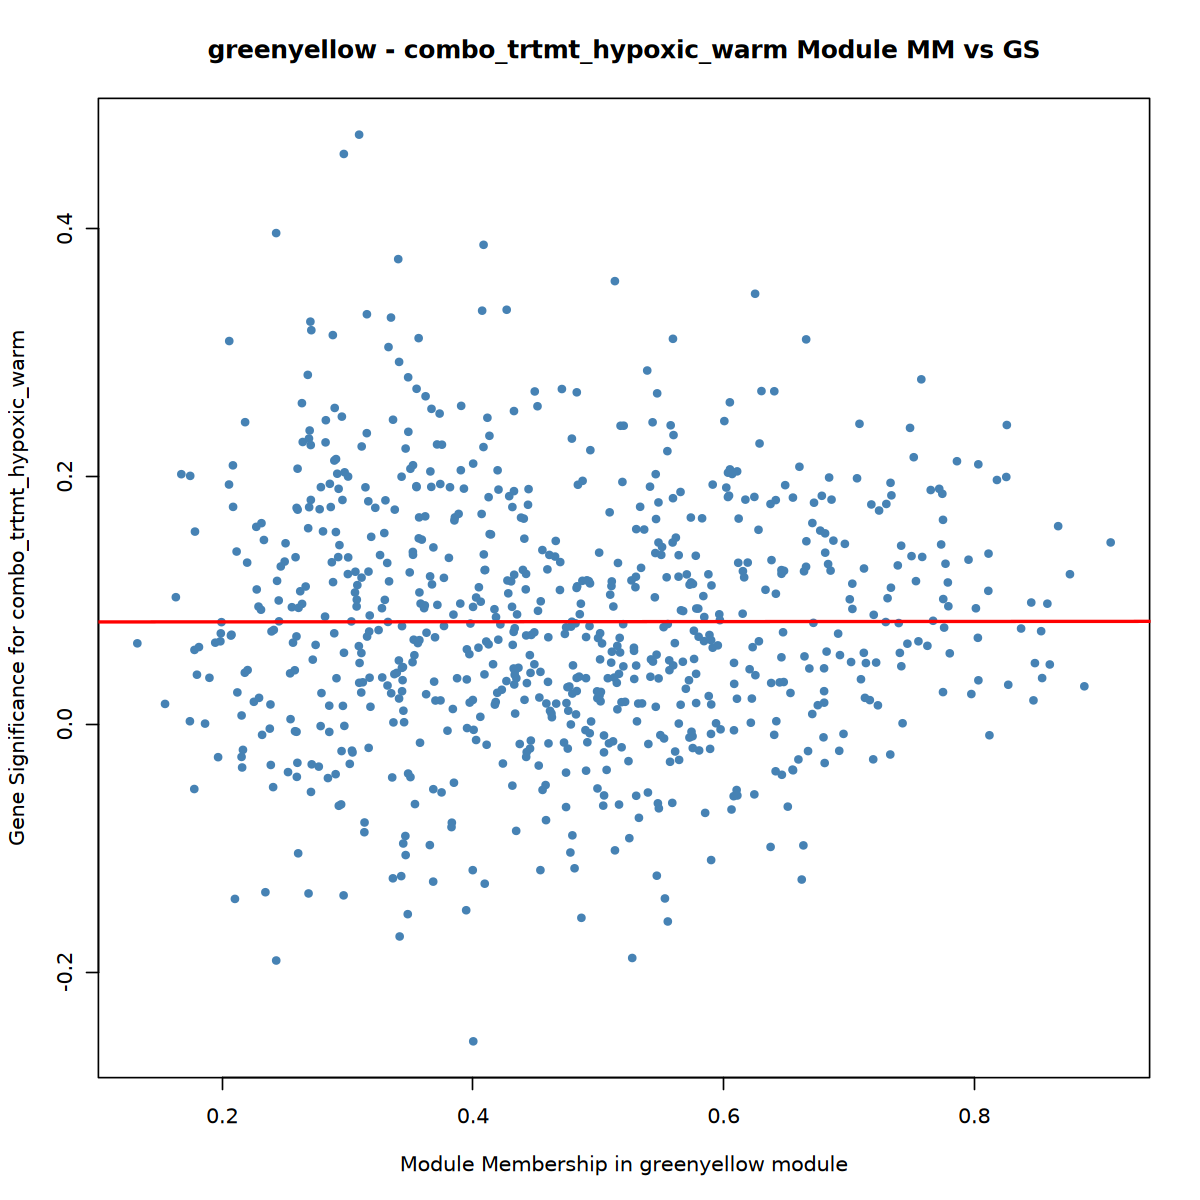

[1] "Top hub genes for trait: combo_trtmt_warm_both Module: pink"
                     Gene moduleColor   MM.pink GS.combo_trtmt_warm_both
LOC111114516 LOC111114516        pink 0.8039793                0.4815379
LOC111104019 LOC111104019        pink 0.8099238                0.4602598
LOC111127651 LOC111127651        pink 0.8586575                0.3812830
LOC111114620 LOC111114620        pink 0.7825437                0.4134798
LOC111117324 LOC111117324        pink 0.6012359                0.5309253
LOC111138283 LOC111138283        pink 0.9263937                0.3348785
LOC111111462 LOC111111462        pink 0.8585506                0.3470269
LOC111126696 LOC111126696        pink 0.9179363                0.3228384
LOC111126700 LOC111126700        pink 0.8460803                0.3490044
LOC111104107 LOC111104107        pink 0.8762711                0.3335456
              hubScore
LOC111114516 0.3871465
LOC111104019 0.3727754
LOC111127651 0.3273915
LOC111114620 0.3235660
LOC111117324 0.3

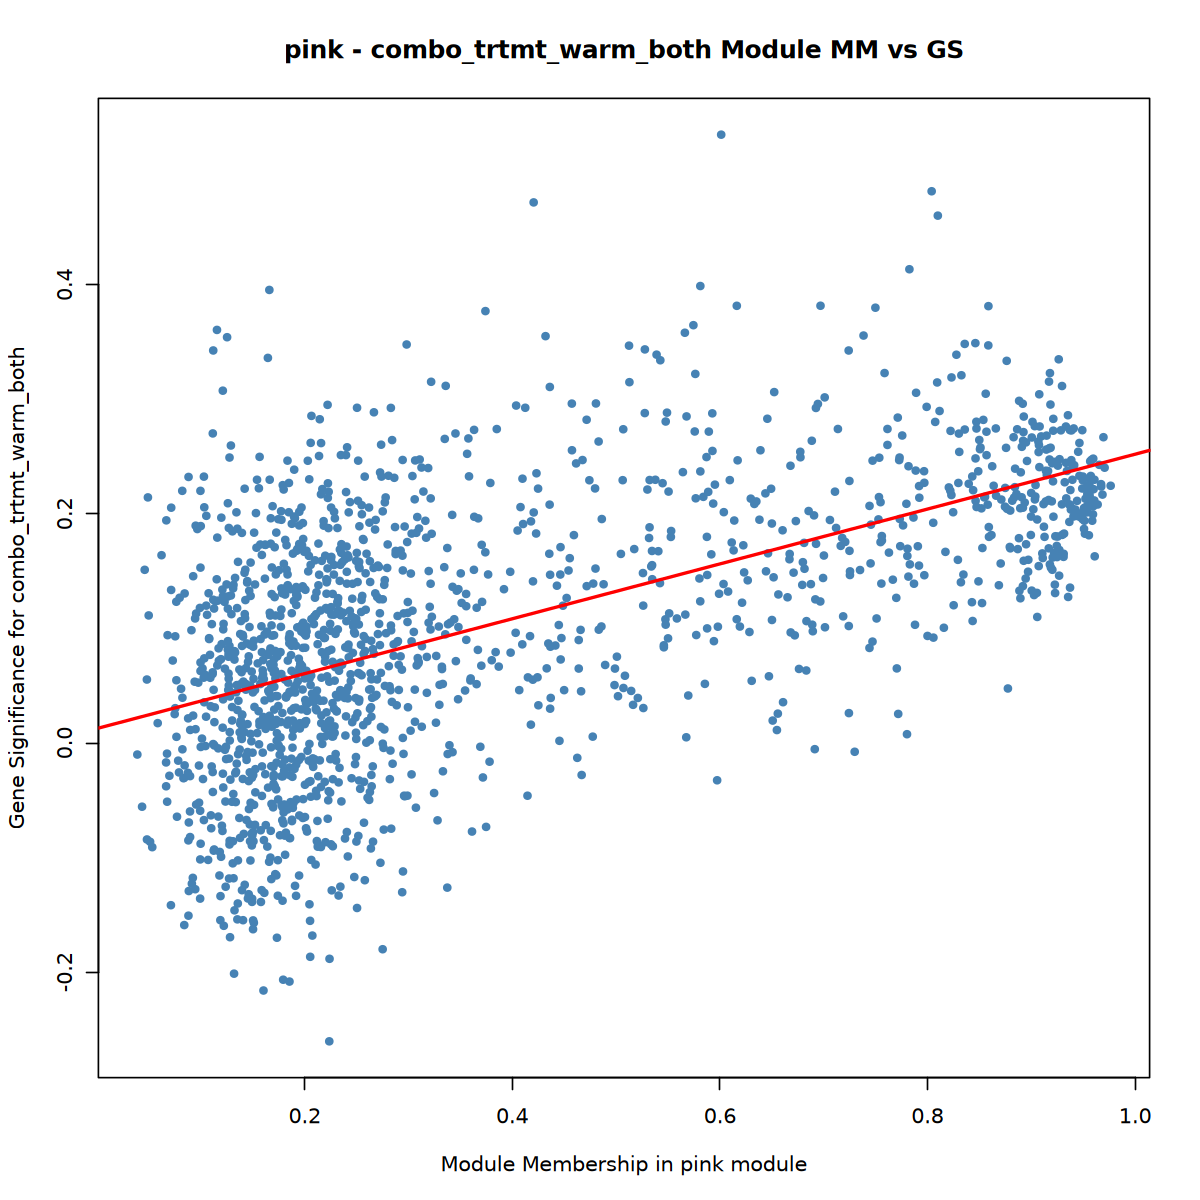

[1] "Top hub genes for trait: combo_trtmt_warm_control Module: yellow"
                     Gene moduleColor MM.yellow GS.combo_trtmt_warm_control
LOC111133359 LOC111133359      yellow 0.8043899                   0.3746120
LOC111127912 LOC111127912      yellow 0.7729149                   0.3677970
LOC111122853 LOC111122853      yellow 0.8286049                   0.3382749
LOC111103813 LOC111103813      yellow 0.8695010                   0.3147163
LOC111120597 LOC111120597      yellow 0.7963357                   0.3427300
LOC111118247 LOC111118247      yellow 0.8744499                   0.3100463
LOC111100768 LOC111100768      yellow 0.8340264                   0.3240763
LOC111133712 LOC111133712      yellow 0.7741952                   0.3491143
LOC111124552 LOC111124552      yellow 0.8254098                   0.3272495
LOC111105293 LOC111105293      yellow 0.8339901                   0.3235911
              hubScore
LOC111133359 0.3013341
LOC111127912 0.2842758
LOC111122853 0.2802963
L

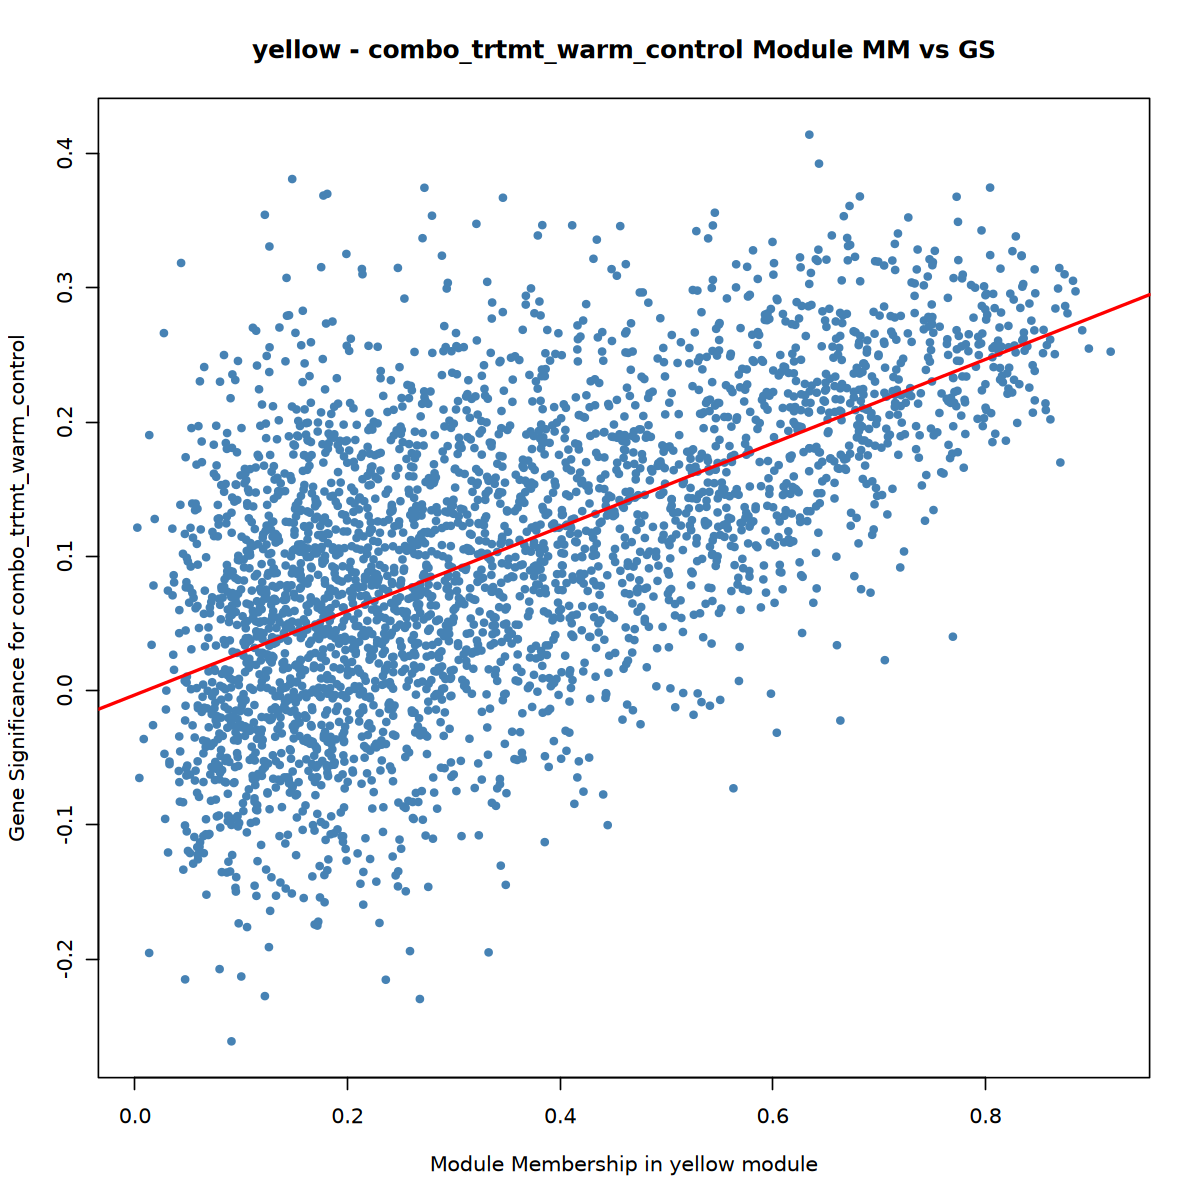

[1] "Top hub genes for trait: combo_trtmt_warm_hypoxic Module: turquoise"
                     Gene moduleColor MM.turquoise GS.combo_trtmt_warm_hypoxic
LOC111132169 LOC111132169   turquoise    0.8185220                  -0.2545281
LOC111137746 LOC111137746   turquoise    0.7302916                  -0.2677551
LOC111099054 LOC111099054   turquoise    0.7632852                  -0.2407694
LOC111122599 LOC111122599   turquoise    0.6159163                  -0.2959255
LOC111114748 LOC111114748   turquoise    0.7602529                  -0.2360017
LOC111134813 LOC111134813   turquoise    0.8328984                  -0.2142760
LOC111126151 LOC111126151   turquoise    0.8962416                  -0.1961949
LOC111122922 LOC111122922   turquoise    0.8244412                  -0.2078738
LOC111125973 LOC111125973   turquoise    0.8285483                  -0.2037613
LOC111128297 LOC111128297   turquoise    0.5886572                  -0.2854776
              hubScore
LOC111132169 0.2083368
LOC11113774

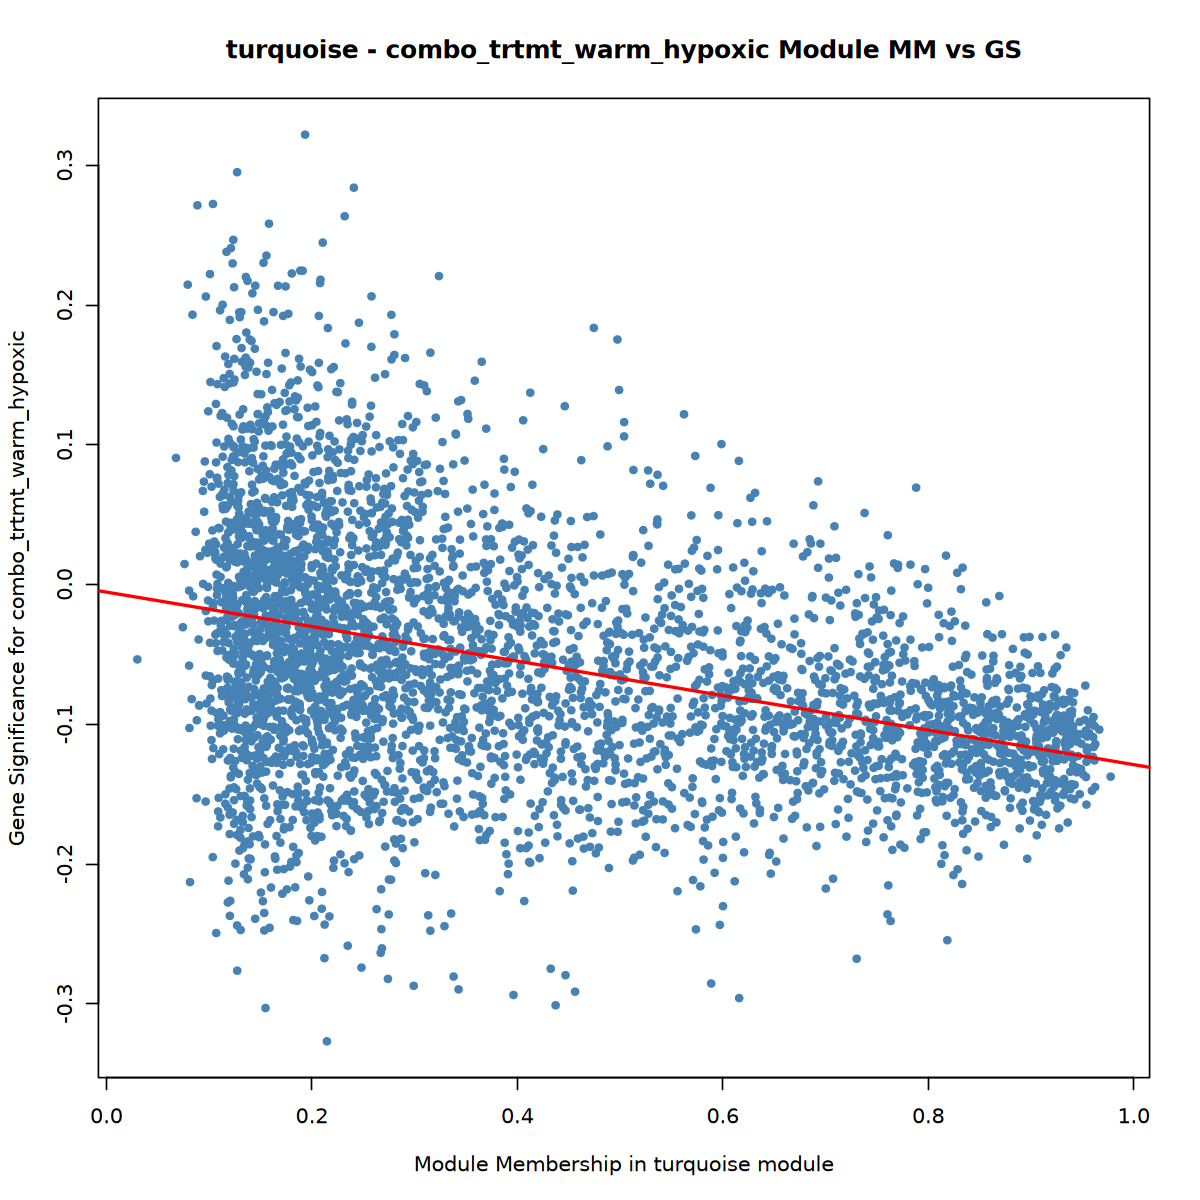

[1] "Top hub genes for trait: combo_trtmt_warm_warm Module: red"
                     Gene moduleColor    MM.red GS.combo_trtmt_warm_warm
LOC111103387 LOC111103387         red 0.8050820                0.2912518
LOC111133485 LOC111133485         red 0.8855537                0.2437674
LOC111135471 LOC111135471         red 0.8909602                0.2417214
LOC111125405 LOC111125405         red 0.7354985                0.2862344
LOC111120115 LOC111120115         red 0.7972574                0.2574824
LOC111111230 LOC111111230         red 0.7183053                0.2854646
LOC111129281 LOC111129281         red 0.7109150                0.2872731
LOC111099749 LOC111099749         red 0.7320288                0.2678081
LOC111100498 LOC111100498         red 0.7992913                0.2434315
LOC111133371 LOC111133371         red 0.7341067                0.2631837
              hubScore
LOC111103387 0.2344816
LOC111133485 0.2158691
LOC111135471 0.2153642
LOC111125405 0.2105249
LOC111120115 0.20

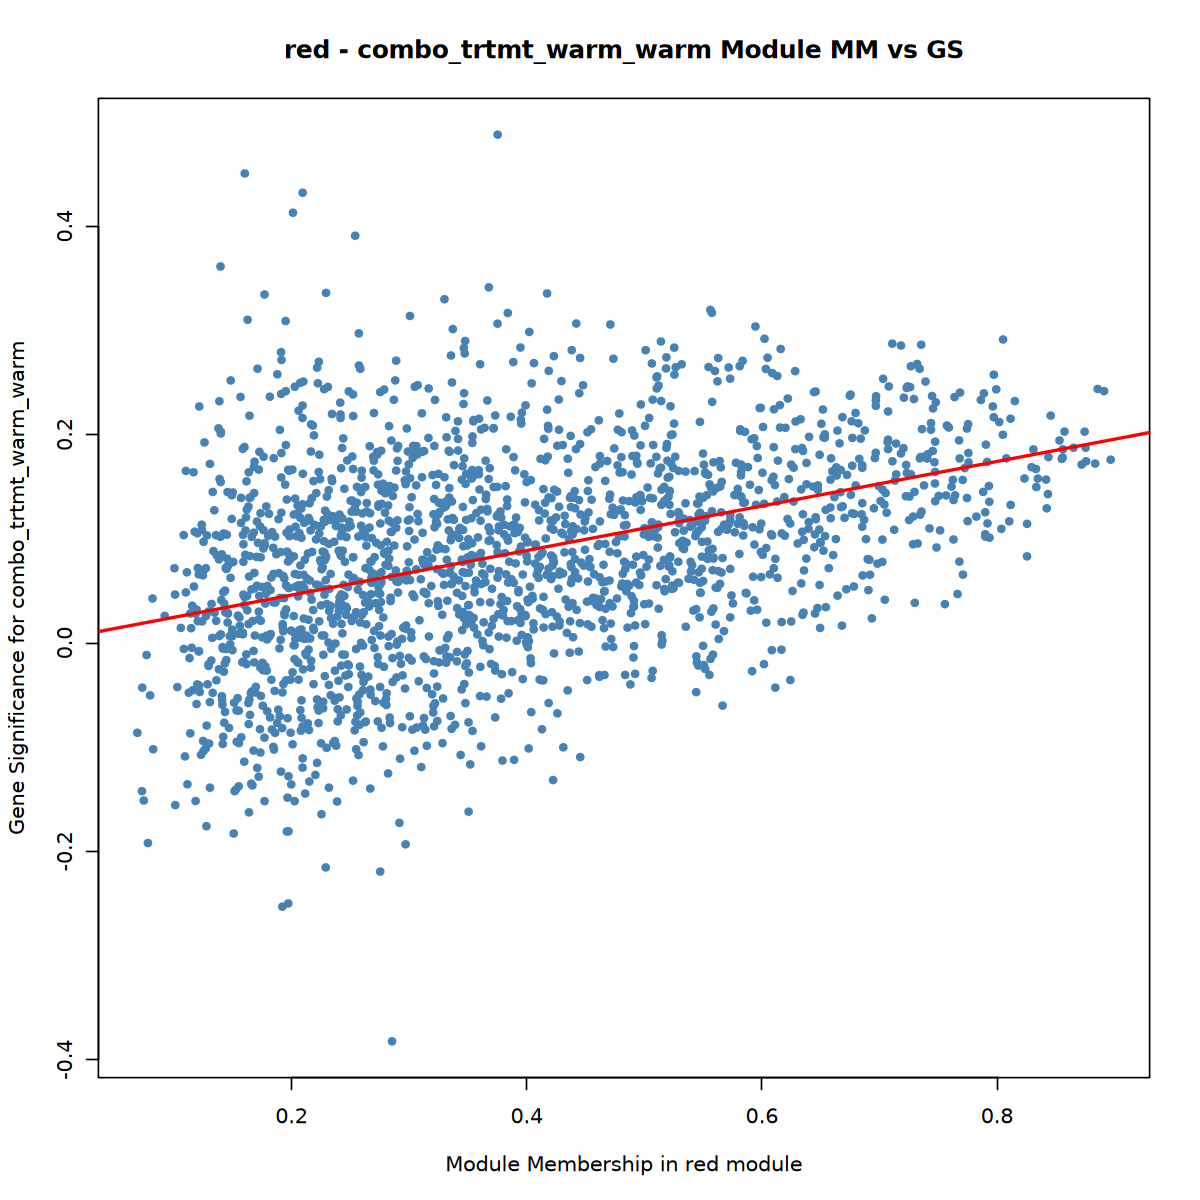

In [105]:
for(trait in colnames(traitMatrix)) {
  
  # 4a. Find top module for this trait
  moduleTraitCor <- cor(MEs, traitMatrix[, trait, drop=FALSE], use="p")
  bestModule <- rownames(moduleTraitCor)[which.max(abs(moduleTraitCor[,1]))]
  bestModuleColor <- sub("^ME", "", bestModule)
  
  # 4b. Extract genes in module
  moduleGenes <- mergedColors_sign == bestModuleColor
  
  # 4c. Extract MM and GS vectors
  mmCol <- paste0("MM.", bestModuleColor)
  gsCol <- paste0("GS.", trait)
  
  x <- as.numeric(geneModuleMembership[moduleGenes, mmCol])
  y <- as.numeric(geneTraitSignificance[moduleGenes, gsCol])
  
  # 4d. Plot MM vs GS
  plot(x, y,
       xlab = paste("Module Membership in", bestModuleColor, "module"),
       ylab = paste("Gene Significance for", trait),
       main = paste(bestModuleColor, "-", trait, "Module MM vs GS"),
       pch = 20, col = "steelblue")
  
  abline(lm(y ~ x), col="red", lwd=2)  # optional trend line
  
  # 4e. Optional: save top hub genes
  geneInfo$hubScore <- abs(geneModuleMembership[, mmCol]) * abs(geneTraitSignificance[, gsCol])
  topGenes <- geneInfo[moduleGenes, ][order(-geneInfo$hubScore[moduleGenes]), ]
  
  # Save top 10 hub genes per trait
  print(paste("Top hub genes for trait:", trait, "Module:", bestModuleColor))
  print(head(topGenes[, c("Gene", "moduleColor", mmCol, gsCol, "hubScore")], 10))
}

In [111]:
colnames(geneInfo)

[1] "Gene"                             "moduleColor"                     
 [3] "MM.green"                         "MM.red"                          
 [5] "MM.blue"                          "MM.midnightblue"                 
 [7] "MM.cyan"                          "MM.brown"                        
 [9] "MM.yellow"                        "MM.turquoise"                    
[11] "MM.pink"                          "MM.black"                        
[13] "MM.tan"                           "MM.salmon"                       
[15] "MM.greenyellow"                   "MM.magenta"                      
[17] "p.MM.green"                       "p.MM.red"                        
[19] "p.MM.blue"                        "p.MM.midnightblue"               
[21] "p.MM.cyan"                        "p.MM.brown"                      
[23] "p.MM.yellow"                      "p.MM.turquoise"                  
[25] "p.MM.pink"                        "p.MM.black"                      
[27] "p.MM.tan"                         "p.MM.salmon"                     
[29] "p.MM.greenyellow"                 "p.MM.magenta"                    
[31] "GS.combo_trtmt_both_both"         "GS.combo_trtmt_both_control"     
[33] "GS.combo_trtmt_both_hypoxic"      "GS.combo_trtmt_both_warm"        
[35] "GS.combo_trtmt_control_both"      "GS.combo_trtmt_control_control"  
[37] "GS.combo_trtmt_control_hypoxic"   "GS.combo_trtmt_control_warm"     
[39] "GS.combo_trtmt_hypoxic_both"      "GS.combo_trtmt_hypoxic_control"  
[41] "GS.combo_trtmt_hypoxic_hypoxic"   "GS.combo_trtmt_hypoxic_warm"     
[43] "GS.combo_trtmt_warm_both"         "GS.combo_trtmt_warm_control"     
[45] "GS.combo_trtmt_warm_hypoxic"      "GS.combo_trtmt_warm_warm"        
[47] "p.GS.combo_trtmt_both_both"       "p.GS.combo_trtmt_both_control"   
[49] "p.GS.combo_trtmt_both_hypoxic"    "p.GS.combo_trtmt_both_warm"      
[51] "p.GS.combo_trtmt_control_both"    "p.GS.combo_trtmt_control_control"
[53] "p.GS.combo_trtmt_control_hypoxic" "p.GS.combo_trtmt_control_warm"   
[55] "p.GS.combo_trtmt_hypoxic_both"    "p.GS.combo_trtmt_hypoxic_control"
[57] "p.GS.combo_trtmt_hypoxic_hypoxic" "p.GS.combo_trtmt_hypoxic_warm"   
[59] "p.GS.combo_trtmt_warm_both"       "p.GS.combo_trtmt_warm_control"   
[61] "p.GS.combo_trtmt_warm_hypoxic"    "p.GS.combo_trtmt_warm_warm"      
[63] "hubScore"

In [110]:
# salmon module 
length(colnames(dataExpr)[mergedColors_sign=="salmon"]) # 542 total genes in the salmon module

salmon_mod <- geneInfo %>%  dplyr::filter(moduleColor %in% 'salmon')
nrow(salmon_mod) # 542 total genes in the magenta module
salmon_mod_05 <- salmon_mod %>%  dplyr::filter(p.MM.salmon < 0.05) 
salmon_mod_05_MM <-salmon_mod_05[,c(8:13)]
nrow(salmon_mod_05_MM) # 536 total genes in the salmon module

salmon_mod_05_MM$Gene.ID <- rownames(magenta_mod_05_MM)
salmon_mod_05_MM_melt <- melt(magenta_mod_05_MM, id=c("Gene.ID"))
salmon_mod_05_MM_melt$Primary <- substr(magenta_mod_05_MM_melt$variable, 4,4)
salmon_mod_05_MM_melt$Second <- substr(magenta_mod_05_MM_melt$variable, 5,5)

ggplot(magenta_mod_05_MM_melt, aes(x=Second, y=value, group=Gene.ID, color = Primary)) +
  theme(panel.grid=element_blank()) +
  scale_color_manual(values=c("#56B4E9","#D55E00")) +
  geom_line(size=0.2, alpha=0.1) +
  theme_bw() +
  facet_wrap(~Primary)

[1] 542

[1] 542

[1] 536

### summary output of network analysis results
from Hovrath Dropbox tutorial

In [127]:
# assign gene IDs 
names(dataExpr) <- colnames(dataExpr)

# return gene names that belong to salmon module
head(names(dataExpr)[moduleColors == 'salmon'])

[1] "LOC111109452" "LOC111133260" "LOC111102393" "LOC111112773" "LOC111116467"
[6] "LOC111132366"

use probe annotation file to connect probe IDs to gene names and universally recognized identification numbers (Entrez codes)